In [1]:
#使用几个benchmark数据集进行实验评估
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tarfile
import bz2

from catboost import CatBoostRegressor
from pandas import DataFrame, Series
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split,GridSearchCV
from bz2 import BZ2File as b2f
from libsvm.commonutil import svm_read_problem
from sklearn.svm import SVR
#屏蔽warning
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#读取相关数据库数据
def read_libsvm_data(dataset_name):
    y,x = svm_read_problem('./dataset/'+dataset_name+'/'+dataset_name+'.txt')
    #print(y)
    #print(x)
    #从字典中提取出来
    X = []
    for i in range(len(x)):
        xx =[]
        for key,value in x[i].items():
            xx.append(value)
        X.append(xx)
    
    X = DataFrame(X)
    y = Series(y)
    return y,X
    

In [3]:
scorelist = []

In [4]:
"""
    A method which can be used for sklearn library training and xgboost, lightgbm and catboost 
"""
n_fold = 10 #10折交叉验证
folds = KFold(n_splits = n_fold,shuffle = True,random_state = 42)
def train_model(X,  y, params=None, folds=folds,
                model_type='lgb', plot_feature_importance=False, model=None):
    """

    :param X: 训练集输入 数据类型：dataframe
    :param X_test: 测试集输入 数据类型：dataframe
    :param y: 训练集y 数据类型：Series
    :param params: 相关参数
    :param folds: 交叉验证折数
    :param model_type: lgb、xgb、cat、rfr或者sklearn
    :param plot_feature_importance: 是否plot feature importance
    :param model:
    :return:
    """
    oof = np.zeros(X.shape[0])  # 生成一个跟X行数一样长的零矩阵
    #prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()  # 生成空矩阵
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        #print(train_index)
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'svr':
            
            model = model
            model.fit(X_train, y_train)
            
            #y_pred_valid = model.best_estimator_.predict(X_valid).reshape(-1, )
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)
        
        if model_type == 'rfr':
            """
                注意randomforest对nan敏感 需要做处理
            """
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)

            #y_pred = model.predict(X_test)

        if model_type == 'lgb':
            """
                #**动态参数 
                n_estimators=100: 要拟合的树的棵树，可以认为是训练轮数 
                n_jobs=1: 并行运行的多线程数 
                nthread [默认为未设置的最大线程数]并行线程数
                """
            model = lgb.LGBMRegressor(**params, n_estimators=20000, nthread=4, n_jobs=-1)
            """
                #eval_metric: 评价指标 rmse - 均方根误差 
                early_stopping_rounds: 提前结束轮数 
                eval_set:训练集与测试集 
                verbose=1000使用详细日志记录级别并将日志记录周期设置为此参数的值
                """
            model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                      verbose=1000, early_stopping_rounds=200)

            y_pred_valid = model.predict(X_valid)
            #y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)  # 使用XGBoost的原生版本需要对数据进行转化
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200,
                              verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            
            #y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)

            #y_pred = model.predict(X_test)

        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000, eval_metric='RMSE',
                                      **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            #y_pred = model.predict(X_test)

        oof[valid_index] = y_pred_valid.reshape(-1, )  # reshape(-1,)转换成一行 将对valid的预测结果存成矩阵
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)  # 每交叉验证一次得到一个loss分数，一共有n_fold个值

        #prediction += y_pred  # 每次预测的结果累加 可能需要.reshape(-1,)

        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1  # 第几次交叉验证的标志
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)  # 将每次交叉验证的结果得到的变量importance保存

    #prediction /= n_fold

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    scorelist.append(np.mean(scores))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)')
            
            return oof,feature_importance
            #return oof, prediction, feature_importance
        return oof
        #return oof, prediction

    else:
        return oof
        #return oof, prediction

## mg数据集实验

In [5]:
#file = read_bz2_file('./dataset/E2006-tfidf/E2006.test.bz2')
y,X = read_libsvm_data('mg')

### 基学习器的训练

#### support vector regression

In [6]:
#support vector regression
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr = train_model(X, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:34:54 2019
Fold 1 started at Tue Dec 17 10:34:54 2019
Fold 2 started at Tue Dec 17 10:34:54 2019
Fold 3 started at Tue Dec 17 10:34:54 2019
Fold 4 started at Tue Dec 17 10:34:54 2019
Fold 5 started at Tue Dec 17 10:34:54 2019
Fold 6 started at Tue Dec 17 10:34:54 2019
Fold 7 started at Tue Dec 17 10:34:54 2019
Fold 8 started at Tue Dec 17 10:34:54 2019
Fold 9 started at Tue Dec 17 10:34:54 2019
CV mean score: 0.1367, std: 0.0074.


#### lightgbm

Fold 0 started at Tue Dec 17 10:34:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[541]	training's rmse: 0.0846455	valid_1's rmse: 0.118287
Fold 1 started at Tue Dec 17 10:34:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[367]	training's rmse: 0.0916833	valid_1's rmse: 0.121149
Fold 2 started at Tue Dec 17 10:34:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[328]	training's rmse: 0.094031	valid_1's rmse: 0.120335
Fold 3 started at Tue Dec 17 10:34:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[315]	training's rmse: 0.0945667	valid_1's rmse: 0.1221
Fold 4 started at Tue Dec 17 10:34:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[308]	training's rmse: 0.0943736	valid_1's rmse: 0.126733
Fold 5 s

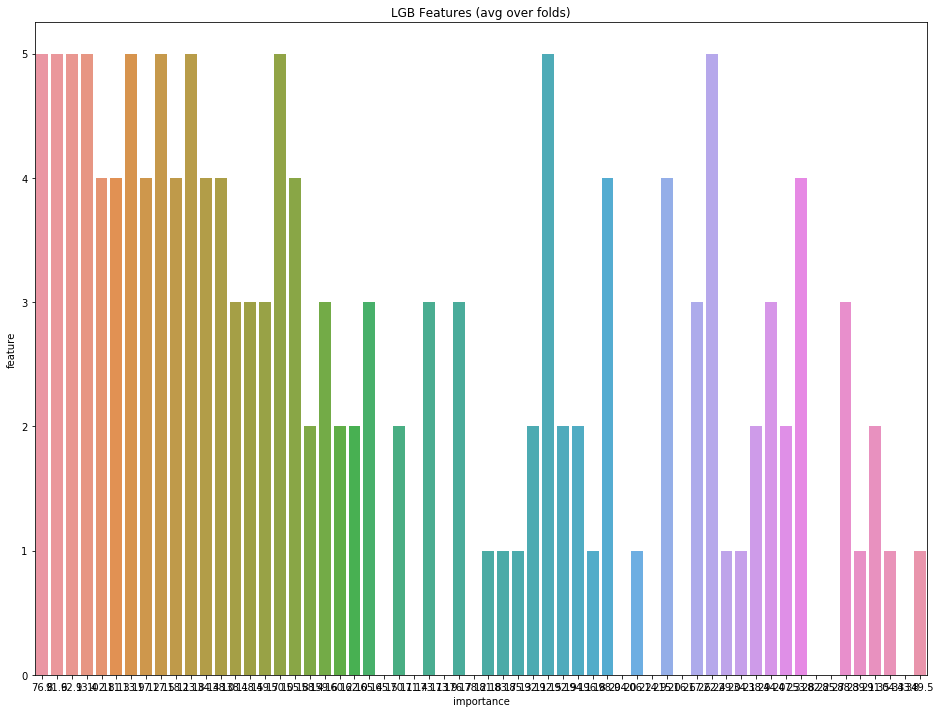

In [7]:
#lgb训练
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:34:59 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.08549	valid_1's rmse: 0.118597
Early stopping, best iteration is:
[1141]	training's rmse: 0.0836203	valid_1's rmse: 0.118415
Fold 1 started at Tue Dec 17 10:35:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[531]	training's rmse: 0.0936502	valid_1's rmse: 0.121003
Fold 2 started at Tue Dec 17 10:35:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[331]	training's rmse: 0.0992678	valid_1's rmse: 0.119436
Fold 3 started at Tue Dec 17 10:35:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 0.0990269	valid_1's rmse: 0.12017
Fold 4 started at Tue Dec 17 10:35:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[316]	

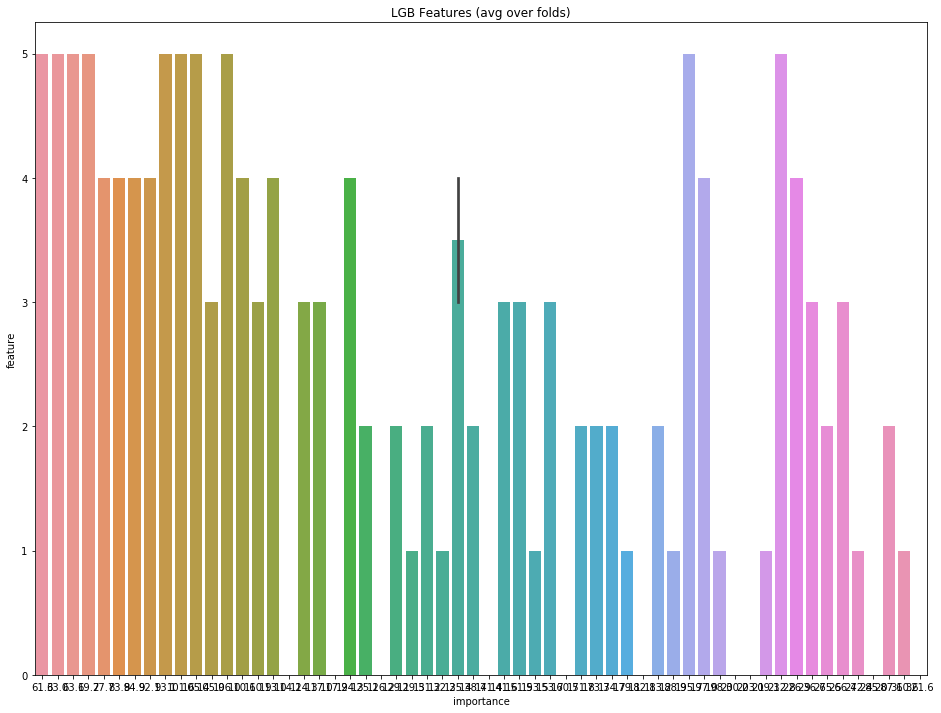

In [8]:
#交叉验证
#训练一个lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:35:04 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.08549	valid_1's rmse: 0.118597
Early stopping, best iteration is:
[1141]	training's rmse: 0.0836203	valid_1's rmse: 0.118415
Fold 1 started at Tue Dec 17 10:35:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[531]	training's rmse: 0.0936502	valid_1's rmse: 0.121003
Fold 2 started at Tue Dec 17 10:35:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[331]	training's rmse: 0.0992678	valid_1's rmse: 0.119436
Fold 3 started at Tue Dec 17 10:35:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 0.0990269	valid_1's rmse: 0.12017
Fold 4 started at Tue Dec 17 10:35:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[316]	

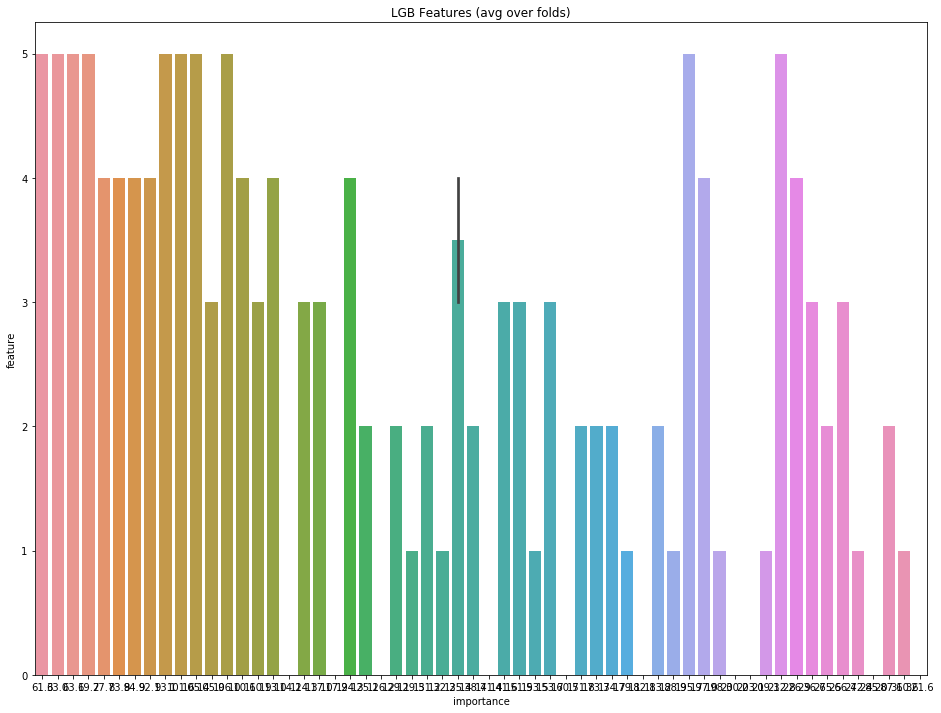

In [9]:
#另一组lgb的训练
pparams = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2,  _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

#### random forest regression

In [10]:
#随机森林的训练
#训练rfr
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr = train_model(X,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:35:21 2019
Fold 1 started at Tue Dec 17 10:35:21 2019
Fold 2 started at Tue Dec 17 10:35:22 2019
Fold 3 started at Tue Dec 17 10:35:22 2019
Fold 4 started at Tue Dec 17 10:35:22 2019
Fold 5 started at Tue Dec 17 10:35:22 2019
Fold 6 started at Tue Dec 17 10:35:23 2019
Fold 7 started at Tue Dec 17 10:35:23 2019
Fold 8 started at Tue Dec 17 10:35:23 2019
Fold 9 started at Tue Dec 17 10:35:23 2019
CV mean score: 0.1191, std: 0.0070.


#### xgboost

In [11]:
#xgboost
#训练xgboost
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb = train_model(X,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:35:23 2019
[0]	train-rmse:0.48241	valid_data-rmse:0.473695
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.056062	valid_data-rmse:0.1157
Stopping. Best iteration:
[477]	train-rmse:0.057266	valid_data-rmse:0.115596

Fold 1 started at Tue Dec 17 10:35:24 2019
[0]	train-rmse:0.481885	valid_data-rmse:0.478521
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.056603	valid_data-rmse:0.120467
Stopping. Best iteration:
[449]	train-rmse:0.058834	valid_data-rmse:0.120359

Fold 2 started at Tue Dec 17 10:35:25 2019
[0]	train-rmse:0.480885	valid_data-rmse:0.487403
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[

#### catboost

In [12]:
#catboost
#catboost训练
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat = train_model(X, y, params=cat_params, model_type='cat')

Fold 0 started at Tue Dec 17 10:35:32 2019
Fold 1 started at Tue Dec 17 10:36:00 2019
Fold 2 started at Tue Dec 17 10:36:04 2019
Fold 3 started at Tue Dec 17 10:36:13 2019
Fold 4 started at Tue Dec 17 10:36:17 2019
Fold 5 started at Tue Dec 17 10:36:20 2019
Fold 6 started at Tue Dec 17 10:36:28 2019
Fold 7 started at Tue Dec 17 10:36:40 2019
Fold 8 started at Tue Dec 17 10:36:54 2019
Fold 9 started at Tue Dec 17 10:37:07 2019
CV mean score: 0.1175, std: 0.0077.


### stacking

#### 所有结果均用于做stacking

In [13]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:37:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[239]	training's rmse: 0.101176	valid_1's rmse: 0.128584
Fold 1 started at Tue Dec 17 10:37:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[390]	training's rmse: 0.093688	valid_1's rmse: 0.123517
Fold 2 started at Tue Dec 17 10:37:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[247]	training's rmse: 0.101124	valid_1's rmse: 0.119785
Fold 3 started at Tue Dec 17 10:37:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[277]	training's rmse: 0.0992634	valid_1's rmse: 0.120241
Fold 4 started at Tue Dec 17 10:37:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[276]	training's rmse: 0.0993391	valid_1's rmse: 0.124098
Fold 5 s

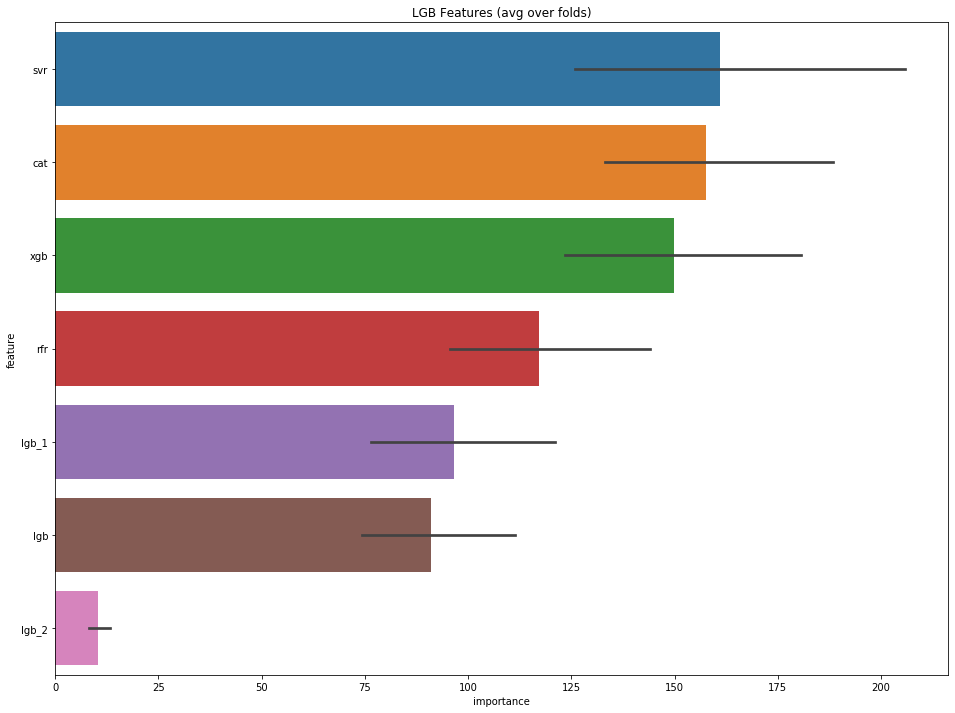

In [14]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:37:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[265]	training's rmse: 0.110727	valid_1's rmse: 0.122716
Fold 1 started at Tue Dec 17 10:37:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[394]	training's rmse: 0.108253	valid_1's rmse: 0.122131
Fold 2 started at Tue Dec 17 10:37:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[286]	training's rmse: 0.110412	valid_1's rmse: 0.117403
Fold 3 started at Tue Dec 17 10:37:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[316]	training's rmse: 0.110004	valid_1's rmse: 0.117375
Fold 4 started at Tue Dec 17 10:37:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[269]	training's rmse: 0.110558	valid_1's rmse: 0.123935
Fold 5 sta

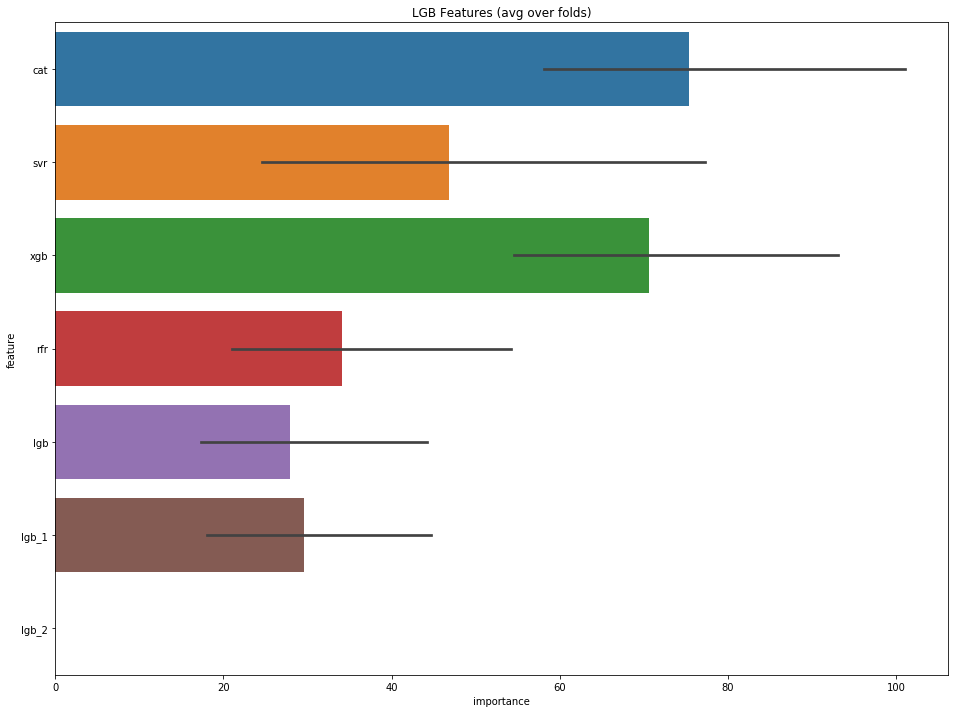

In [15]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [16]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 10:37:17 2019
Fold 1 started at Tue Dec 17 10:37:19 2019
Fold 2 started at Tue Dec 17 10:37:24 2019
Fold 3 started at Tue Dec 17 10:37:36 2019
Fold 4 started at Tue Dec 17 10:37:40 2019
Fold 5 started at Tue Dec 17 10:37:43 2019
Fold 6 started at Tue Dec 17 10:37:48 2019
Fold 7 started at Tue Dec 17 10:37:56 2019
Fold 8 started at Tue Dec 17 10:38:08 2019
Fold 9 started at Tue Dec 17 10:38:13 2019
CV mean score: 0.1170, std: 0.0072.


##### randomforest作为第二层融合模型

In [17]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:38:16 2019
Fold 1 started at Tue Dec 17 10:38:16 2019
Fold 2 started at Tue Dec 17 10:38:17 2019
Fold 3 started at Tue Dec 17 10:38:17 2019
Fold 4 started at Tue Dec 17 10:38:17 2019
Fold 5 started at Tue Dec 17 10:38:17 2019
Fold 6 started at Tue Dec 17 10:38:18 2019
Fold 7 started at Tue Dec 17 10:38:18 2019
Fold 8 started at Tue Dec 17 10:38:18 2019
Fold 9 started at Tue Dec 17 10:38:18 2019
CV mean score: 0.1209, std: 0.0063.


##### xgboost作为第二层融合模型

In [18]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:38:19 2019
[0]	train-rmse:0.482357	valid_data-rmse:0.473631
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.062218	valid_data-rmse:0.134345
Stopping. Best iteration:
[381]	train-rmse:0.069014	valid_data-rmse:0.133206

Fold 1 started at Tue Dec 17 10:38:19 2019
[0]	train-rmse:0.481829	valid_data-rmse:0.478487
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.063642	valid_data-rmse:0.123856
Stopping. Best iteration:
[464]	train-rmse:0.0653	valid_data-rmse:0.123691

Fold 2 started at Tue Dec 17 10:38:20 2019
[0]	train-rmse:0.48083	valid_data-rmse:0.487347
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[

##### svr 作为第二层融合模型

In [19]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:38:26 2019
Fold 1 started at Tue Dec 17 10:38:26 2019
Fold 2 started at Tue Dec 17 10:38:26 2019
Fold 3 started at Tue Dec 17 10:38:26 2019
Fold 4 started at Tue Dec 17 10:38:26 2019
Fold 5 started at Tue Dec 17 10:38:26 2019
Fold 6 started at Tue Dec 17 10:38:26 2019
Fold 7 started at Tue Dec 17 10:38:26 2019
Fold 8 started at Tue Dec 17 10:38:26 2019
Fold 9 started at Tue Dec 17 10:38:26 2019
CV mean score: 0.1168, std: 0.0078.


##### 岭回归做第二层融合模型

In [20]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 10:38:26 2019
Fold 1 started at Tue Dec 17 10:38:26 2019
Fold 2 started at Tue Dec 17 10:38:26 2019
Fold 3 started at Tue Dec 17 10:38:27 2019
Fold 4 started at Tue Dec 17 10:38:27 2019
Fold 5 started at Tue Dec 17 10:38:27 2019
Fold 6 started at Tue Dec 17 10:38:27 2019
Fold 7 started at Tue Dec 17 10:38:27 2019
Fold 8 started at Tue Dec 17 10:38:27 2019
Fold 9 started at Tue Dec 17 10:38:27 2019
CV mean score: 0.1167, std: 0.0077.


#### 去掉lgb的结果

In [21]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_xgb, oof_cat, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'cat', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:38:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[243]	training's rmse: 0.103137	valid_1's rmse: 0.127586
Fold 1 started at Tue Dec 17 10:38:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[388]	training's rmse: 0.0970039	valid_1's rmse: 0.123023
Fold 2 started at Tue Dec 17 10:38:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[257]	training's rmse: 0.102988	valid_1's rmse: 0.118914
Fold 3 started at Tue Dec 17 10:38:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[283]	training's rmse: 0.101906	valid_1's rmse: 0.115594
Fold 4 started at Tue Dec 17 10:38:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[275]	training's rmse: 0.101696	valid_1's rmse: 0.123252
Fold 5 st

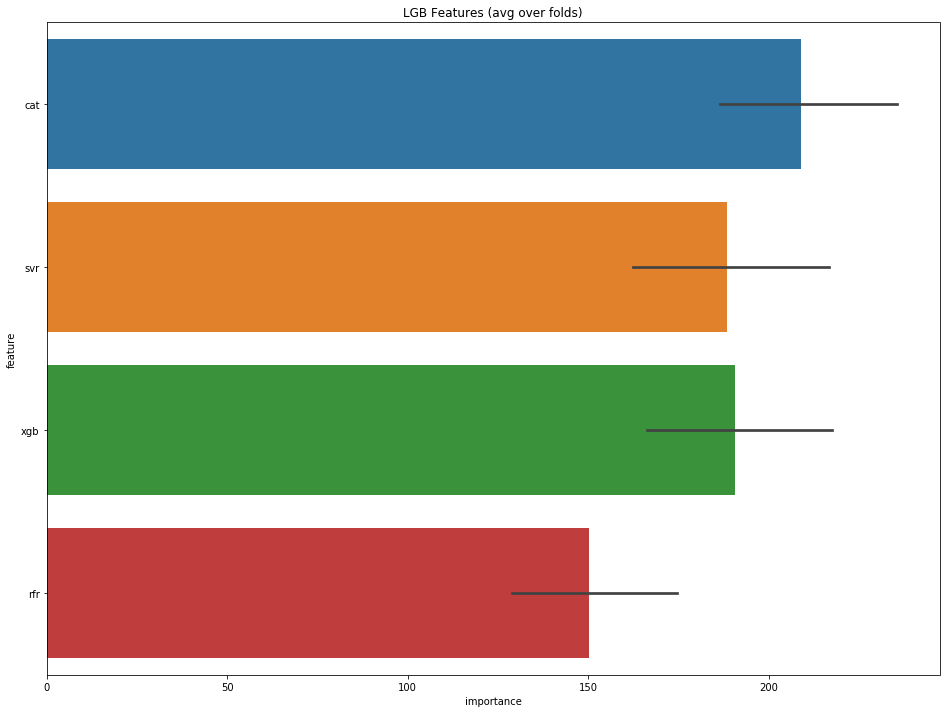

In [22]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:38:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[240]	training's rmse: 0.111831	valid_1's rmse: 0.12211
Fold 1 started at Tue Dec 17 10:38:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[481]	training's rmse: 0.107865	valid_1's rmse: 0.121108
Fold 2 started at Tue Dec 17 10:38:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[284]	training's rmse: 0.110959	valid_1's rmse: 0.116764
Fold 3 started at Tue Dec 17 10:38:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[449]	training's rmse: 0.108502	valid_1's rmse: 0.115524
Fold 4 started at Tue Dec 17 10:38:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[251]	training's rmse: 0.111467	valid_1's rmse: 0.123704
Fold 5 star

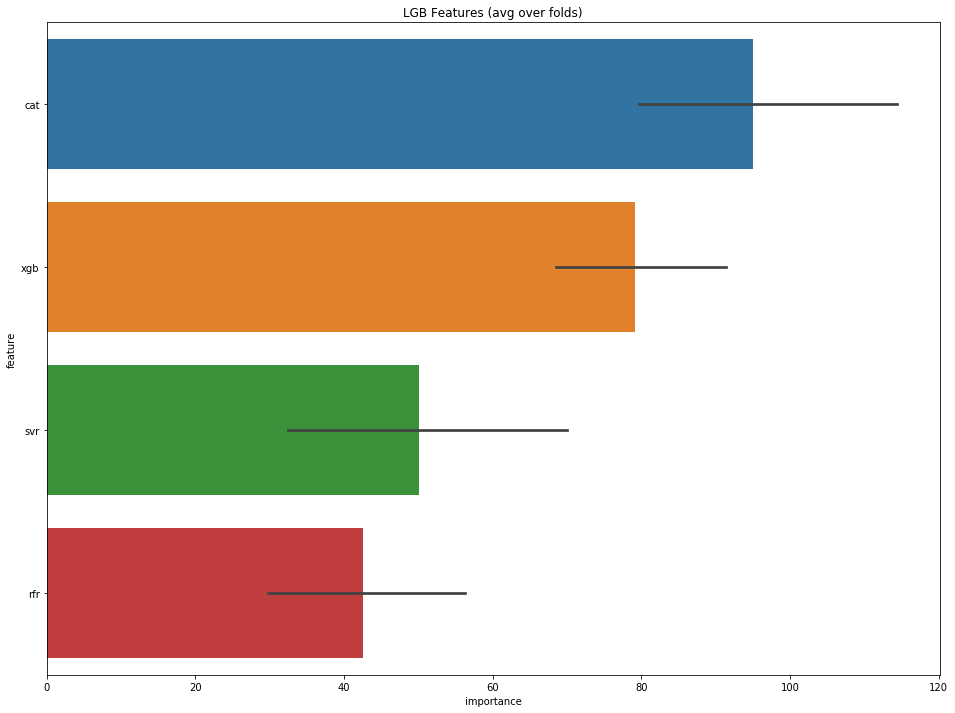

In [23]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [24]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 10:38:35 2019
Fold 1 started at Tue Dec 17 10:38:38 2019
Fold 2 started at Tue Dec 17 10:38:40 2019
Fold 3 started at Tue Dec 17 10:38:44 2019
Fold 4 started at Tue Dec 17 10:38:47 2019
Fold 5 started at Tue Dec 17 10:38:49 2019
Fold 6 started at Tue Dec 17 10:38:55 2019
Fold 7 started at Tue Dec 17 10:39:07 2019
Fold 8 started at Tue Dec 17 10:39:25 2019
Fold 9 started at Tue Dec 17 10:39:32 2019
CV mean score: 0.1168, std: 0.0069.


##### randomforest作为第二层融合模型

In [25]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:39:37 2019
Fold 1 started at Tue Dec 17 10:39:37 2019
Fold 2 started at Tue Dec 17 10:39:38 2019
Fold 3 started at Tue Dec 17 10:39:38 2019
Fold 4 started at Tue Dec 17 10:39:38 2019
Fold 5 started at Tue Dec 17 10:39:38 2019
Fold 6 started at Tue Dec 17 10:39:38 2019
Fold 7 started at Tue Dec 17 10:39:39 2019
Fold 8 started at Tue Dec 17 10:39:39 2019
Fold 9 started at Tue Dec 17 10:39:39 2019
CV mean score: 0.1172, std: 0.0057.


##### xgboost作为第二层融合模型

In [26]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:39:39 2019
[0]	train-rmse:0.482355	valid_data-rmse:0.473601
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.065052	valid_data-rmse:0.131723
Stopping. Best iteration:
[360]	train-rmse:0.073323	valid_data-rmse:0.131052

Fold 1 started at Tue Dec 17 10:39:40 2019
[0]	train-rmse:0.481836	valid_data-rmse:0.478481
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.066682	valid_data-rmse:0.125491
Stopping. Best iteration:
[419]	train-rmse:0.070851	valid_data-rmse:0.12531

Fold 2 started at Tue Dec 17 10:39:41 2019
[0]	train-rmse:0.48085	valid_data-rmse:0.487332
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


##### svr 作为第二层融合模型

In [27]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:39:47 2019
Fold 1 started at Tue Dec 17 10:39:47 2019
Fold 2 started at Tue Dec 17 10:39:47 2019
Fold 3 started at Tue Dec 17 10:39:47 2019
Fold 4 started at Tue Dec 17 10:39:48 2019
Fold 5 started at Tue Dec 17 10:39:48 2019
Fold 6 started at Tue Dec 17 10:39:48 2019
Fold 7 started at Tue Dec 17 10:39:48 2019
Fold 8 started at Tue Dec 17 10:39:48 2019
Fold 9 started at Tue Dec 17 10:39:48 2019
CV mean score: 0.1169, std: 0.0077.


##### 岭回归做第二层融合模型

In [28]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 10:39:48 2019
Fold 1 started at Tue Dec 17 10:39:48 2019
Fold 2 started at Tue Dec 17 10:39:48 2019
Fold 3 started at Tue Dec 17 10:39:48 2019
Fold 4 started at Tue Dec 17 10:39:48 2019
Fold 5 started at Tue Dec 17 10:39:48 2019
Fold 6 started at Tue Dec 17 10:39:48 2019
Fold 7 started at Tue Dec 17 10:39:48 2019
Fold 8 started at Tue Dec 17 10:39:48 2019
Fold 9 started at Tue Dec 17 10:39:49 2019
CV mean score: 0.1169, std: 0.0075.


#### 去掉xgboost的结果

In [29]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_cat, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:39:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[236]	training's rmse: 0.103111	valid_1's rmse: 0.12966
Fold 1 started at Tue Dec 17 10:39:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[357]	training's rmse: 0.0974115	valid_1's rmse: 0.12572
Fold 2 started at Tue Dec 17 10:40:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[276]	training's rmse: 0.101547	valid_1's rmse: 0.121381
Fold 3 started at Tue Dec 17 10:40:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[295]	training's rmse: 0.100519	valid_1's rmse: 0.119908
Fold 4 started at Tue Dec 17 10:40:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[291]	training's rmse: 0.100556	valid_1's rmse: 0.12518
Fold 5 start

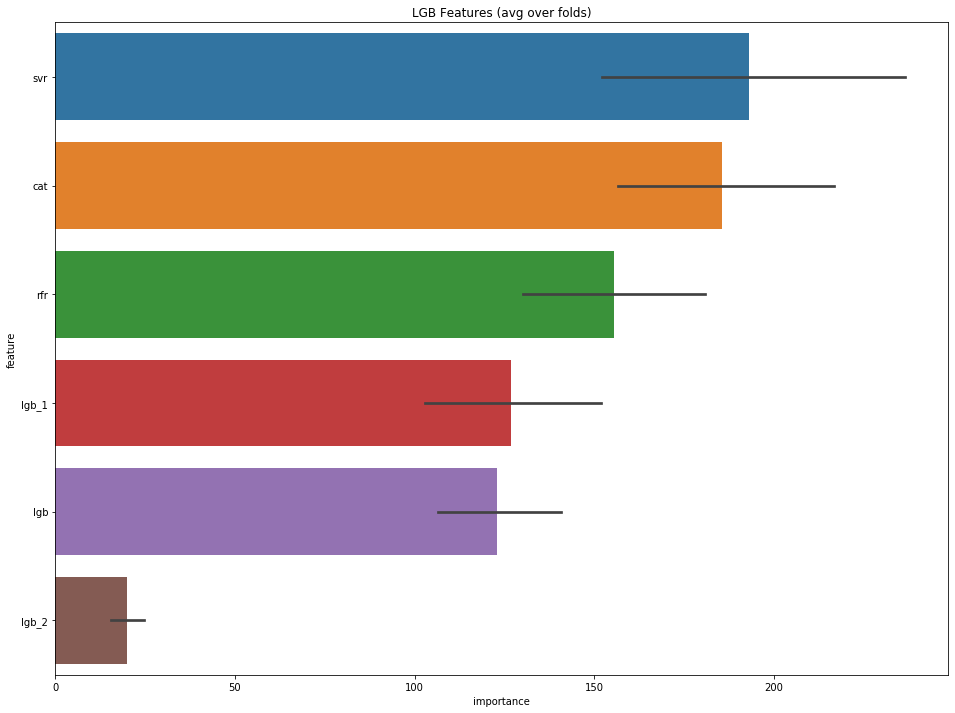

In [30]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:40:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[251]	training's rmse: 0.112027	valid_1's rmse: 0.124408
Fold 1 started at Tue Dec 17 10:40:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[344]	training's rmse: 0.110217	valid_1's rmse: 0.123587
Fold 2 started at Tue Dec 17 10:40:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[362]	training's rmse: 0.110127	valid_1's rmse: 0.119374
Fold 3 started at Tue Dec 17 10:40:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[301]	training's rmse: 0.111475	valid_1's rmse: 0.118252
Fold 4 started at Tue Dec 17 10:40:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[333]	training's rmse: 0.110204	valid_1's rmse: 0.125299
Fold 5 sta

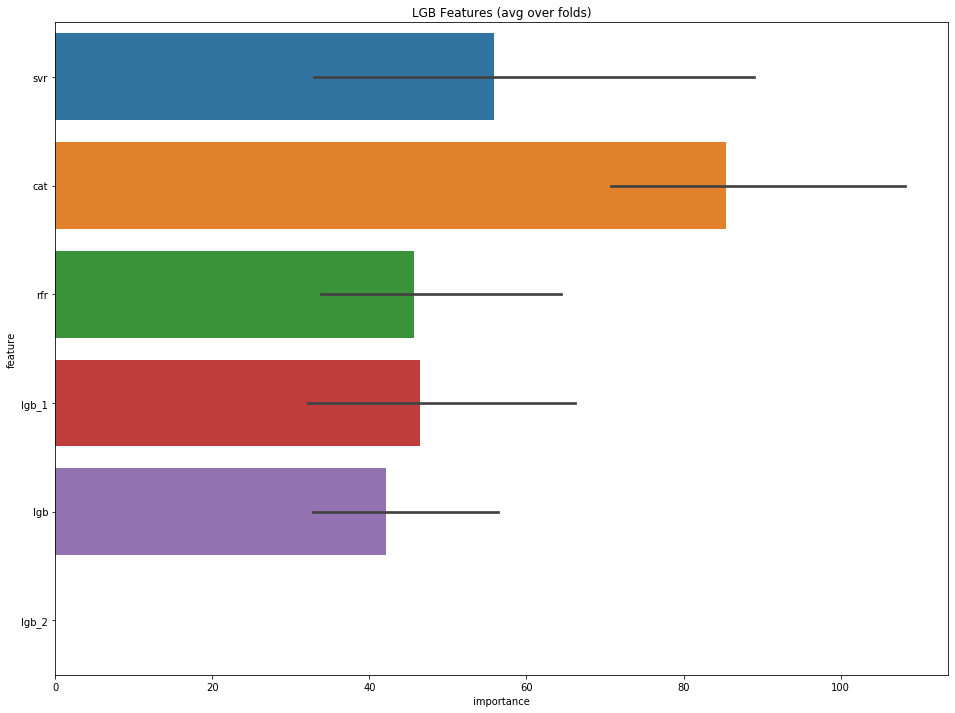

In [31]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [32]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 10:41:07 2019
Fold 1 started at Tue Dec 17 10:41:12 2019
Fold 2 started at Tue Dec 17 10:41:17 2019
Fold 3 started at Tue Dec 17 10:41:24 2019
Fold 4 started at Tue Dec 17 10:41:29 2019
Fold 5 started at Tue Dec 17 10:41:33 2019
Fold 6 started at Tue Dec 17 10:41:38 2019
Fold 7 started at Tue Dec 17 10:41:46 2019
Fold 8 started at Tue Dec 17 10:41:54 2019
Fold 9 started at Tue Dec 17 10:42:02 2019
CV mean score: 0.1176, std: 0.0073.


##### randomforest作为第二层融合模型

In [33]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:42:07 2019
Fold 1 started at Tue Dec 17 10:42:08 2019
Fold 2 started at Tue Dec 17 10:42:08 2019
Fold 3 started at Tue Dec 17 10:42:08 2019
Fold 4 started at Tue Dec 17 10:42:08 2019
Fold 5 started at Tue Dec 17 10:42:08 2019
Fold 6 started at Tue Dec 17 10:42:09 2019
Fold 7 started at Tue Dec 17 10:42:09 2019
Fold 8 started at Tue Dec 17 10:42:09 2019
Fold 9 started at Tue Dec 17 10:42:09 2019
CV mean score: 0.1209, std: 0.0070.


##### xgboost作为第二层融合模型

In [34]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:42:10 2019
[0]	train-rmse:0.482365	valid_data-rmse:0.473645
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.066064	valid_data-rmse:0.137455
Stopping. Best iteration:
[366]	train-rmse:0.073534	valid_data-rmse:0.136083

Fold 1 started at Tue Dec 17 10:42:11 2019
[0]	train-rmse:0.48184	valid_data-rmse:0.478442
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.067011	valid_data-rmse:0.128102
Stopping. Best iteration:
[468]	train-rmse:0.068391	valid_data-rmse:0.127922

Fold 2 started at Tue Dec 17 10:42:12 2019
[0]	train-rmse:0.480843	valid_data-rmse:0.487318
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

##### svr 作为第二层融合模型

In [35]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:42:20 2019
Fold 1 started at Tue Dec 17 10:42:20 2019
Fold 2 started at Tue Dec 17 10:42:20 2019
Fold 3 started at Tue Dec 17 10:42:20 2019
Fold 4 started at Tue Dec 17 10:42:20 2019
Fold 5 started at Tue Dec 17 10:42:20 2019
Fold 6 started at Tue Dec 17 10:42:20 2019
Fold 7 started at Tue Dec 17 10:42:20 2019
Fold 8 started at Tue Dec 17 10:42:21 2019
Fold 9 started at Tue Dec 17 10:42:21 2019
CV mean score: 0.1169, std: 0.0078.


##### 岭回归做第二层融合模型

In [36]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 10:42:21 2019
Fold 1 started at Tue Dec 17 10:42:21 2019
Fold 2 started at Tue Dec 17 10:42:21 2019
Fold 3 started at Tue Dec 17 10:42:21 2019
Fold 4 started at Tue Dec 17 10:42:21 2019
Fold 5 started at Tue Dec 17 10:42:21 2019
Fold 6 started at Tue Dec 17 10:42:21 2019
Fold 7 started at Tue Dec 17 10:42:21 2019
Fold 8 started at Tue Dec 17 10:42:22 2019
Fold 9 started at Tue Dec 17 10:42:22 2019
CV mean score: 0.1169, std: 0.0077.


#### 去掉svr的结果

In [37]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:42:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[230]	training's rmse: 0.103996	valid_1's rmse: 0.129162
Fold 1 started at Tue Dec 17 10:42:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[320]	training's rmse: 0.0997539	valid_1's rmse: 0.123761
Fold 2 started at Tue Dec 17 10:42:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[260]	training's rmse: 0.102675	valid_1's rmse: 0.120888
Fold 3 started at Tue Dec 17 10:42:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[233]	training's rmse: 0.104973	valid_1's rmse: 0.121484
Fold 4 started at Tue Dec 17 10:42:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[271]	training's rmse: 0.102439	valid_1's rmse: 0.123885
Fold 5 st

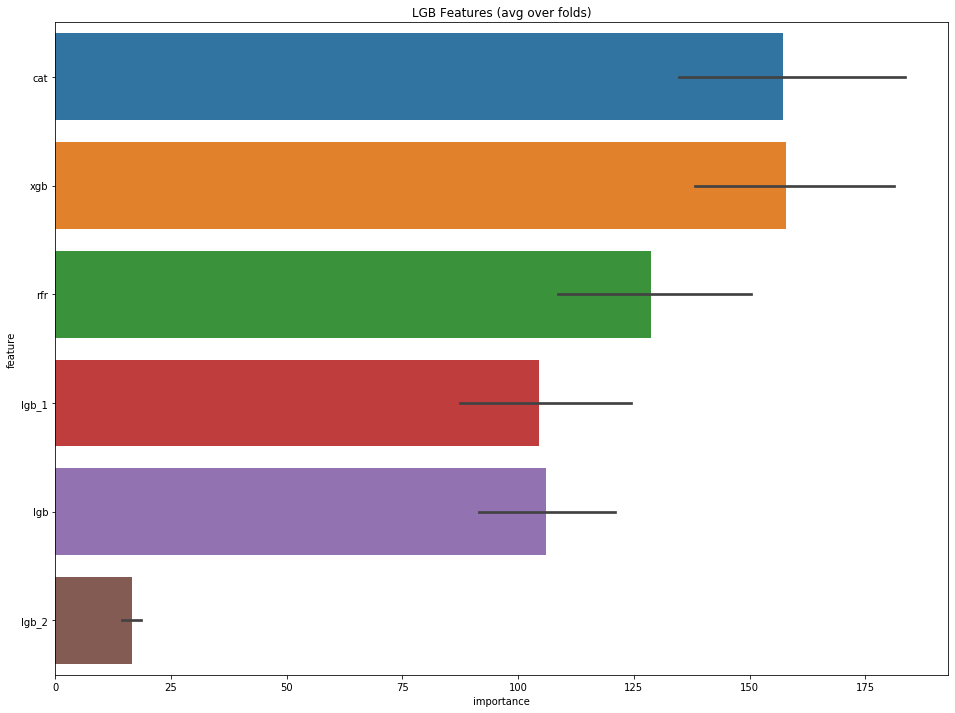

In [38]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:43:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[299]	training's rmse: 0.109748	valid_1's rmse: 0.12325
Fold 1 started at Tue Dec 17 10:43:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[447]	training's rmse: 0.108063	valid_1's rmse: 0.121352
Fold 2 started at Tue Dec 17 10:43:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[265]	training's rmse: 0.111199	valid_1's rmse: 0.118115
Fold 3 started at Tue Dec 17 10:43:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[395]	training's rmse: 0.108972	valid_1's rmse: 0.117528
Fold 4 started at Tue Dec 17 10:43:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[407]	training's rmse: 0.108361	valid_1's rmse: 0.123542
Fold 5 star

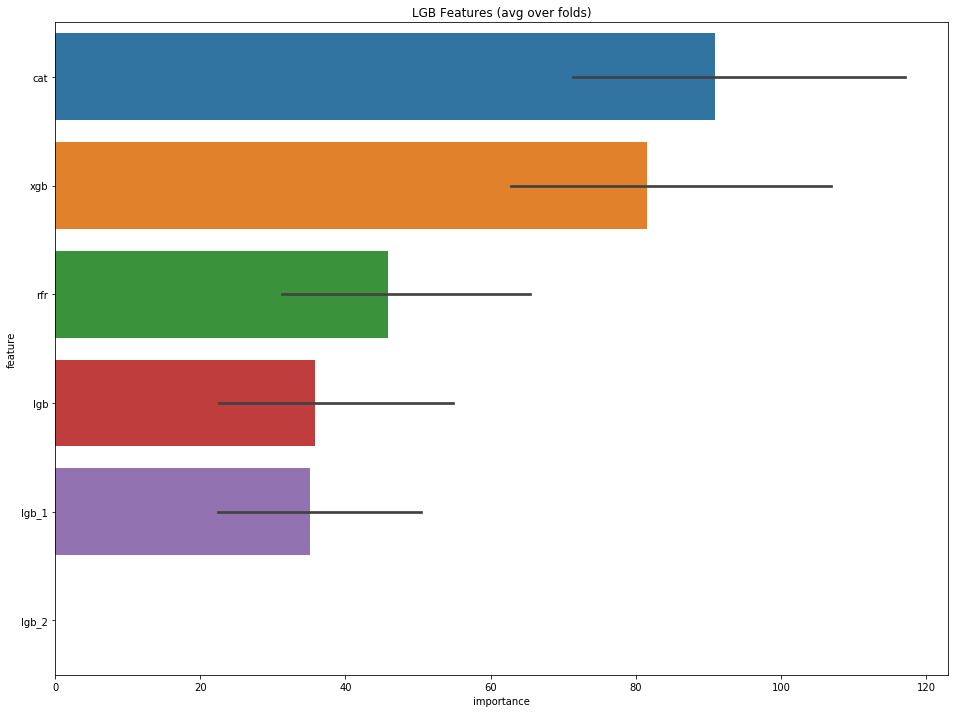

In [39]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [40]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 10:43:08 2019
Fold 1 started at Tue Dec 17 10:43:13 2019
Fold 2 started at Tue Dec 17 10:43:20 2019
Fold 3 started at Tue Dec 17 10:43:29 2019
Fold 4 started at Tue Dec 17 10:43:37 2019
Fold 5 started at Tue Dec 17 10:43:47 2019
Fold 6 started at Tue Dec 17 10:44:03 2019
Fold 7 started at Tue Dec 17 10:44:23 2019
Fold 8 started at Tue Dec 17 10:44:50 2019
Fold 9 started at Tue Dec 17 10:45:00 2019
CV mean score: 0.1167, std: 0.0075.


##### randomforest作为第二层融合模型

In [41]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:45:07 2019
Fold 1 started at Tue Dec 17 10:45:07 2019
Fold 2 started at Tue Dec 17 10:45:07 2019
Fold 3 started at Tue Dec 17 10:45:08 2019
Fold 4 started at Tue Dec 17 10:45:08 2019
Fold 5 started at Tue Dec 17 10:45:08 2019
Fold 6 started at Tue Dec 17 10:45:08 2019
Fold 7 started at Tue Dec 17 10:45:09 2019
Fold 8 started at Tue Dec 17 10:45:09 2019
Fold 9 started at Tue Dec 17 10:45:09 2019
CV mean score: 0.1188, std: 0.0073.


##### xgboost作为第二层融合模型

In [42]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:45:09 2019
[0]	train-rmse:0.482364	valid_data-rmse:0.473619
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.066325	valid_data-rmse:0.132396
Stopping. Best iteration:
[366]	train-rmse:0.074133	valid_data-rmse:0.130955

Fold 1 started at Tue Dec 17 10:45:10 2019
[0]	train-rmse:0.481837	valid_data-rmse:0.478487
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.067666	valid_data-rmse:0.126276
Stopping. Best iteration:
[476]	train-rmse:0.068672	valid_data-rmse:0.126175

Fold 2 started at Tue Dec 17 10:45:11 2019
[0]	train-rmse:0.48083	valid_data-rmse:0.487355
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

##### svr 作为第二层融合模型

In [43]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:45:20 2019
Fold 1 started at Tue Dec 17 10:45:20 2019
Fold 2 started at Tue Dec 17 10:45:20 2019
Fold 3 started at Tue Dec 17 10:45:20 2019
Fold 4 started at Tue Dec 17 10:45:20 2019
Fold 5 started at Tue Dec 17 10:45:20 2019
Fold 6 started at Tue Dec 17 10:45:20 2019
Fold 7 started at Tue Dec 17 10:45:20 2019
Fold 8 started at Tue Dec 17 10:45:20 2019
Fold 9 started at Tue Dec 17 10:45:20 2019
CV mean score: 0.1167, std: 0.0077.


##### 岭回归做第二层融合模型

In [44]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 10:45:20 2019
Fold 1 started at Tue Dec 17 10:45:20 2019
Fold 2 started at Tue Dec 17 10:45:21 2019
Fold 3 started at Tue Dec 17 10:45:21 2019
Fold 4 started at Tue Dec 17 10:45:21 2019
Fold 5 started at Tue Dec 17 10:45:21 2019
Fold 6 started at Tue Dec 17 10:45:21 2019
Fold 7 started at Tue Dec 17 10:45:21 2019
Fold 8 started at Tue Dec 17 10:45:21 2019
Fold 9 started at Tue Dec 17 10:45:21 2019
CV mean score: 0.1166, std: 0.0078.


#### 去掉rfr的结果

In [45]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:45:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 0.101395	valid_1's rmse: 0.127799
Fold 1 started at Tue Dec 17 10:45:30 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0818485	valid_1's rmse: 0.120788
Early stopping, best iteration is:
[1226]	training's rmse: 0.0782271	valid_1's rmse: 0.120326
Fold 2 started at Tue Dec 17 10:45:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[246]	training's rmse: 0.102594	valid_1's rmse: 0.119234
Fold 3 started at Tue Dec 17 10:46:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[257]	training's rmse: 0.101968	valid_1's rmse: 0.12107
Fold 4 started at Tue Dec 17 10:46:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	t

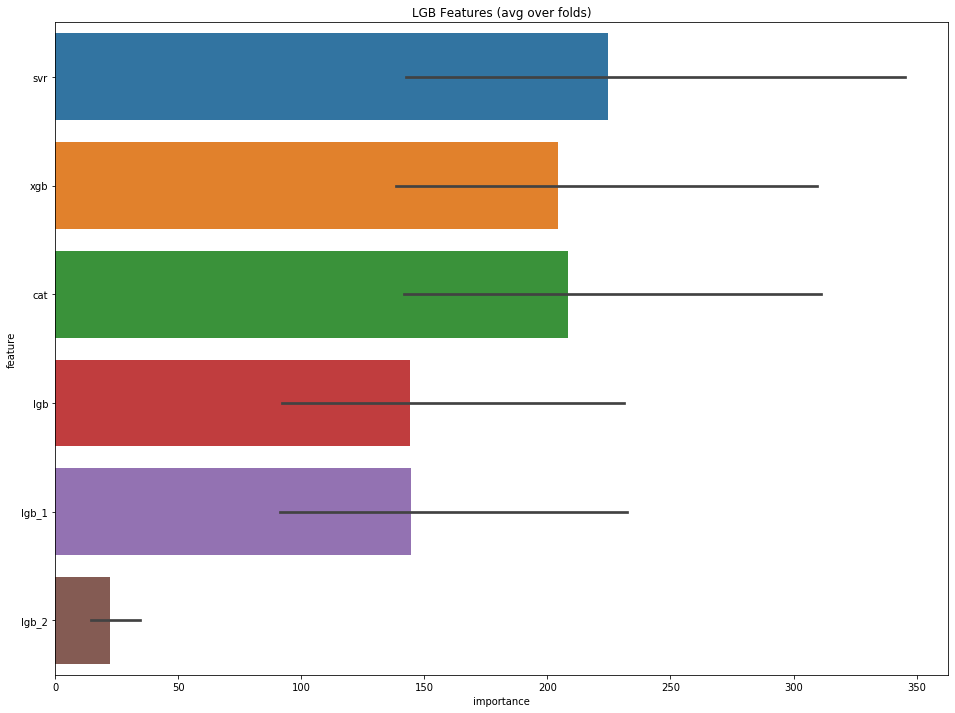

In [46]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:46:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[280]	training's rmse: 0.11046	valid_1's rmse: 0.123614
Fold 1 started at Tue Dec 17 10:46:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[424]	training's rmse: 0.108057	valid_1's rmse: 0.122203
Fold 2 started at Tue Dec 17 10:47:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[406]	training's rmse: 0.108662	valid_1's rmse: 0.11714
Fold 3 started at Tue Dec 17 10:47:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[340]	training's rmse: 0.109835	valid_1's rmse: 0.117978
Fold 4 started at Tue Dec 17 10:47:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[292]	training's rmse: 0.110283	valid_1's rmse: 0.123061
Fold 5 start

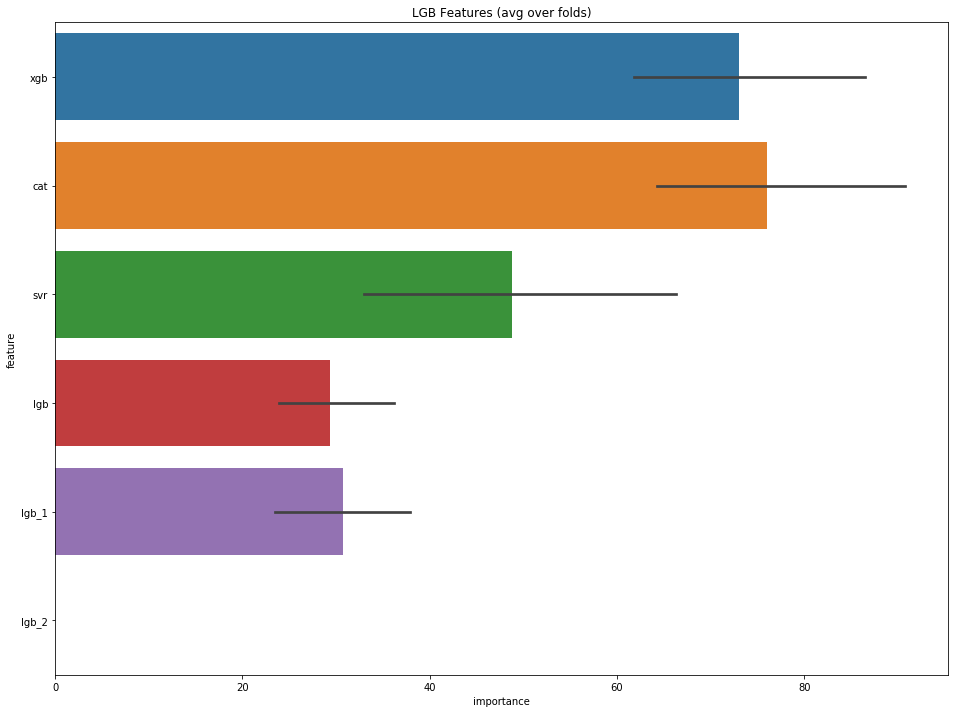

In [47]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [48]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 10:47:26 2019
Fold 1 started at Tue Dec 17 10:47:38 2019
Fold 2 started at Tue Dec 17 10:47:49 2019
Fold 3 started at Tue Dec 17 10:48:04 2019
Fold 4 started at Tue Dec 17 10:48:11 2019
Fold 5 started at Tue Dec 17 10:48:19 2019
Fold 6 started at Tue Dec 17 10:48:32 2019
Fold 7 started at Tue Dec 17 10:48:48 2019
Fold 8 started at Tue Dec 17 10:49:10 2019
Fold 9 started at Tue Dec 17 10:49:20 2019
CV mean score: 0.1170, std: 0.0073.


##### randomforest作为第二层融合模型

In [49]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:49:28 2019
Fold 1 started at Tue Dec 17 10:49:29 2019
Fold 2 started at Tue Dec 17 10:49:29 2019
Fold 3 started at Tue Dec 17 10:49:29 2019
Fold 4 started at Tue Dec 17 10:49:29 2019
Fold 5 started at Tue Dec 17 10:49:30 2019
Fold 6 started at Tue Dec 17 10:49:30 2019
Fold 7 started at Tue Dec 17 10:49:30 2019
Fold 8 started at Tue Dec 17 10:49:30 2019
Fold 9 started at Tue Dec 17 10:49:31 2019
CV mean score: 0.1191, std: 0.0056.


##### xgboost作为第二层融合模型

In [50]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:49:31 2019
[0]	train-rmse:0.482361	valid_data-rmse:0.473679
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.065291	valid_data-rmse:0.131292
Stopping. Best iteration:
[382]	train-rmse:0.07193	valid_data-rmse:0.130708

Fold 1 started at Tue Dec 17 10:49:32 2019
[0]	train-rmse:0.481835	valid_data-rmse:0.478473
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.066364	valid_data-rmse:0.120469
Stopping. Best iteration:
[477]	train-rmse:0.067292	valid_data-rmse:0.120382

Fold 2 started at Tue Dec 17 10:49:33 2019
[0]	train-rmse:0.480834	valid_data-rmse:0.487318
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

##### svr 作为第二层融合模型

In [51]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:49:41 2019
Fold 1 started at Tue Dec 17 10:49:41 2019
Fold 2 started at Tue Dec 17 10:49:41 2019
Fold 3 started at Tue Dec 17 10:49:41 2019
Fold 4 started at Tue Dec 17 10:49:41 2019
Fold 5 started at Tue Dec 17 10:49:41 2019
Fold 6 started at Tue Dec 17 10:49:41 2019
Fold 7 started at Tue Dec 17 10:49:41 2019
Fold 8 started at Tue Dec 17 10:49:41 2019
Fold 9 started at Tue Dec 17 10:49:41 2019
CV mean score: 0.1168, std: 0.0079.


##### 岭回归做第二层融合模型

In [52]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 10:49:41 2019
Fold 1 started at Tue Dec 17 10:49:41 2019
Fold 2 started at Tue Dec 17 10:49:41 2019
Fold 3 started at Tue Dec 17 10:49:42 2019
Fold 4 started at Tue Dec 17 10:49:42 2019
Fold 5 started at Tue Dec 17 10:49:42 2019
Fold 6 started at Tue Dec 17 10:49:42 2019
Fold 7 started at Tue Dec 17 10:49:42 2019
Fold 8 started at Tue Dec 17 10:49:42 2019
Fold 9 started at Tue Dec 17 10:49:42 2019
CV mean score: 0.1167, std: 0.0079.


#### 去掉catboost的结果

In [53]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:49:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[258]	training's rmse: 0.102691	valid_1's rmse: 0.125496
Fold 1 started at Tue Dec 17 10:49:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[317]	training's rmse: 0.0994536	valid_1's rmse: 0.126134
Fold 2 started at Tue Dec 17 10:49:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[349]	training's rmse: 0.0984827	valid_1's rmse: 0.119796
Fold 3 started at Tue Dec 17 10:50:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[245]	training's rmse: 0.103938	valid_1's rmse: 0.124267
Fold 4 started at Tue Dec 17 10:50:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	training's rmse: 0.102699	valid_1's rmse: 0.127188
Fold 5 s

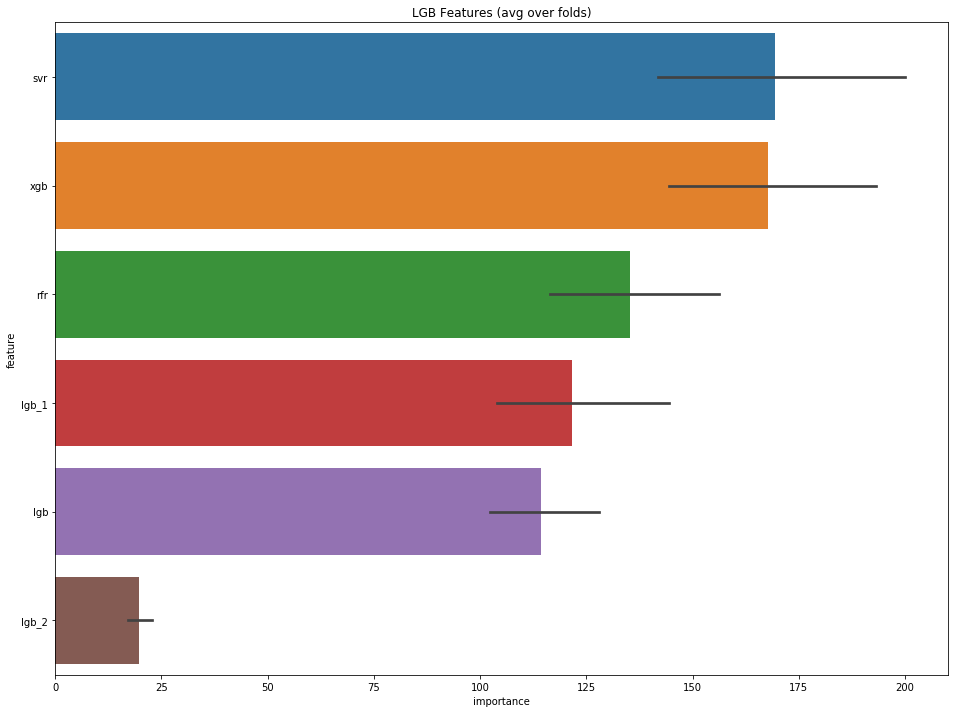

In [54]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:50:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[317]	training's rmse: 0.111234	valid_1's rmse: 0.12176
Fold 1 started at Tue Dec 17 10:50:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[371]	training's rmse: 0.110048	valid_1's rmse: 0.125181
Fold 2 started at Tue Dec 17 10:50:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[361]	training's rmse: 0.110615	valid_1's rmse: 0.119648
Fold 3 started at Tue Dec 17 10:50:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[250]	training's rmse: 0.113015	valid_1's rmse: 0.121078
Fold 4 started at Tue Dec 17 10:50:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[300]	training's rmse: 0.111377	valid_1's rmse: 0.125972
Fold 5 star

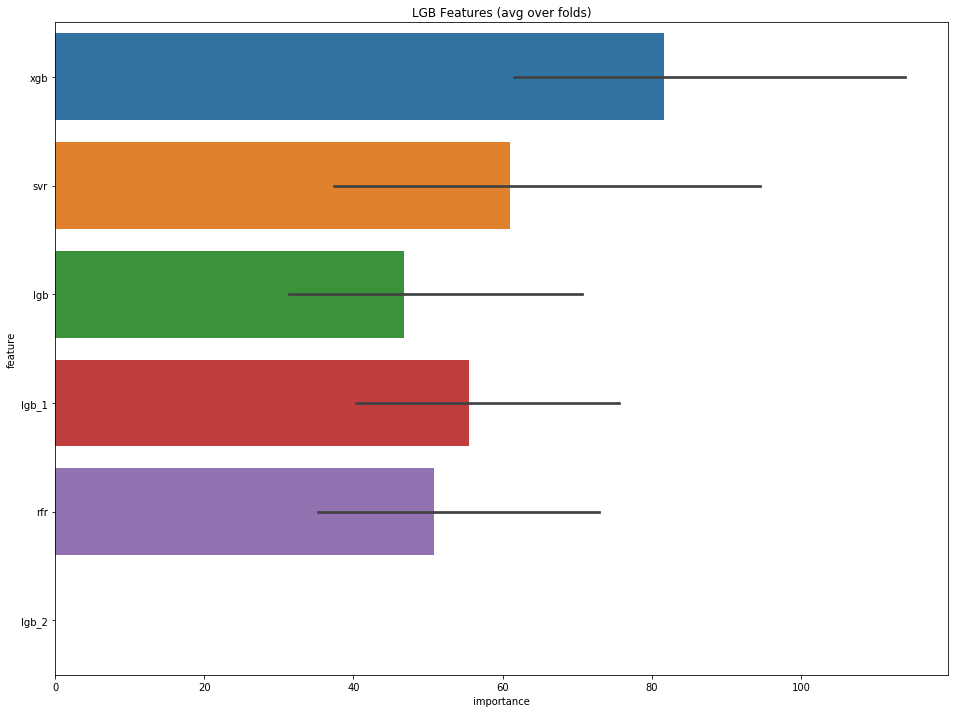

In [55]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [56]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 10:51:19 2019
Fold 1 started at Tue Dec 17 10:51:28 2019
Fold 2 started at Tue Dec 17 10:51:33 2019
Fold 3 started at Tue Dec 17 10:51:56 2019
Fold 4 started at Tue Dec 17 10:52:04 2019
Fold 5 started at Tue Dec 17 10:52:11 2019
Fold 6 started at Tue Dec 17 10:52:21 2019
Fold 7 started at Tue Dec 17 10:52:34 2019
Fold 8 started at Tue Dec 17 10:52:48 2019
Fold 9 started at Tue Dec 17 10:52:55 2019
CV mean score: 0.1177, std: 0.0070.


##### randomforest作为第二层融合模型

In [57]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:53:01 2019
Fold 1 started at Tue Dec 17 10:53:01 2019
Fold 2 started at Tue Dec 17 10:53:01 2019
Fold 3 started at Tue Dec 17 10:53:01 2019
Fold 4 started at Tue Dec 17 10:53:02 2019
Fold 5 started at Tue Dec 17 10:53:02 2019
Fold 6 started at Tue Dec 17 10:53:02 2019
Fold 7 started at Tue Dec 17 10:53:02 2019
Fold 8 started at Tue Dec 17 10:53:03 2019
Fold 9 started at Tue Dec 17 10:53:03 2019
CV mean score: 0.1211, std: 0.0067.


##### xgboost作为第二层融合模型

In [58]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:53:03 2019
[0]	train-rmse:0.482369	valid_data-rmse:0.473635
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.066998	valid_data-rmse:0.130677
Stopping. Best iteration:
[369]	train-rmse:0.074471	valid_data-rmse:0.129572

Fold 1 started at Tue Dec 17 10:53:04 2019
[0]	train-rmse:0.481842	valid_data-rmse:0.478454
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.067235	valid_data-rmse:0.129655
Stopping. Best iteration:
[394]	train-rmse:0.073069	valid_data-rmse:0.12901

Fold 2 started at Tue Dec 17 10:53:05 2019
[0]	train-rmse:0.480834	valid_data-rmse:0.48735
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


##### svr 作为第二层融合模型

In [59]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:53:13 2019
Fold 1 started at Tue Dec 17 10:53:13 2019
Fold 2 started at Tue Dec 17 10:53:14 2019
Fold 3 started at Tue Dec 17 10:53:14 2019
Fold 4 started at Tue Dec 17 10:53:14 2019
Fold 5 started at Tue Dec 17 10:53:14 2019
Fold 6 started at Tue Dec 17 10:53:14 2019
Fold 7 started at Tue Dec 17 10:53:14 2019
Fold 8 started at Tue Dec 17 10:53:14 2019
Fold 9 started at Tue Dec 17 10:53:14 2019
CV mean score: 0.1172, std: 0.0077.


##### 岭回归做第二层融合模型

In [60]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 10:53:14 2019
Fold 1 started at Tue Dec 17 10:53:14 2019
Fold 2 started at Tue Dec 17 10:53:14 2019
Fold 3 started at Tue Dec 17 10:53:14 2019
Fold 4 started at Tue Dec 17 10:53:14 2019
Fold 5 started at Tue Dec 17 10:53:14 2019
Fold 6 started at Tue Dec 17 10:53:14 2019
Fold 7 started at Tue Dec 17 10:53:15 2019
Fold 8 started at Tue Dec 17 10:53:15 2019
Fold 9 started at Tue Dec 17 10:53:15 2019
CV mean score: 0.1171, std: 0.0076.


#### 去掉xgb和lgb的结果

In [61]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:53:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[226]	training's rmse: 0.10781	valid_1's rmse: 0.130494
Fold 1 started at Tue Dec 17 10:53:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[503]	training's rmse: 0.0986176	valid_1's rmse: 0.126112
Fold 2 started at Tue Dec 17 10:53:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[273]	training's rmse: 0.105713	valid_1's rmse: 0.121251
Fold 3 started at Tue Dec 17 10:53:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[388]	training's rmse: 0.102278	valid_1's rmse: 0.113104
Fold 4 started at Tue Dec 17 10:53:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[255]	training's rmse: 0.106293	valid_1's rmse: 0.126339
Fold 5 sta

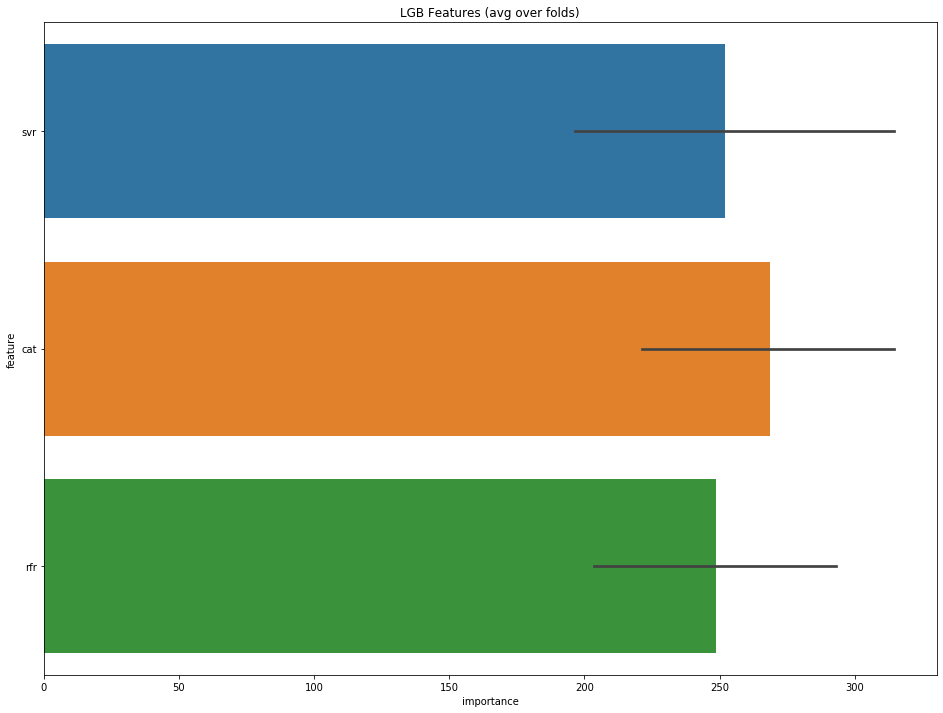

In [62]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:53:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[272]	training's rmse: 0.112226	valid_1's rmse: 0.12404
Fold 1 started at Tue Dec 17 10:53:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[499]	training's rmse: 0.109487	valid_1's rmse: 0.123574
Fold 2 started at Tue Dec 17 10:53:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[321]	training's rmse: 0.111951	valid_1's rmse: 0.118928
Fold 3 started at Tue Dec 17 10:53:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[511]	training's rmse: 0.110352	valid_1's rmse: 0.114782
Fold 4 started at Tue Dec 17 10:53:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[303]	training's rmse: 0.111673	valid_1's rmse: 0.125525
Fold 5 star

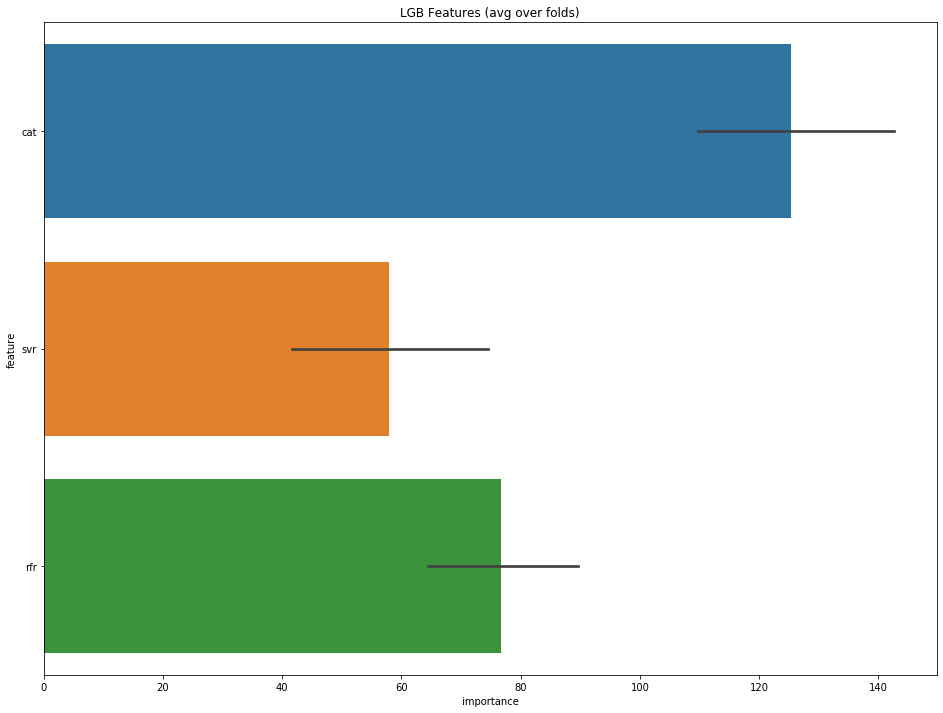

In [63]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [64]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 10:53:34 2019
Fold 1 started at Tue Dec 17 10:53:41 2019
Fold 2 started at Tue Dec 17 10:53:51 2019
Fold 3 started at Tue Dec 17 10:54:04 2019
Fold 4 started at Tue Dec 17 10:54:26 2019
Fold 5 started at Tue Dec 17 10:54:32 2019
Fold 6 started at Tue Dec 17 10:54:43 2019
Fold 7 started at Tue Dec 17 10:54:55 2019
Fold 8 started at Tue Dec 17 10:55:10 2019
Fold 9 started at Tue Dec 17 10:55:19 2019
CV mean score: 0.1177, std: 0.0069.


##### randomforest作为第二层融合模型

In [65]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:55:25 2019
Fold 1 started at Tue Dec 17 10:55:25 2019
Fold 2 started at Tue Dec 17 10:55:25 2019
Fold 3 started at Tue Dec 17 10:55:25 2019
Fold 4 started at Tue Dec 17 10:55:26 2019
Fold 5 started at Tue Dec 17 10:55:26 2019
Fold 6 started at Tue Dec 17 10:55:26 2019
Fold 7 started at Tue Dec 17 10:55:26 2019
Fold 8 started at Tue Dec 17 10:55:27 2019
Fold 9 started at Tue Dec 17 10:55:27 2019
CV mean score: 0.1213, std: 0.0068.


##### xgboost作为第二层融合模型

In [66]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:55:27 2019
[0]	train-rmse:0.48238	valid_data-rmse:0.47361
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.071311	valid_data-rmse:0.134467
Stopping. Best iteration:
[364]	train-rmse:0.078508	valid_data-rmse:0.133807

Fold 1 started at Tue Dec 17 10:55:28 2019
[0]	train-rmse:0.481847	valid_data-rmse:0.478491
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.072881	valid_data-rmse:0.127667
Stopping. Best iteration:
[421]	train-rmse:0.076658	valid_data-rmse:0.12732

Fold 2 started at Tue Dec 17 10:55:28 2019
[0]	train-rmse:0.480851	valid_data-rmse:0.487323
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[

##### svr 作为第二层融合模型

In [67]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:55:34 2019
Fold 1 started at Tue Dec 17 10:55:34 2019
Fold 2 started at Tue Dec 17 10:55:34 2019
Fold 3 started at Tue Dec 17 10:55:34 2019
Fold 4 started at Tue Dec 17 10:55:34 2019
Fold 5 started at Tue Dec 17 10:55:34 2019
Fold 6 started at Tue Dec 17 10:55:34 2019
Fold 7 started at Tue Dec 17 10:55:34 2019
Fold 8 started at Tue Dec 17 10:55:34 2019
Fold 9 started at Tue Dec 17 10:55:34 2019
CV mean score: 0.1174, std: 0.0076.


##### 岭回归做第二层融合模型

In [68]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 10:55:34 2019
Fold 1 started at Tue Dec 17 10:55:34 2019
Fold 2 started at Tue Dec 17 10:55:35 2019
Fold 3 started at Tue Dec 17 10:55:35 2019
Fold 4 started at Tue Dec 17 10:55:35 2019
Fold 5 started at Tue Dec 17 10:55:35 2019
Fold 6 started at Tue Dec 17 10:55:35 2019
Fold 7 started at Tue Dec 17 10:55:35 2019
Fold 8 started at Tue Dec 17 10:55:35 2019
Fold 9 started at Tue Dec 17 10:55:35 2019
CV mean score: 0.1173, std: 0.0076.


#### 去掉lgb和svr的结果

In [69]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat, oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'cat','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:55:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[243]	training's rmse: 0.106499	valid_1's rmse: 0.128001
Fold 1 started at Tue Dec 17 10:55:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[291]	training's rmse: 0.104958	valid_1's rmse: 0.123708
Fold 2 started at Tue Dec 17 10:55:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 0.106919	valid_1's rmse: 0.119463
Fold 3 started at Tue Dec 17 10:55:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[302]	training's rmse: 0.105365	valid_1's rmse: 0.115994
Fold 4 started at Tue Dec 17 10:56:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[268]	training's rmse: 0.106042	valid_1's rmse: 0.123505
Fold 5 sta

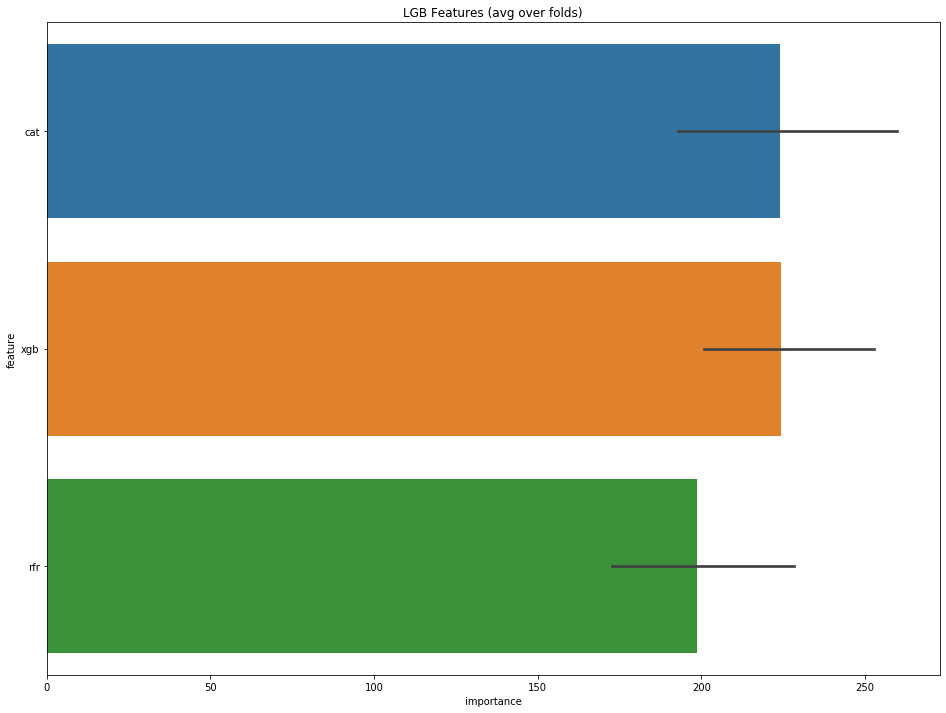

In [70]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 10:56:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[299]	training's rmse: 0.11024	valid_1's rmse: 0.122162
Fold 1 started at Tue Dec 17 10:56:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[464]	training's rmse: 0.108862	valid_1's rmse: 0.120921
Fold 2 started at Tue Dec 17 10:56:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[302]	training's rmse: 0.110712	valid_1's rmse: 0.117387
Fold 3 started at Tue Dec 17 10:56:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[754]	training's rmse: 0.108042	valid_1's rmse: 0.115509
Fold 4 started at Tue Dec 17 10:56:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[292]	training's rmse: 0.110571	valid_1's rmse: 0.123351
Fold 5 star

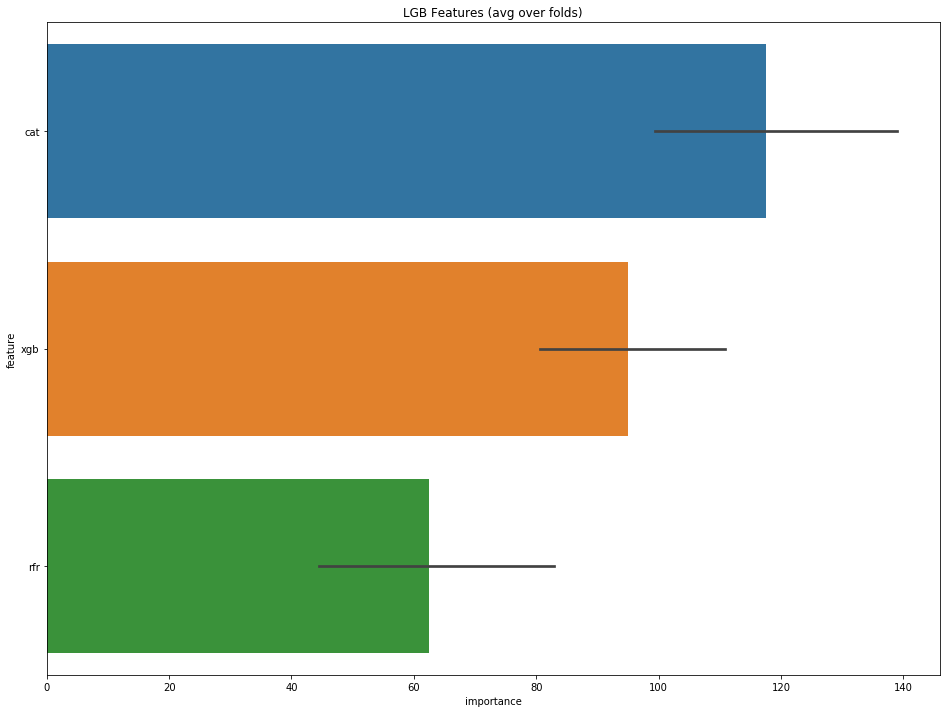

In [71]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [72]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 10:57:11 2019
Fold 1 started at Tue Dec 17 10:57:19 2019
Fold 2 started at Tue Dec 17 10:57:28 2019
Fold 3 started at Tue Dec 17 10:57:43 2019
Fold 4 started at Tue Dec 17 10:57:53 2019
Fold 5 started at Tue Dec 17 10:58:03 2019
Fold 6 started at Tue Dec 17 10:58:27 2019
Fold 7 started at Tue Dec 17 10:58:44 2019
Fold 8 started at Tue Dec 17 10:59:02 2019
Fold 9 started at Tue Dec 17 10:59:08 2019
CV mean score: 0.1163, std: 0.0074.


##### randomforest作为第二层融合模型

In [73]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 10:59:15 2019
Fold 1 started at Tue Dec 17 10:59:15 2019
Fold 2 started at Tue Dec 17 10:59:16 2019
Fold 3 started at Tue Dec 17 10:59:16 2019
Fold 4 started at Tue Dec 17 10:59:16 2019
Fold 5 started at Tue Dec 17 10:59:16 2019
Fold 6 started at Tue Dec 17 10:59:16 2019
Fold 7 started at Tue Dec 17 10:59:17 2019
Fold 8 started at Tue Dec 17 10:59:17 2019
Fold 9 started at Tue Dec 17 10:59:17 2019
CV mean score: 0.1199, std: 0.0078.


##### xgboost作为第二层融合模型

In [74]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 10:59:17 2019
[0]	train-rmse:0.482361	valid_data-rmse:0.473587
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.072139	valid_data-rmse:0.131146
Stopping. Best iteration:
[360]	train-rmse:0.079749	valid_data-rmse:0.130095

Fold 1 started at Tue Dec 17 10:59:18 2019
[0]	train-rmse:0.481842	valid_data-rmse:0.478479
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.074167	valid_data-rmse:0.128306
Stopping. Best iteration:
[391]	train-rmse:0.079628	valid_data-rmse:0.127313

Fold 2 started at Tue Dec 17 10:59:19 2019
[0]	train-rmse:0.480852	valid_data-rmse:0.487329
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds

##### svr 作为第二层融合模型

In [75]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:59:25 2019
Fold 1 started at Tue Dec 17 10:59:25 2019
Fold 2 started at Tue Dec 17 10:59:25 2019
Fold 3 started at Tue Dec 17 10:59:25 2019
Fold 4 started at Tue Dec 17 10:59:25 2019
Fold 5 started at Tue Dec 17 10:59:25 2019
Fold 6 started at Tue Dec 17 10:59:25 2019
Fold 7 started at Tue Dec 17 10:59:25 2019
Fold 8 started at Tue Dec 17 10:59:25 2019
Fold 9 started at Tue Dec 17 10:59:25 2019
CV mean score: 0.1168, std: 0.0075.


##### 岭回归做第二层融合模型

In [76]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 10:59:25 2019
Fold 1 started at Tue Dec 17 10:59:25 2019
Fold 2 started at Tue Dec 17 10:59:25 2019
Fold 3 started at Tue Dec 17 10:59:25 2019
Fold 4 started at Tue Dec 17 10:59:25 2019
Fold 5 started at Tue Dec 17 10:59:25 2019
Fold 6 started at Tue Dec 17 10:59:26 2019
Fold 7 started at Tue Dec 17 10:59:26 2019
Fold 8 started at Tue Dec 17 10:59:26 2019
Fold 9 started at Tue Dec 17 10:59:26 2019
CV mean score: 0.1168, std: 0.0076.


#### 去掉lgb和rfr的结果

In [77]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat, oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'cat', 'svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 10:59:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[262]	training's rmse: 0.104233	valid_1's rmse: 0.126517
Fold 1 started at Tue Dec 17 10:59:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[576]	training's rmse: 0.0957046	valid_1's rmse: 0.121935
Fold 2 started at Tue Dec 17 10:59:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 0.105622	valid_1's rmse: 0.117723
Fold 3 started at Tue Dec 17 10:59:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[297]	training's rmse: 0.103657	valid_1's rmse: 0.116352
Fold 4 started at Tue Dec 17 10:59:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[305]	training's rmse: 0.102815	valid_1's rmse: 0.122319
Fold 5 st

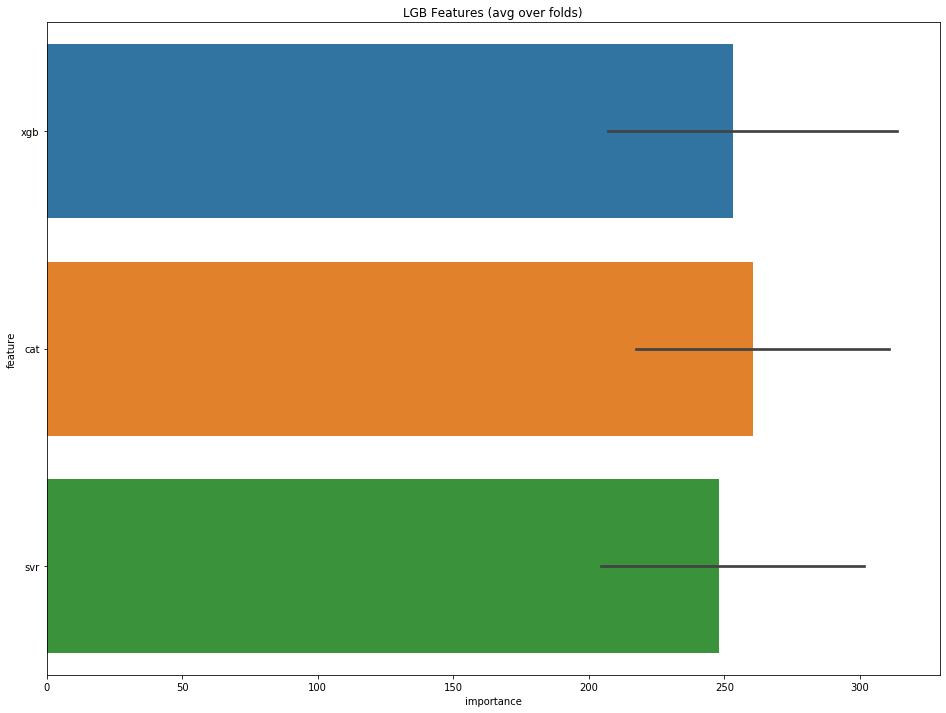

In [78]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:01:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[295]	training's rmse: 0.110571	valid_1's rmse: 0.122478
Fold 1 started at Tue Dec 17 11:01:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[468]	training's rmse: 0.108536	valid_1's rmse: 0.12078
Fold 2 started at Tue Dec 17 11:01:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[359]	training's rmse: 0.109912	valid_1's rmse: 0.116533
Fold 3 started at Tue Dec 17 11:01:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[321]	training's rmse: 0.110992	valid_1's rmse: 0.116237
Fold 4 started at Tue Dec 17 11:01:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[263]	training's rmse: 0.111689	valid_1's rmse: 0.122622
Fold 5 star

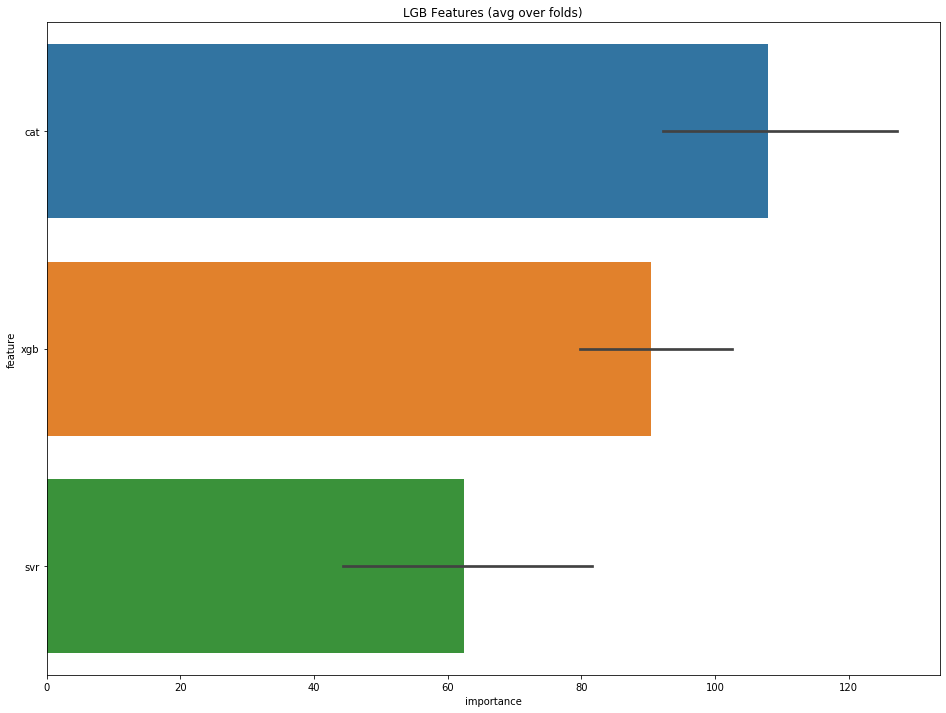

In [79]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [80]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:01:42 2019
Fold 1 started at Tue Dec 17 11:01:55 2019
Fold 2 started at Tue Dec 17 11:02:11 2019
Fold 3 started at Tue Dec 17 11:02:23 2019
Fold 4 started at Tue Dec 17 11:02:43 2019
Fold 5 started at Tue Dec 17 11:02:52 2019
Fold 6 started at Tue Dec 17 11:03:24 2019
Fold 7 started at Tue Dec 17 11:03:41 2019
Fold 8 started at Tue Dec 17 11:04:04 2019
Fold 9 started at Tue Dec 17 11:04:17 2019
CV mean score: 0.1165, std: 0.0072.


##### randomforest作为第二层融合模型

In [81]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:04:31 2019
Fold 1 started at Tue Dec 17 11:04:31 2019
Fold 2 started at Tue Dec 17 11:04:31 2019
Fold 3 started at Tue Dec 17 11:04:31 2019
Fold 4 started at Tue Dec 17 11:04:31 2019
Fold 5 started at Tue Dec 17 11:04:32 2019
Fold 6 started at Tue Dec 17 11:04:32 2019
Fold 7 started at Tue Dec 17 11:04:32 2019
Fold 8 started at Tue Dec 17 11:04:32 2019
Fold 9 started at Tue Dec 17 11:04:33 2019
CV mean score: 0.1184, std: 0.0058.


##### xgboost作为第二层融合模型

In [82]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:04:33 2019
[0]	train-rmse:0.48236	valid_data-rmse:0.473743
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.070258	valid_data-rmse:0.127579
Stopping. Best iteration:
[409]	train-rmse:0.074663	valid_data-rmse:0.127039

Fold 1 started at Tue Dec 17 11:04:34 2019
[0]	train-rmse:0.481843	valid_data-rmse:0.478501
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.071186	valid_data-rmse:0.122545
Stopping. Best iteration:
[511]	train-rmse:0.070692	valid_data-rmse:0.122436

Fold 2 started at Tue Dec 17 11:04:34 2019
[0]	train-rmse:0.480864	valid_data-rmse:0.487371
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

##### svr 作为第二层融合模型

In [83]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:04:40 2019
Fold 1 started at Tue Dec 17 11:04:40 2019
Fold 2 started at Tue Dec 17 11:04:40 2019
Fold 3 started at Tue Dec 17 11:04:40 2019
Fold 4 started at Tue Dec 17 11:04:40 2019
Fold 5 started at Tue Dec 17 11:04:40 2019
Fold 6 started at Tue Dec 17 11:04:40 2019
Fold 7 started at Tue Dec 17 11:04:40 2019
Fold 8 started at Tue Dec 17 11:04:41 2019
Fold 9 started at Tue Dec 17 11:04:41 2019
CV mean score: 0.1169, std: 0.0078.


##### 岭回归做第二层融合模型

In [84]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:04:41 2019
Fold 1 started at Tue Dec 17 11:04:41 2019
Fold 2 started at Tue Dec 17 11:04:41 2019
Fold 3 started at Tue Dec 17 11:04:41 2019
Fold 4 started at Tue Dec 17 11:04:41 2019
Fold 5 started at Tue Dec 17 11:04:41 2019
Fold 6 started at Tue Dec 17 11:04:41 2019
Fold 7 started at Tue Dec 17 11:04:41 2019
Fold 8 started at Tue Dec 17 11:04:41 2019
Fold 9 started at Tue Dec 17 11:04:42 2019
CV mean score: 0.1169, std: 0.0077.


#### 去掉lgb和cat的结果

In [85]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:04:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[311]	training's rmse: 0.104997	valid_1's rmse: 0.124104
Fold 1 started at Tue Dec 17 11:04:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[310]	training's rmse: 0.104075	valid_1's rmse: 0.129614
Fold 2 started at Tue Dec 17 11:04:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[365]	training's rmse: 0.103682	valid_1's rmse: 0.119325
Fold 3 started at Tue Dec 17 11:05:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[268]	training's rmse: 0.107592	valid_1's rmse: 0.118927
Fold 4 started at Tue Dec 17 11:05:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[231]	training's rmse: 0.108783	valid_1's rmse: 0.128702
Fold 5 sta

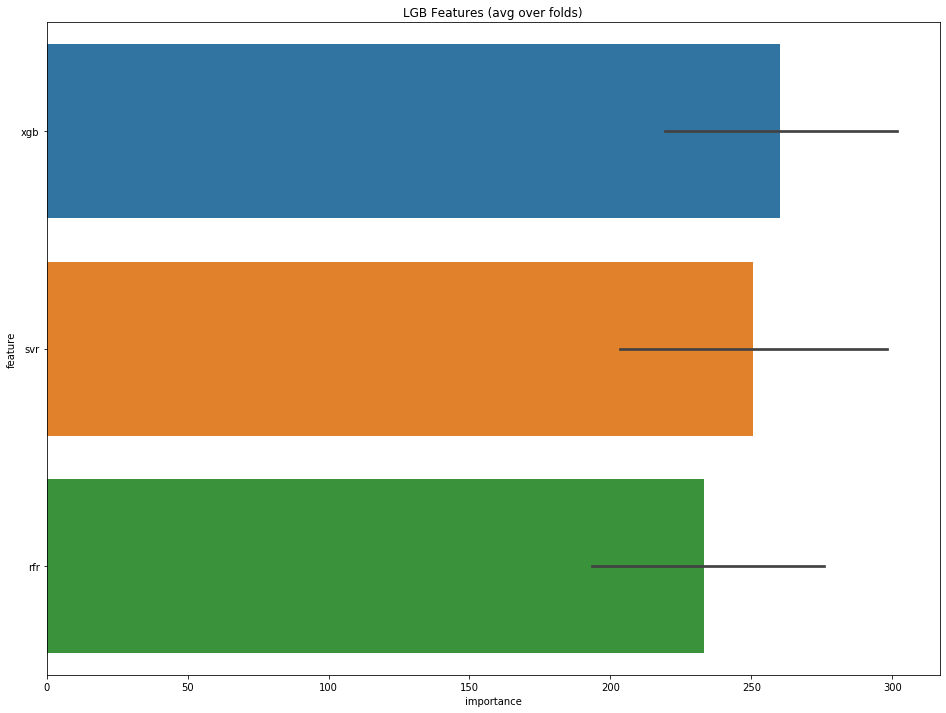

In [86]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:05:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[286]	training's rmse: 0.112967	valid_1's rmse: 0.122048
Fold 1 started at Tue Dec 17 11:05:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[322]	training's rmse: 0.112082	valid_1's rmse: 0.125507
Fold 2 started at Tue Dec 17 11:05:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[324]	training's rmse: 0.112795	valid_1's rmse: 0.118561
Fold 3 started at Tue Dec 17 11:05:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	training's rmse: 0.113802	valid_1's rmse: 0.119602
Fold 4 started at Tue Dec 17 11:05:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[292]	training's rmse: 0.112609	valid_1's rmse: 0.126924
Fold 5 sta

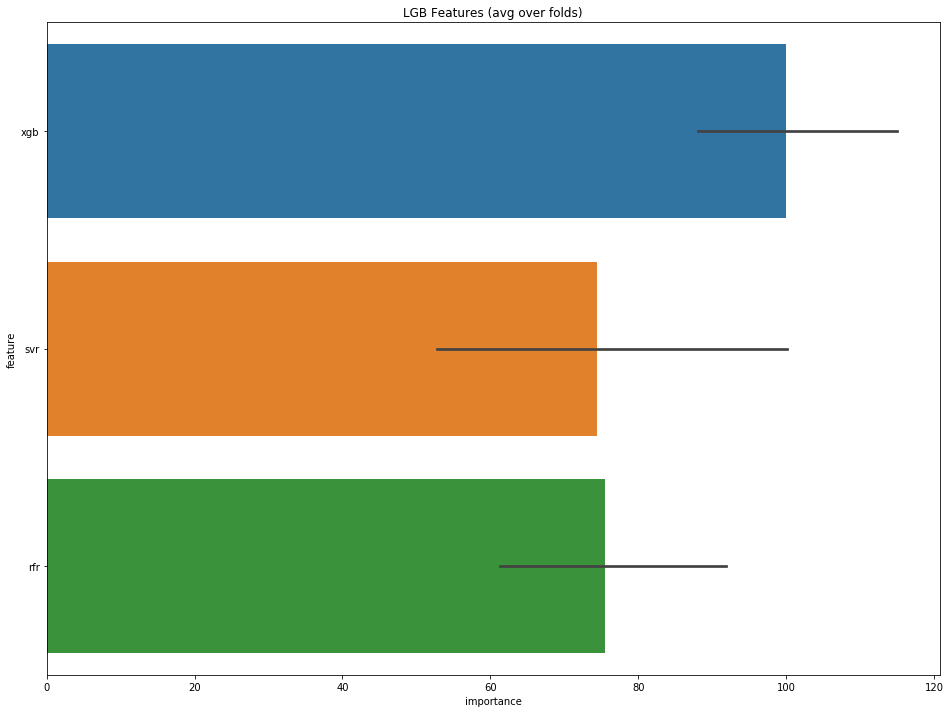

In [87]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [88]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:05:58 2019
Fold 1 started at Tue Dec 17 11:06:13 2019
Fold 2 started at Tue Dec 17 11:06:26 2019
Fold 3 started at Tue Dec 17 11:06:47 2019
Fold 4 started at Tue Dec 17 11:06:55 2019
Fold 5 started at Tue Dec 17 11:07:04 2019
Fold 6 started at Tue Dec 17 11:07:17 2019
Fold 7 started at Tue Dec 17 11:07:35 2019
Fold 8 started at Tue Dec 17 11:07:52 2019
Fold 9 started at Tue Dec 17 11:08:03 2019
CV mean score: 0.1183, std: 0.0063.


##### randomforest作为第二层融合模型

In [89]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:08:10 2019
Fold 1 started at Tue Dec 17 11:08:11 2019
Fold 2 started at Tue Dec 17 11:08:11 2019
Fold 3 started at Tue Dec 17 11:08:11 2019
Fold 4 started at Tue Dec 17 11:08:11 2019
Fold 5 started at Tue Dec 17 11:08:11 2019
Fold 6 started at Tue Dec 17 11:08:12 2019
Fold 7 started at Tue Dec 17 11:08:12 2019
Fold 8 started at Tue Dec 17 11:08:12 2019
Fold 9 started at Tue Dec 17 11:08:12 2019
CV mean score: 0.1218, std: 0.0071.


##### xgboost作为第二层融合模型

In [90]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:08:13 2019
[0]	train-rmse:0.48238	valid_data-rmse:0.47361
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.073654	valid_data-rmse:0.125505
Stopping. Best iteration:
[369]	train-rmse:0.080943	valid_data-rmse:0.124901

Fold 1 started at Tue Dec 17 11:08:13 2019
[0]	train-rmse:0.481847	valid_data-rmse:0.478491
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.073044	valid_data-rmse:0.133929
Stopping. Best iteration:
[339]	train-rmse:0.083102	valid_data-rmse:0.132484

Fold 2 started at Tue Dec 17 11:08:14 2019
[0]	train-rmse:0.480851	valid_data-rmse:0.487323
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


##### svr 作为第二层融合模型

In [91]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:08:20 2019
Fold 1 started at Tue Dec 17 11:08:20 2019
Fold 2 started at Tue Dec 17 11:08:20 2019
Fold 3 started at Tue Dec 17 11:08:20 2019
Fold 4 started at Tue Dec 17 11:08:20 2019
Fold 5 started at Tue Dec 17 11:08:20 2019
Fold 6 started at Tue Dec 17 11:08:20 2019
Fold 7 started at Tue Dec 17 11:08:20 2019
Fold 8 started at Tue Dec 17 11:08:20 2019
Fold 9 started at Tue Dec 17 11:08:20 2019
CV mean score: 0.1179, std: 0.0073.


##### 岭回归做第二层融合模型

In [92]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:08:20 2019
Fold 1 started at Tue Dec 17 11:08:20 2019
Fold 2 started at Tue Dec 17 11:08:21 2019
Fold 3 started at Tue Dec 17 11:08:21 2019
Fold 4 started at Tue Dec 17 11:08:21 2019
Fold 5 started at Tue Dec 17 11:08:21 2019
Fold 6 started at Tue Dec 17 11:08:21 2019
Fold 7 started at Tue Dec 17 11:08:21 2019
Fold 8 started at Tue Dec 17 11:08:21 2019
Fold 9 started at Tue Dec 17 11:08:21 2019
CV mean score: 0.1179, std: 0.0071.


#### 去掉xgb和svr

In [93]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:08:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[236]	training's rmse: 0.106214	valid_1's rmse: 0.129541
Fold 1 started at Tue Dec 17 11:08:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[317]	training's rmse: 0.103318	valid_1's rmse: 0.125711
Fold 2 started at Tue Dec 17 11:08:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[259]	training's rmse: 0.105829	valid_1's rmse: 0.12277
Fold 3 started at Tue Dec 17 11:08:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[229]	training's rmse: 0.107788	valid_1's rmse: 0.122239
Fold 4 started at Tue Dec 17 11:08:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[265]	training's rmse: 0.105408	valid_1's rmse: 0.125046
Fold 5 star

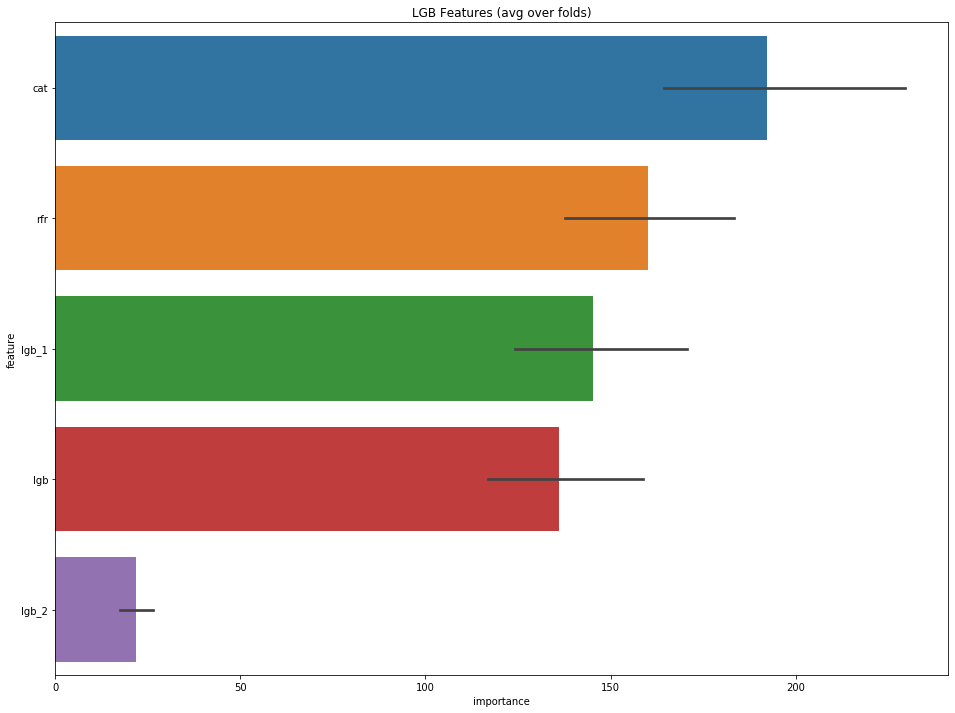

In [94]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:09:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[283]	training's rmse: 0.111477	valid_1's rmse: 0.124439
Fold 1 started at Tue Dec 17 11:10:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[355]	training's rmse: 0.11047	valid_1's rmse: 0.123079
Fold 2 started at Tue Dec 17 11:10:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[348]	training's rmse: 0.110856	valid_1's rmse: 0.120458
Fold 3 started at Tue Dec 17 11:10:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[286]	training's rmse: 0.11218	valid_1's rmse: 0.118837
Fold 4 started at Tue Dec 17 11:10:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[361]	training's rmse: 0.110239	valid_1's rmse: 0.124583
Fold 5 start

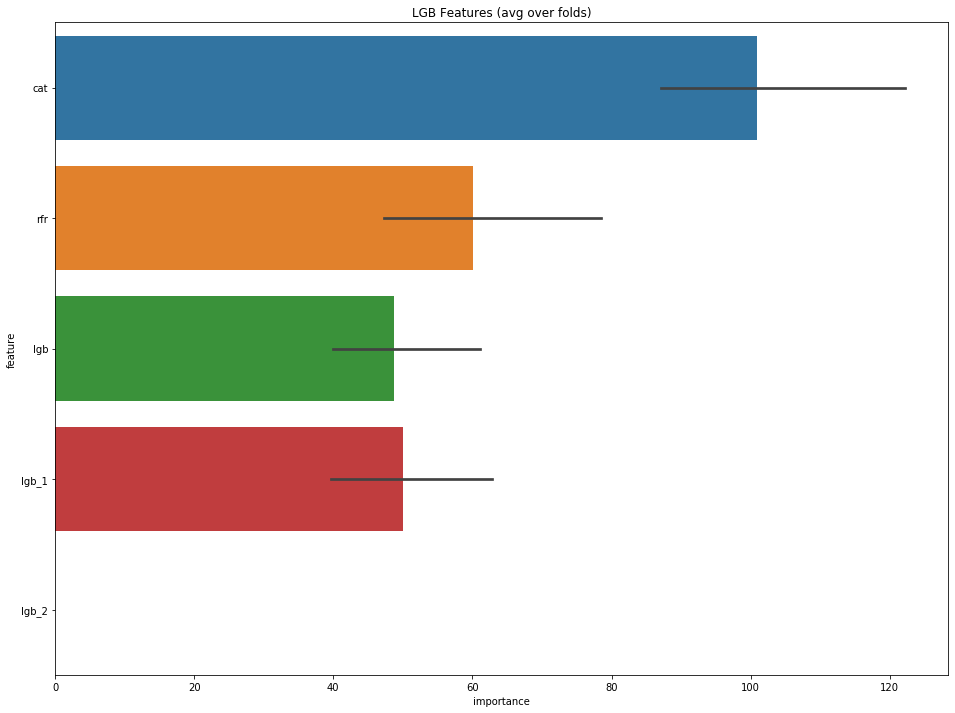

In [95]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [96]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:10:41 2019
Fold 1 started at Tue Dec 17 11:10:54 2019
Fold 2 started at Tue Dec 17 11:11:06 2019
Fold 3 started at Tue Dec 17 11:11:20 2019
Fold 4 started at Tue Dec 17 11:11:31 2019
Fold 5 started at Tue Dec 17 11:11:42 2019
Fold 6 started at Tue Dec 17 11:11:55 2019
Fold 7 started at Tue Dec 17 11:12:16 2019
Fold 8 started at Tue Dec 17 11:12:40 2019
Fold 9 started at Tue Dec 17 11:12:52 2019
CV mean score: 0.1172, std: 0.0076.


##### randomforest作为第二层融合模型

In [97]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:13:01 2019
Fold 1 started at Tue Dec 17 11:13:01 2019
Fold 2 started at Tue Dec 17 11:13:01 2019
Fold 3 started at Tue Dec 17 11:13:01 2019
Fold 4 started at Tue Dec 17 11:13:02 2019
Fold 5 started at Tue Dec 17 11:13:02 2019
Fold 6 started at Tue Dec 17 11:13:02 2019
Fold 7 started at Tue Dec 17 11:13:02 2019
Fold 8 started at Tue Dec 17 11:13:02 2019
Fold 9 started at Tue Dec 17 11:13:03 2019
CV mean score: 0.1210, std: 0.0067.


##### xgboost作为第二层融合模型

In [98]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:13:03 2019
[0]	train-rmse:0.482367	valid_data-rmse:0.473658
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.070782	valid_data-rmse:0.136197
Stopping. Best iteration:
[365]	train-rmse:0.077904	valid_data-rmse:0.134726

Fold 1 started at Tue Dec 17 11:13:04 2019
[0]	train-rmse:0.481843	valid_data-rmse:0.478451
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.072038	valid_data-rmse:0.127874
Stopping. Best iteration:
[412]	train-rmse:0.076283	valid_data-rmse:0.12776

Fold 2 started at Tue Dec 17 11:13:05 2019
[0]	train-rmse:0.48085	valid_data-rmse:0.487371
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


##### svr 作为第二层融合模型

In [99]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:13:12 2019
Fold 1 started at Tue Dec 17 11:13:12 2019
Fold 2 started at Tue Dec 17 11:13:13 2019
Fold 3 started at Tue Dec 17 11:13:13 2019
Fold 4 started at Tue Dec 17 11:13:13 2019
Fold 5 started at Tue Dec 17 11:13:13 2019
Fold 6 started at Tue Dec 17 11:13:13 2019
Fold 7 started at Tue Dec 17 11:13:13 2019
Fold 8 started at Tue Dec 17 11:13:13 2019
Fold 9 started at Tue Dec 17 11:13:13 2019
CV mean score: 0.1169, std: 0.0077.


##### 岭回归做第二层融合模型

In [100]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:13:13 2019
Fold 1 started at Tue Dec 17 11:13:13 2019
Fold 2 started at Tue Dec 17 11:13:13 2019
Fold 3 started at Tue Dec 17 11:13:13 2019
Fold 4 started at Tue Dec 17 11:13:13 2019
Fold 5 started at Tue Dec 17 11:13:13 2019
Fold 6 started at Tue Dec 17 11:13:14 2019
Fold 7 started at Tue Dec 17 11:13:14 2019
Fold 8 started at Tue Dec 17 11:13:14 2019
Fold 9 started at Tue Dec 17 11:13:14 2019
CV mean score: 0.1167, std: 0.0077.


#### 去掉xgb和rfr

In [101]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:13:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[260]	training's rmse: 0.103278	valid_1's rmse: 0.129183
Fold 1 started at Tue Dec 17 11:13:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[596]	training's rmse: 0.0938567	valid_1's rmse: 0.122627
Fold 2 started at Tue Dec 17 11:13:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[273]	training's rmse: 0.103757	valid_1's rmse: 0.121088
Fold 3 started at Tue Dec 17 11:13:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[228]	training's rmse: 0.106621	valid_1's rmse: 0.12059
Fold 4 started at Tue Dec 17 11:14:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[296]	training's rmse: 0.102745	valid_1's rmse: 0.12246
Fold 5 star

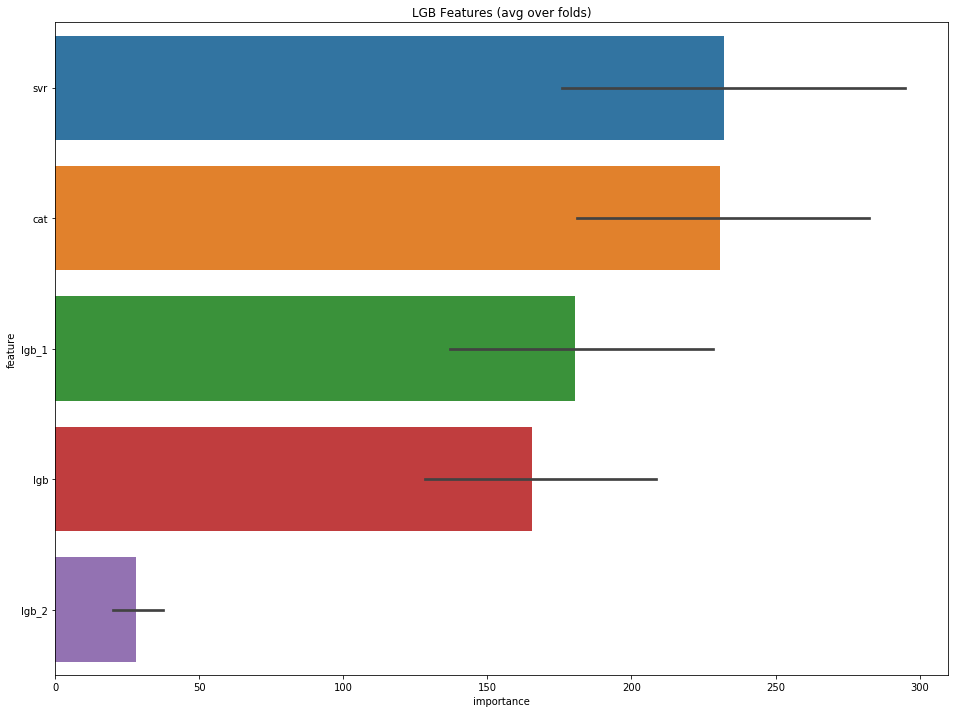

In [102]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:15:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[286]	training's rmse: 0.111146	valid_1's rmse: 0.125201
Fold 1 started at Tue Dec 17 11:15:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[485]	training's rmse: 0.108944	valid_1's rmse: 0.122805
Fold 2 started at Tue Dec 17 11:15:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[444]	training's rmse: 0.109874	valid_1's rmse: 0.11936
Fold 3 started at Tue Dec 17 11:15:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[268]	training's rmse: 0.112941	valid_1's rmse: 0.118694
Fold 4 started at Tue Dec 17 11:15:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[326]	training's rmse: 0.110994	valid_1's rmse: 0.123952
Fold 5 star

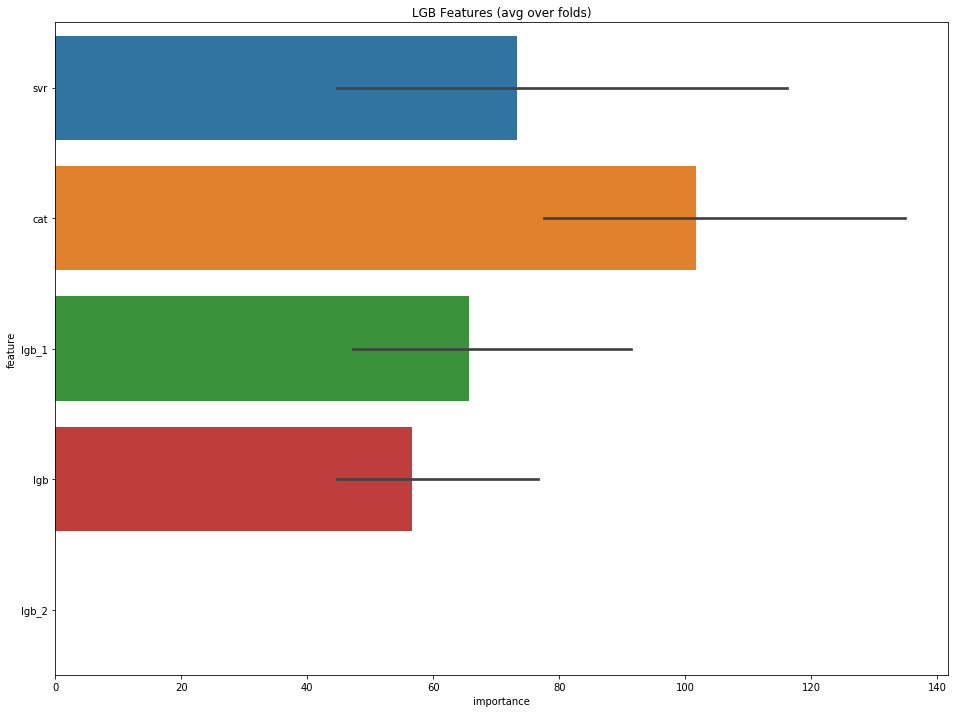

In [103]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [104]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:15:45 2019
Fold 1 started at Tue Dec 17 11:15:57 2019
Fold 2 started at Tue Dec 17 11:16:11 2019
Fold 3 started at Tue Dec 17 11:16:26 2019
Fold 4 started at Tue Dec 17 11:16:36 2019
Fold 5 started at Tue Dec 17 11:16:46 2019
Fold 6 started at Tue Dec 17 11:17:00 2019
Fold 7 started at Tue Dec 17 11:17:21 2019
Fold 8 started at Tue Dec 17 11:17:38 2019
Fold 9 started at Tue Dec 17 11:17:52 2019
CV mean score: 0.1177, std: 0.0074.


##### randomforest作为第二层融合模型

In [105]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:18:01 2019
Fold 1 started at Tue Dec 17 11:18:01 2019
Fold 2 started at Tue Dec 17 11:18:01 2019
Fold 3 started at Tue Dec 17 11:18:02 2019
Fold 4 started at Tue Dec 17 11:18:02 2019
Fold 5 started at Tue Dec 17 11:18:02 2019
Fold 6 started at Tue Dec 17 11:18:02 2019
Fold 7 started at Tue Dec 17 11:18:03 2019
Fold 8 started at Tue Dec 17 11:18:03 2019
Fold 9 started at Tue Dec 17 11:18:03 2019
CV mean score: 0.1200, std: 0.0055.


##### xgboost作为第二层融合模型

In [106]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:18:03 2019
[0]	train-rmse:0.482367	valid_data-rmse:0.473658
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.067981	valid_data-rmse:0.135849
Stopping. Best iteration:
[377]	train-rmse:0.074431	valid_data-rmse:0.134938

Fold 1 started at Tue Dec 17 11:18:04 2019
[0]	train-rmse:0.481843	valid_data-rmse:0.478451
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.069747	valid_data-rmse:0.121746
Stopping. Best iteration:
[769]	train-rmse:0.059512	valid_data-rmse:0.121056

Fold 2 started at Tue Dec 17 11:18:06 2019
[0]	train-rmse:0.48085	valid_data-rmse:0.487371
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

##### svr 作为第二层融合模型

In [107]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:18:14 2019
Fold 1 started at Tue Dec 17 11:18:14 2019
Fold 2 started at Tue Dec 17 11:18:14 2019
Fold 3 started at Tue Dec 17 11:18:14 2019
Fold 4 started at Tue Dec 17 11:18:14 2019
Fold 5 started at Tue Dec 17 11:18:14 2019
Fold 6 started at Tue Dec 17 11:18:14 2019
Fold 7 started at Tue Dec 17 11:18:14 2019
Fold 8 started at Tue Dec 17 11:18:14 2019
Fold 9 started at Tue Dec 17 11:18:14 2019
CV mean score: 0.1170, std: 0.0080.


##### 岭回归做第二层融合模型

In [108]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:18:14 2019
Fold 1 started at Tue Dec 17 11:18:14 2019
Fold 2 started at Tue Dec 17 11:18:14 2019
Fold 3 started at Tue Dec 17 11:18:14 2019
Fold 4 started at Tue Dec 17 11:18:15 2019
Fold 5 started at Tue Dec 17 11:18:15 2019
Fold 6 started at Tue Dec 17 11:18:15 2019
Fold 7 started at Tue Dec 17 11:18:15 2019
Fold 8 started at Tue Dec 17 11:18:15 2019
Fold 9 started at Tue Dec 17 11:18:15 2019
CV mean score: 0.1170, std: 0.0080.


#### 去掉xgb和cat

In [109]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:18:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[258]	training's rmse: 0.104938	valid_1's rmse: 0.126797
Fold 1 started at Tue Dec 17 11:18:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[292]	training's rmse: 0.103428	valid_1's rmse: 0.128704
Fold 2 started at Tue Dec 17 11:18:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[359]	training's rmse: 0.101317	valid_1's rmse: 0.122539
Fold 3 started at Tue Dec 17 11:18:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[237]	training's rmse: 0.106565	valid_1's rmse: 0.124557
Fold 4 started at Tue Dec 17 11:18:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[261]	training's rmse: 0.105061	valid_1's rmse: 0.127588
Fold 5 sta

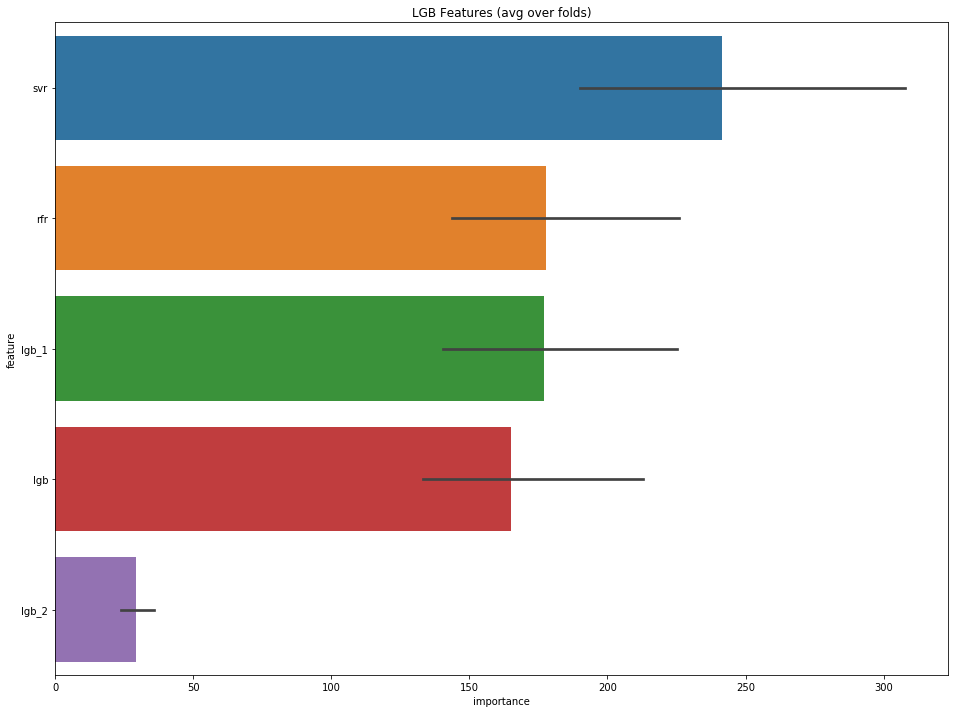

In [110]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:20:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[264]	training's rmse: 0.113678	valid_1's rmse: 0.122755
Fold 1 started at Tue Dec 17 11:20:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[294]	training's rmse: 0.112906	valid_1's rmse: 0.1276
Fold 2 started at Tue Dec 17 11:20:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[440]	training's rmse: 0.110953	valid_1's rmse: 0.122015
Fold 3 started at Tue Dec 17 11:20:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[257]	training's rmse: 0.113696	valid_1's rmse: 0.121745
Fold 4 started at Tue Dec 17 11:20:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[368]	training's rmse: 0.111201	valid_1's rmse: 0.12713
Fold 5 starte

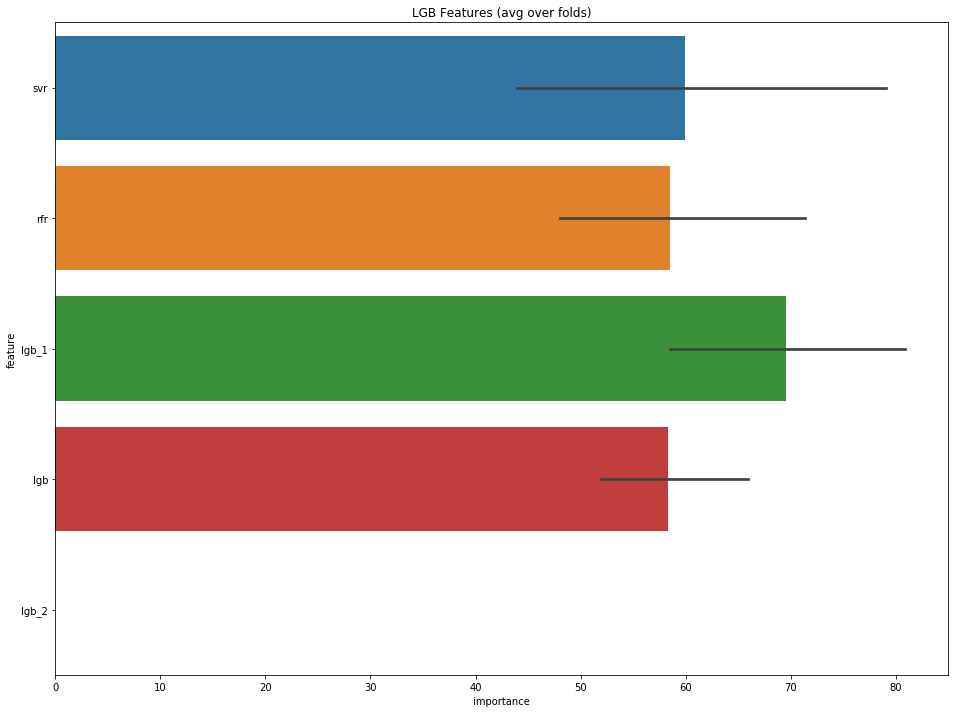

In [111]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [112]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:20:31 2019
Fold 1 started at Tue Dec 17 11:20:46 2019
Fold 2 started at Tue Dec 17 11:20:58 2019
Fold 3 started at Tue Dec 17 11:21:16 2019
Fold 4 started at Tue Dec 17 11:21:26 2019
Fold 5 started at Tue Dec 17 11:21:35 2019
Fold 6 started at Tue Dec 17 11:21:47 2019
Fold 7 started at Tue Dec 17 11:22:05 2019
Fold 8 started at Tue Dec 17 11:22:20 2019
Fold 9 started at Tue Dec 17 11:22:33 2019
CV mean score: 0.1184, std: 0.0071.


##### randomforest作为第二层融合模型

In [113]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:22:43 2019
Fold 1 started at Tue Dec 17 11:22:43 2019
Fold 2 started at Tue Dec 17 11:22:43 2019
Fold 3 started at Tue Dec 17 11:22:43 2019
Fold 4 started at Tue Dec 17 11:22:44 2019
Fold 5 started at Tue Dec 17 11:22:44 2019
Fold 6 started at Tue Dec 17 11:22:44 2019
Fold 7 started at Tue Dec 17 11:22:44 2019
Fold 8 started at Tue Dec 17 11:22:45 2019
Fold 9 started at Tue Dec 17 11:22:45 2019
CV mean score: 0.1223, std: 0.0067.


##### xgboost作为第二层融合模型

In [114]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:22:45 2019
[0]	train-rmse:0.482369	valid_data-rmse:0.473675
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.070287	valid_data-rmse:0.134177
Stopping. Best iteration:
[394]	train-rmse:0.075695	valid_data-rmse:0.1335

Fold 1 started at Tue Dec 17 11:22:46 2019
[0]	train-rmse:0.481846	valid_data-rmse:0.478495
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.070293	valid_data-rmse:0.132997
Stopping. Best iteration:
[389]	train-rmse:0.076293	valid_data-rmse:0.132583

Fold 2 started at Tue Dec 17 11:22:47 2019
[0]	train-rmse:0.480854	valid_data-rmse:0.487356
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


##### svr 作为第二层融合模型

In [115]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:22:55 2019
Fold 1 started at Tue Dec 17 11:22:55 2019
Fold 2 started at Tue Dec 17 11:22:55 2019
Fold 3 started at Tue Dec 17 11:22:55 2019
Fold 4 started at Tue Dec 17 11:22:55 2019
Fold 5 started at Tue Dec 17 11:22:55 2019
Fold 6 started at Tue Dec 17 11:22:55 2019
Fold 7 started at Tue Dec 17 11:22:55 2019
Fold 8 started at Tue Dec 17 11:22:55 2019
Fold 9 started at Tue Dec 17 11:22:55 2019
CV mean score: 0.1174, std: 0.0077.


##### 岭回归做第二层融合模型

In [116]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:22:55 2019
Fold 1 started at Tue Dec 17 11:22:56 2019
Fold 2 started at Tue Dec 17 11:22:56 2019
Fold 3 started at Tue Dec 17 11:22:56 2019
Fold 4 started at Tue Dec 17 11:22:56 2019
Fold 5 started at Tue Dec 17 11:22:56 2019
Fold 6 started at Tue Dec 17 11:22:56 2019
Fold 7 started at Tue Dec 17 11:22:56 2019
Fold 8 started at Tue Dec 17 11:22:56 2019
Fold 9 started at Tue Dec 17 11:22:56 2019
CV mean score: 0.1173, std: 0.0076.


#### 去掉svr和rfr

In [117]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:22:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[243]	training's rmse: 0.104936	valid_1's rmse: 0.128521
Fold 1 started at Tue Dec 17 11:23:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[570]	training's rmse: 0.095853	valid_1's rmse: 0.121852
Fold 2 started at Tue Dec 17 11:23:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[255]	training's rmse: 0.104764	valid_1's rmse: 0.1198
Fold 3 started at Tue Dec 17 11:23:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[270]	training's rmse: 0.104282	valid_1's rmse: 0.122249
Fold 4 started at Tue Dec 17 11:23:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[250]	training's rmse: 0.105743	valid_1's rmse: 0.122482
Fold 5 start

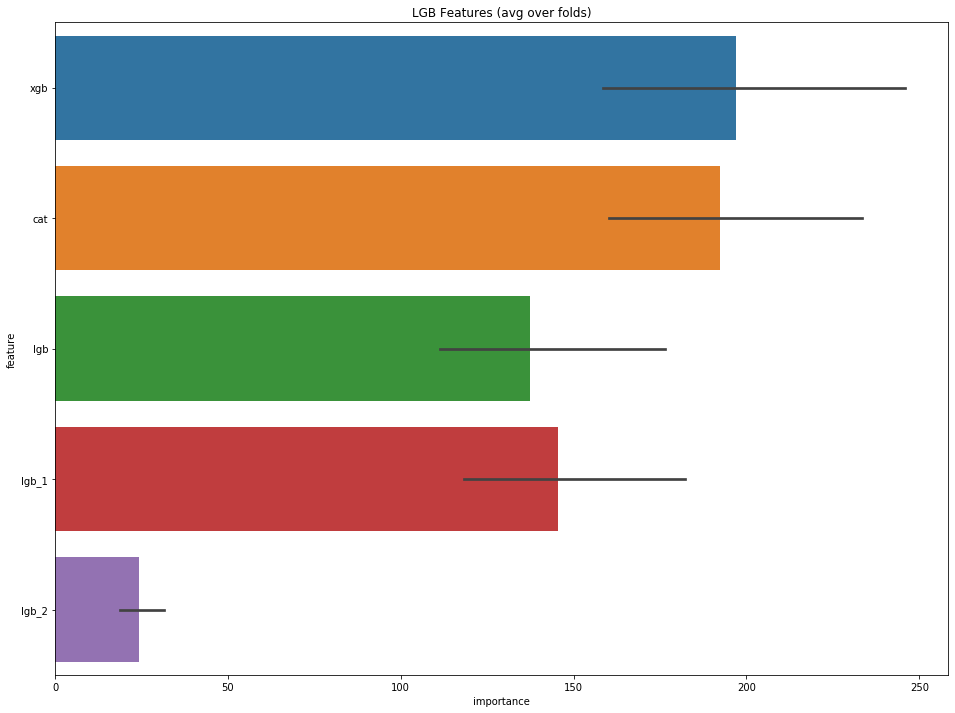

In [118]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:24:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[317]	training's rmse: 0.109702	valid_1's rmse: 0.123936
Fold 1 started at Tue Dec 17 11:24:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[525]	training's rmse: 0.108003	valid_1's rmse: 0.121252
Fold 2 started at Tue Dec 17 11:24:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[268]	training's rmse: 0.11154	valid_1's rmse: 0.117596
Fold 3 started at Tue Dec 17 11:24:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[300]	training's rmse: 0.110808	valid_1's rmse: 0.118365
Fold 4 started at Tue Dec 17 11:24:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[421]	training's rmse: 0.108906	valid_1's rmse: 0.122773
Fold 5 star

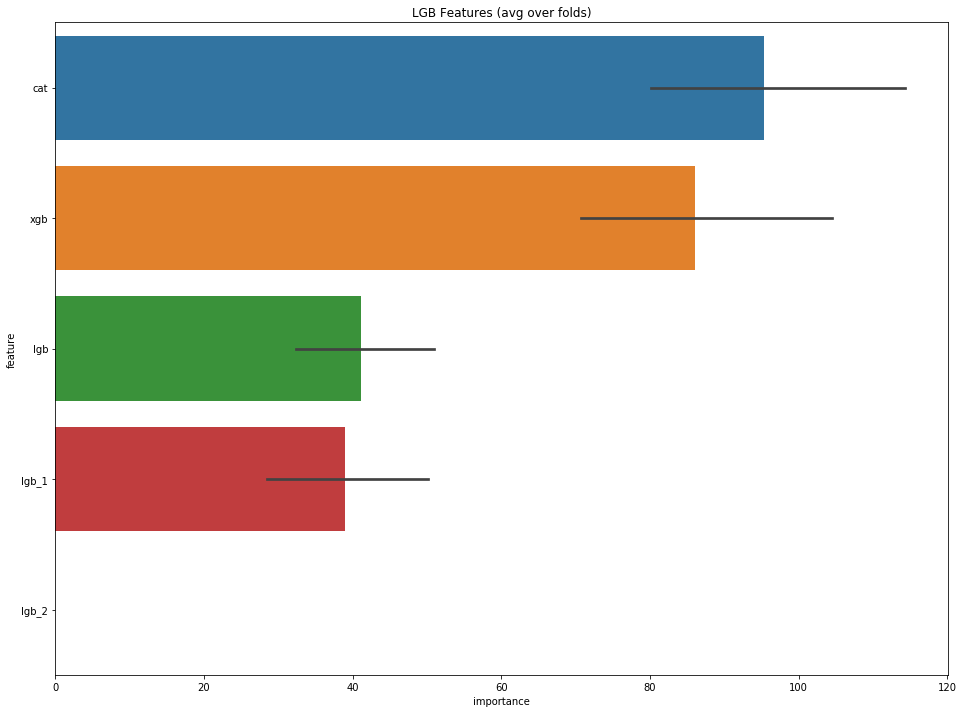

In [119]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [120]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:25:04 2019
Fold 1 started at Tue Dec 17 11:25:15 2019
Fold 2 started at Tue Dec 17 11:25:41 2019
Fold 3 started at Tue Dec 17 11:25:55 2019
Fold 4 started at Tue Dec 17 11:26:05 2019
Fold 5 started at Tue Dec 17 11:26:21 2019
Fold 6 started at Tue Dec 17 11:26:35 2019
Fold 7 started at Tue Dec 17 11:26:57 2019
Fold 8 started at Tue Dec 17 11:27:22 2019
Fold 9 started at Tue Dec 17 11:27:31 2019
CV mean score: 0.1165, std: 0.0075.


##### randomforest作为第二层融合模型

In [121]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:27:41 2019
Fold 1 started at Tue Dec 17 11:27:41 2019
Fold 2 started at Tue Dec 17 11:27:41 2019
Fold 3 started at Tue Dec 17 11:27:42 2019
Fold 4 started at Tue Dec 17 11:27:42 2019
Fold 5 started at Tue Dec 17 11:27:42 2019
Fold 6 started at Tue Dec 17 11:27:42 2019
Fold 7 started at Tue Dec 17 11:27:43 2019
Fold 8 started at Tue Dec 17 11:27:43 2019
Fold 9 started at Tue Dec 17 11:27:43 2019
CV mean score: 0.1201, std: 0.0065.


##### xgboost作为第二层融合模型

In [122]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:27:43 2019
[0]	train-rmse:0.482365	valid_data-rmse:0.473646
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.069044	valid_data-rmse:0.131066
Stopping. Best iteration:
[399]	train-rmse:0.073933	valid_data-rmse:0.130176

Fold 1 started at Tue Dec 17 11:27:44 2019
[0]	train-rmse:0.481841	valid_data-rmse:0.47845
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.070162	valid_data-rmse:0.121079
Stopping. Best iteration:
[735]	train-rmse:0.061298	valid_data-rmse:0.120957

Fold 2 started at Tue Dec 17 11:27:46 2019
[0]	train-rmse:0.480838	valid_data-rmse:0.487323
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

##### svr 作为第二层融合模型

In [123]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:27:53 2019
Fold 1 started at Tue Dec 17 11:27:53 2019
Fold 2 started at Tue Dec 17 11:27:53 2019
Fold 3 started at Tue Dec 17 11:27:53 2019
Fold 4 started at Tue Dec 17 11:27:53 2019
Fold 5 started at Tue Dec 17 11:27:53 2019
Fold 6 started at Tue Dec 17 11:27:53 2019
Fold 7 started at Tue Dec 17 11:27:53 2019
Fold 8 started at Tue Dec 17 11:27:53 2019
Fold 9 started at Tue Dec 17 11:27:54 2019
CV mean score: 0.1167, std: 0.0078.


##### 岭回归做第二层融合模型

In [124]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:27:54 2019
Fold 1 started at Tue Dec 17 11:27:54 2019
Fold 2 started at Tue Dec 17 11:27:54 2019
Fold 3 started at Tue Dec 17 11:27:54 2019
Fold 4 started at Tue Dec 17 11:27:54 2019
Fold 5 started at Tue Dec 17 11:27:54 2019
Fold 6 started at Tue Dec 17 11:27:54 2019
Fold 7 started at Tue Dec 17 11:27:54 2019
Fold 8 started at Tue Dec 17 11:27:54 2019
Fold 9 started at Tue Dec 17 11:27:55 2019
CV mean score: 0.1166, std: 0.0079.


#### 去掉svr和cat

In [125]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:27:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[235]	training's rmse: 0.106761	valid_1's rmse: 0.125972
Fold 1 started at Tue Dec 17 11:28:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[345]	training's rmse: 0.101462	valid_1's rmse: 0.126494
Fold 2 started at Tue Dec 17 11:28:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[255]	training's rmse: 0.105942	valid_1's rmse: 0.122211
Fold 3 started at Tue Dec 17 11:28:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[247]	training's rmse: 0.106491	valid_1's rmse: 0.124794
Fold 4 started at Tue Dec 17 11:28:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[265]	training's rmse: 0.105637	valid_1's rmse: 0.126317
Fold 5 sta

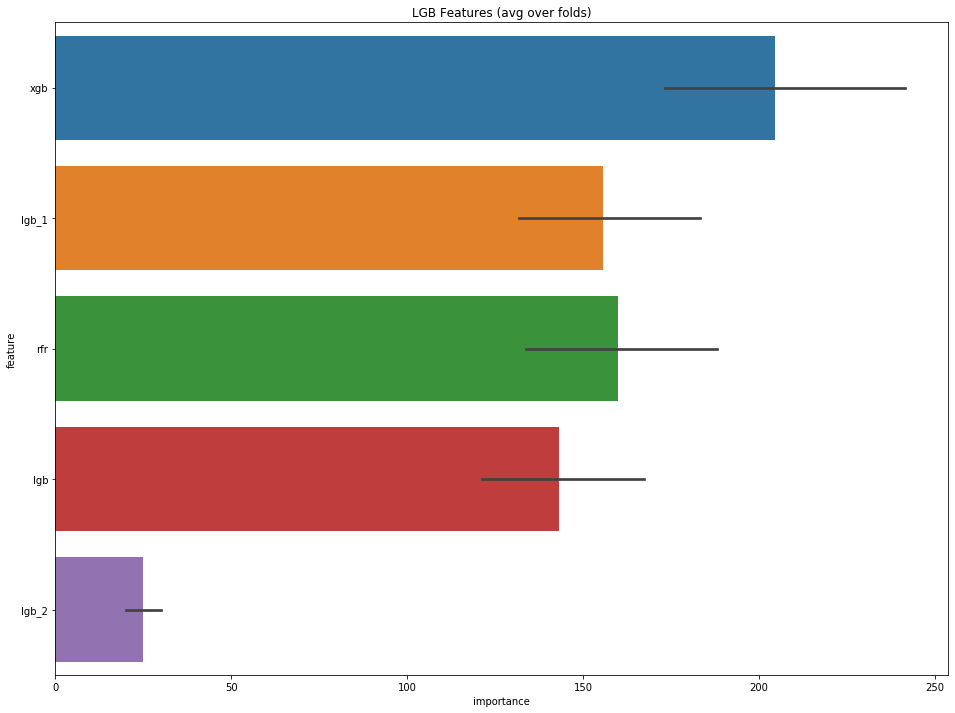

In [126]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:29:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[271]	training's rmse: 0.112701	valid_1's rmse: 0.121451
Fold 1 started at Tue Dec 17 11:29:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[383]	training's rmse: 0.110566	valid_1's rmse: 0.124471
Fold 2 started at Tue Dec 17 11:29:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[286]	training's rmse: 0.112373	valid_1's rmse: 0.120401
Fold 3 started at Tue Dec 17 11:29:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[251]	training's rmse: 0.113411	valid_1's rmse: 0.121358
Fold 4 started at Tue Dec 17 11:29:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[524]	training's rmse: 0.109281	valid_1's rmse: 0.125653
Fold 5 sta

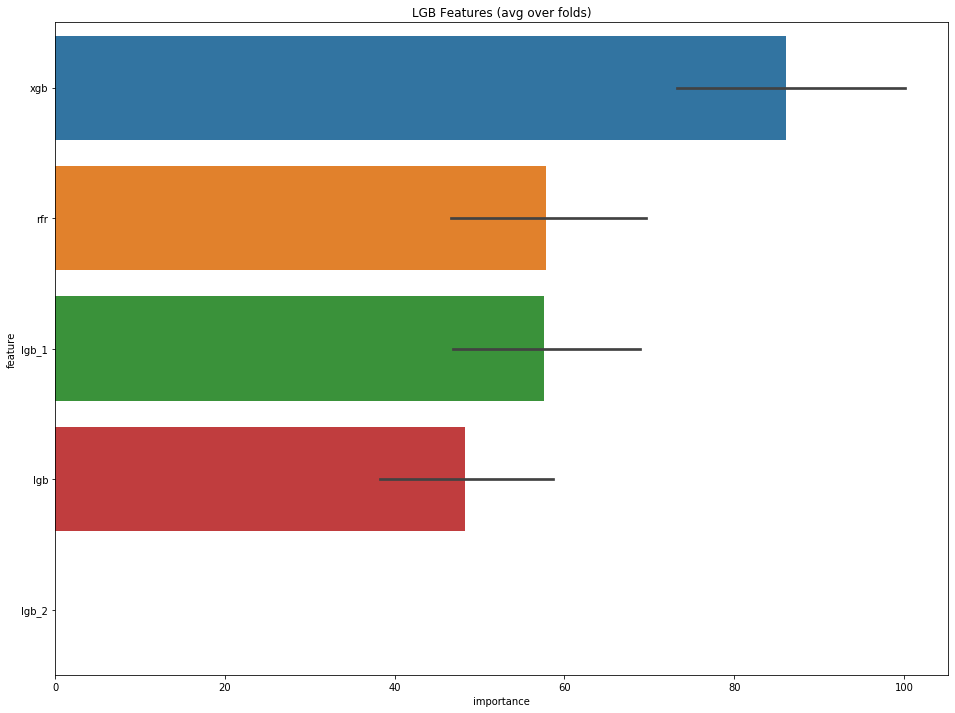

In [127]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [128]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:29:40 2019
Fold 1 started at Tue Dec 17 11:29:53 2019
Fold 2 started at Tue Dec 17 11:30:05 2019
Fold 3 started at Tue Dec 17 11:30:17 2019
Fold 4 started at Tue Dec 17 11:30:26 2019
Fold 5 started at Tue Dec 17 11:30:34 2019
Fold 6 started at Tue Dec 17 11:30:48 2019
Fold 7 started at Tue Dec 17 11:31:11 2019
Fold 8 started at Tue Dec 17 11:31:36 2019
Fold 9 started at Tue Dec 17 11:31:51 2019
CV mean score: 0.1174, std: 0.0075.


##### randomforest作为第二层融合模型

In [129]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:32:00 2019
Fold 1 started at Tue Dec 17 11:32:01 2019
Fold 2 started at Tue Dec 17 11:32:01 2019
Fold 3 started at Tue Dec 17 11:32:01 2019
Fold 4 started at Tue Dec 17 11:32:01 2019
Fold 5 started at Tue Dec 17 11:32:02 2019
Fold 6 started at Tue Dec 17 11:32:02 2019
Fold 7 started at Tue Dec 17 11:32:02 2019
Fold 8 started at Tue Dec 17 11:32:02 2019
Fold 9 started at Tue Dec 17 11:32:03 2019
CV mean score: 0.1214, std: 0.0067.


##### xgboost作为第二层融合模型

In [130]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:32:03 2019
[0]	train-rmse:0.482374	valid_data-rmse:0.473658
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.070723	valid_data-rmse:0.130022
Stopping. Best iteration:
[332]	train-rmse:0.080736	valid_data-rmse:0.129179

Fold 1 started at Tue Dec 17 11:32:04 2019
[0]	train-rmse:0.481852	valid_data-rmse:0.478446
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.071001	valid_data-rmse:0.129073
Stopping. Best iteration:
[362]	train-rmse:0.078671	valid_data-rmse:0.128707

Fold 2 started at Tue Dec 17 11:32:05 2019
[0]	train-rmse:0.480841	valid_data-rmse:0.487292
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds

##### svr 作为第二层融合模型

In [131]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:32:13 2019
Fold 1 started at Tue Dec 17 11:32:13 2019
Fold 2 started at Tue Dec 17 11:32:14 2019
Fold 3 started at Tue Dec 17 11:32:14 2019
Fold 4 started at Tue Dec 17 11:32:14 2019
Fold 5 started at Tue Dec 17 11:32:14 2019
Fold 6 started at Tue Dec 17 11:32:14 2019
Fold 7 started at Tue Dec 17 11:32:14 2019
Fold 8 started at Tue Dec 17 11:32:14 2019
Fold 9 started at Tue Dec 17 11:32:14 2019
CV mean score: 0.1171, std: 0.0077.


##### 岭回归做第二层融合模型

In [132]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:32:14 2019
Fold 1 started at Tue Dec 17 11:32:14 2019
Fold 2 started at Tue Dec 17 11:32:14 2019
Fold 3 started at Tue Dec 17 11:32:14 2019
Fold 4 started at Tue Dec 17 11:32:14 2019
Fold 5 started at Tue Dec 17 11:32:14 2019
Fold 6 started at Tue Dec 17 11:32:14 2019
Fold 7 started at Tue Dec 17 11:32:15 2019
Fold 8 started at Tue Dec 17 11:32:15 2019
Fold 9 started at Tue Dec 17 11:32:15 2019
CV mean score: 0.1170, std: 0.0078.


#### 去掉rfr和cat

In [133]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:32:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[257]	training's rmse: 0.104345	valid_1's rmse: 0.124638
Fold 1 started at Tue Dec 17 11:32:24 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0862343	valid_1's rmse: 0.122426
[2000]	training's rmse: 0.0735918	valid_1's rmse: 0.12151
Early stopping, best iteration is:
[1849]	training's rmse: 0.0751387	valid_1's rmse: 0.121393
Fold 2 started at Tue Dec 17 11:33:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[386]	training's rmse: 0.0997436	valid_1's rmse: 0.119501
Fold 3 started at Tue Dec 17 11:33:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[245]	training's rmse: 0.105196	valid_1's rmse: 0.125187
Fold 4 started at Tue Dec 17 11:33:08 2019
Training until validation scores don't improv

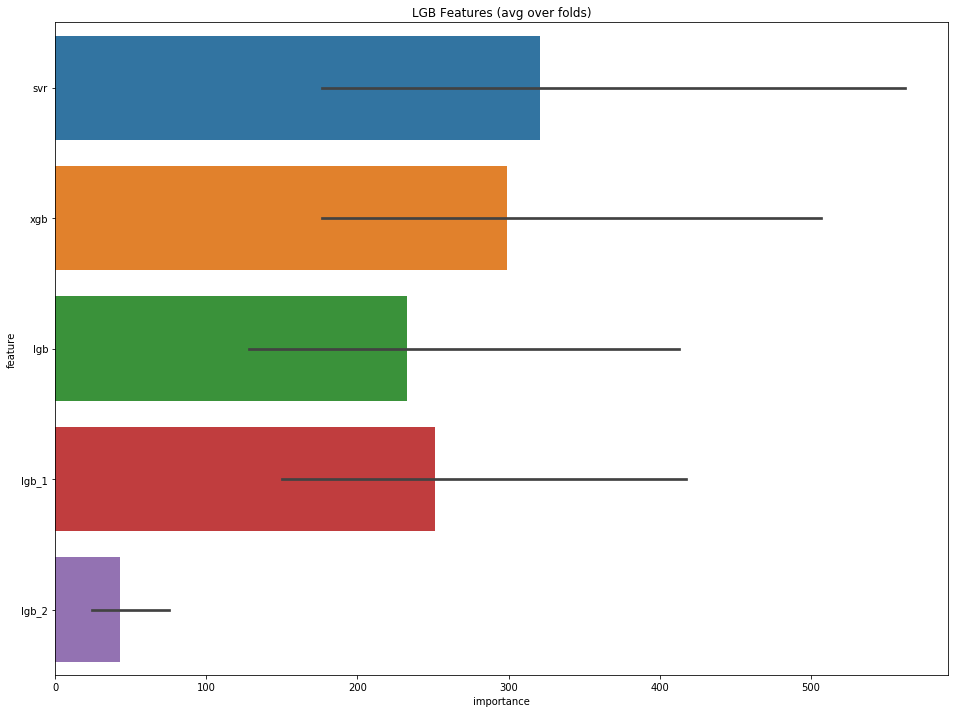

In [134]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:33:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[347]	training's rmse: 0.111131	valid_1's rmse: 0.12184
Fold 1 started at Tue Dec 17 11:33:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[445]	training's rmse: 0.109879	valid_1's rmse: 0.125155
Fold 2 started at Tue Dec 17 11:33:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[402]	training's rmse: 0.111015	valid_1's rmse: 0.119296
Fold 3 started at Tue Dec 17 11:33:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[257]	training's rmse: 0.113078	valid_1's rmse: 0.121588
Fold 4 started at Tue Dec 17 11:33:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[357]	training's rmse: 0.111003	valid_1's rmse: 0.12487
Fold 5 start

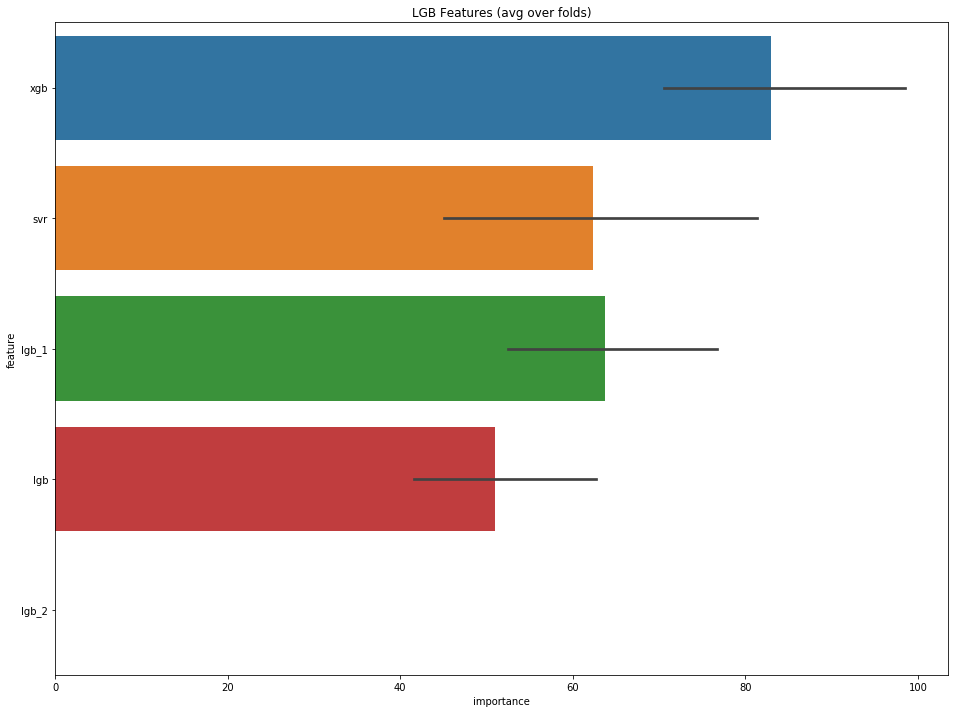

In [135]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [136]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:34:18 2019
Fold 1 started at Tue Dec 17 11:34:32 2019
Fold 2 started at Tue Dec 17 11:34:44 2019
Fold 3 started at Tue Dec 17 11:35:02 2019
Fold 4 started at Tue Dec 17 11:35:10 2019
Fold 5 started at Tue Dec 17 11:35:19 2019
Fold 6 started at Tue Dec 17 11:35:30 2019
Fold 7 started at Tue Dec 17 11:35:50 2019
Fold 8 started at Tue Dec 17 11:36:12 2019
Fold 9 started at Tue Dec 17 11:36:26 2019
CV mean score: 0.1177, std: 0.0071.


##### randomforest作为第二层融合模型

In [137]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:36:37 2019
Fold 1 started at Tue Dec 17 11:36:38 2019
Fold 2 started at Tue Dec 17 11:36:38 2019
Fold 3 started at Tue Dec 17 11:36:38 2019
Fold 4 started at Tue Dec 17 11:36:38 2019
Fold 5 started at Tue Dec 17 11:36:39 2019
Fold 6 started at Tue Dec 17 11:36:39 2019
Fold 7 started at Tue Dec 17 11:36:39 2019
Fold 8 started at Tue Dec 17 11:36:39 2019
Fold 9 started at Tue Dec 17 11:36:39 2019
CV mean score: 0.1212, std: 0.0061.


##### xgboost作为第二层融合模型

In [138]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:36:40 2019
[0]	train-rmse:0.482374	valid_data-rmse:0.473658
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.069511	valid_data-rmse:0.128057
Stopping. Best iteration:
[416]	train-rmse:0.07365	valid_data-rmse:0.127584

Fold 1 started at Tue Dec 17 11:36:41 2019
[0]	train-rmse:0.481852	valid_data-rmse:0.478446
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.069747	valid_data-rmse:0.125356
Stopping. Best iteration:
[470]	train-rmse:0.070991	valid_data-rmse:0.125226

Fold 2 started at Tue Dec 17 11:36:42 2019
[0]	train-rmse:0.480841	valid_data-rmse:0.487292
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

##### svr 作为第二层融合模型

In [139]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:36:51 2019
Fold 1 started at Tue Dec 17 11:36:51 2019
Fold 2 started at Tue Dec 17 11:36:51 2019
Fold 3 started at Tue Dec 17 11:36:51 2019
Fold 4 started at Tue Dec 17 11:36:52 2019
Fold 5 started at Tue Dec 17 11:36:52 2019
Fold 6 started at Tue Dec 17 11:36:52 2019
Fold 7 started at Tue Dec 17 11:36:52 2019
Fold 8 started at Tue Dec 17 11:36:52 2019
Fold 9 started at Tue Dec 17 11:36:52 2019
CV mean score: 0.1173, std: 0.0078.


##### 岭回归做第二层融合模型

In [140]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:36:52 2019
Fold 1 started at Tue Dec 17 11:36:52 2019
Fold 2 started at Tue Dec 17 11:36:52 2019
Fold 3 started at Tue Dec 17 11:36:52 2019
Fold 4 started at Tue Dec 17 11:36:52 2019
Fold 5 started at Tue Dec 17 11:36:52 2019
Fold 6 started at Tue Dec 17 11:36:53 2019
Fold 7 started at Tue Dec 17 11:36:53 2019
Fold 8 started at Tue Dec 17 11:36:53 2019
Fold 9 started at Tue Dec 17 11:36:53 2019
CV mean score: 0.1172, std: 0.0077.


#### 留下cat和rfr

In [141]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat, oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat', 'rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:36:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[290]	training's rmse: 0.110494	valid_1's rmse: 0.128135
Fold 1 started at Tue Dec 17 11:37:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[324]	training's rmse: 0.110067	valid_1's rmse: 0.126849
Fold 2 started at Tue Dec 17 11:37:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[276]	training's rmse: 0.111164	valid_1's rmse: 0.123039
Fold 3 started at Tue Dec 17 11:37:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[360]	training's rmse: 0.110547	valid_1's rmse: 0.115922
Fold 4 started at Tue Dec 17 11:37:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[288]	training's rmse: 0.110751	valid_1's rmse: 0.125784
Fold 5 sta

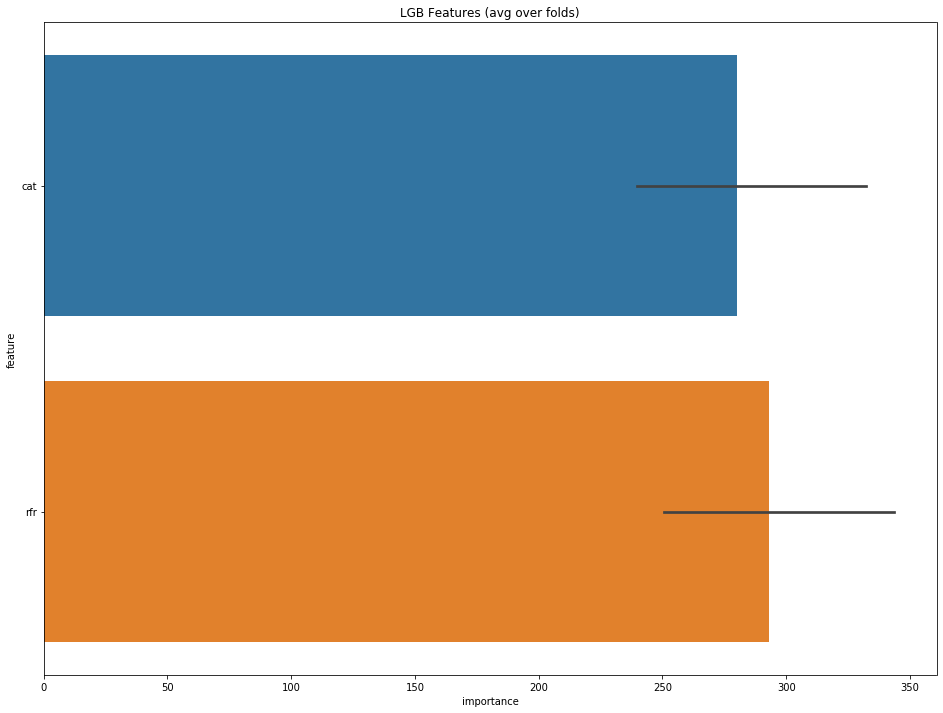

In [142]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:38:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[258]	training's rmse: 0.113211	valid_1's rmse: 0.123935
Fold 1 started at Tue Dec 17 11:38:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[397]	training's rmse: 0.111531	valid_1's rmse: 0.1231
Fold 2 started at Tue Dec 17 11:38:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[312]	training's rmse: 0.112593	valid_1's rmse: 0.119373
Fold 3 started at Tue Dec 17 11:38:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[443]	training's rmse: 0.112029	valid_1's rmse: 0.114609
Fold 4 started at Tue Dec 17 11:38:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[278]	training's rmse: 0.112634	valid_1's rmse: 0.124922
Fold 5 start

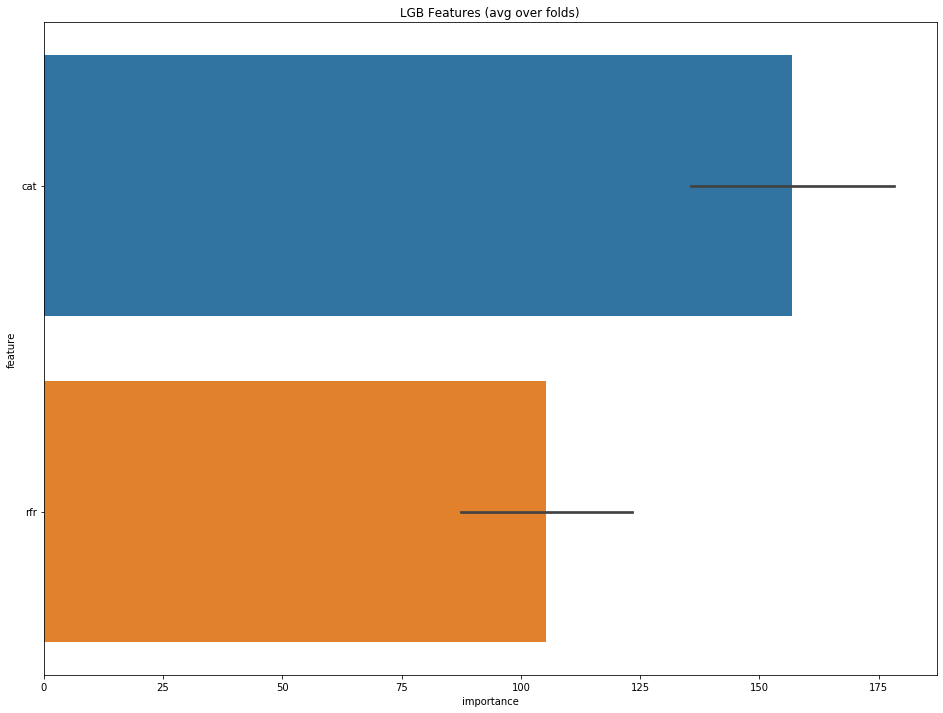

In [143]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [144]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:38:56 2019
Fold 1 started at Tue Dec 17 11:39:07 2019
Fold 2 started at Tue Dec 17 11:39:20 2019
Fold 3 started at Tue Dec 17 11:39:34 2019
Fold 4 started at Tue Dec 17 11:39:47 2019
Fold 5 started at Tue Dec 17 11:39:56 2019
Fold 6 started at Tue Dec 17 11:40:09 2019
Fold 7 started at Tue Dec 17 11:40:29 2019
Fold 8 started at Tue Dec 17 11:40:52 2019
Fold 9 started at Tue Dec 17 11:41:03 2019
CV mean score: 0.1173, std: 0.0074.


##### randomforest作为第二层融合模型

In [145]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:41:12 2019
Fold 1 started at Tue Dec 17 11:41:12 2019
Fold 2 started at Tue Dec 17 11:41:12 2019
Fold 3 started at Tue Dec 17 11:41:13 2019
Fold 4 started at Tue Dec 17 11:41:13 2019
Fold 5 started at Tue Dec 17 11:41:13 2019
Fold 6 started at Tue Dec 17 11:41:13 2019
Fold 7 started at Tue Dec 17 11:41:14 2019
Fold 8 started at Tue Dec 17 11:41:14 2019
Fold 9 started at Tue Dec 17 11:41:14 2019
CV mean score: 0.1227, std: 0.0078.


##### xgboost作为第二层融合模型

In [146]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:41:14 2019
[0]	train-rmse:0.482359	valid_data-rmse:0.473641
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.084135	valid_data-rmse:0.132333
Stopping. Best iteration:
[342]	train-rmse:0.091485	valid_data-rmse:0.13066

Fold 1 started at Tue Dec 17 11:41:15 2019
[0]	train-rmse:0.481852	valid_data-rmse:0.478517
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.085536	valid_data-rmse:0.127261
Stopping. Best iteration:
[428]	train-rmse:0.088361	valid_data-rmse:0.126622

Fold 2 started at Tue Dec 17 11:41:15 2019
[0]	train-rmse:0.480861	valid_data-rmse:0.487353
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

##### svr 作为第二层融合模型

In [147]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:41:19 2019
Fold 1 started at Tue Dec 17 11:41:19 2019
Fold 2 started at Tue Dec 17 11:41:19 2019
Fold 3 started at Tue Dec 17 11:41:19 2019
Fold 4 started at Tue Dec 17 11:41:19 2019
Fold 5 started at Tue Dec 17 11:41:19 2019
Fold 6 started at Tue Dec 17 11:41:19 2019
Fold 7 started at Tue Dec 17 11:41:19 2019
Fold 8 started at Tue Dec 17 11:41:19 2019
Fold 9 started at Tue Dec 17 11:41:19 2019
CV mean score: 0.1173, std: 0.0073.


##### 岭回归做第二层融合模型

In [148]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:41:19 2019
Fold 1 started at Tue Dec 17 11:41:20 2019
Fold 2 started at Tue Dec 17 11:41:20 2019
Fold 3 started at Tue Dec 17 11:41:20 2019
Fold 4 started at Tue Dec 17 11:41:20 2019
Fold 5 started at Tue Dec 17 11:41:20 2019
Fold 6 started at Tue Dec 17 11:41:20 2019
Fold 7 started at Tue Dec 17 11:41:20 2019
Fold 8 started at Tue Dec 17 11:41:20 2019
Fold 9 started at Tue Dec 17 11:41:20 2019
CV mean score: 0.1173, std: 0.0074.


#### 留下cat和svr

In [149]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_cat, oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:41:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[294]	training's rmse: 0.113251	valid_1's rmse: 0.135996
Fold 1 started at Tue Dec 17 11:41:29 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.106872	valid_1's rmse: 0.128179
Early stopping, best iteration is:
[878]	training's rmse: 0.107628	valid_1's rmse: 0.127915
Fold 2 started at Tue Dec 17 11:41:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[346]	training's rmse: 0.112955	valid_1's rmse: 0.120403
Fold 3 started at Tue Dec 17 11:41:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 0.113796	valid_1's rmse: 0.121529
Fold 4 started at Tue Dec 17 11:41:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[286]	tra

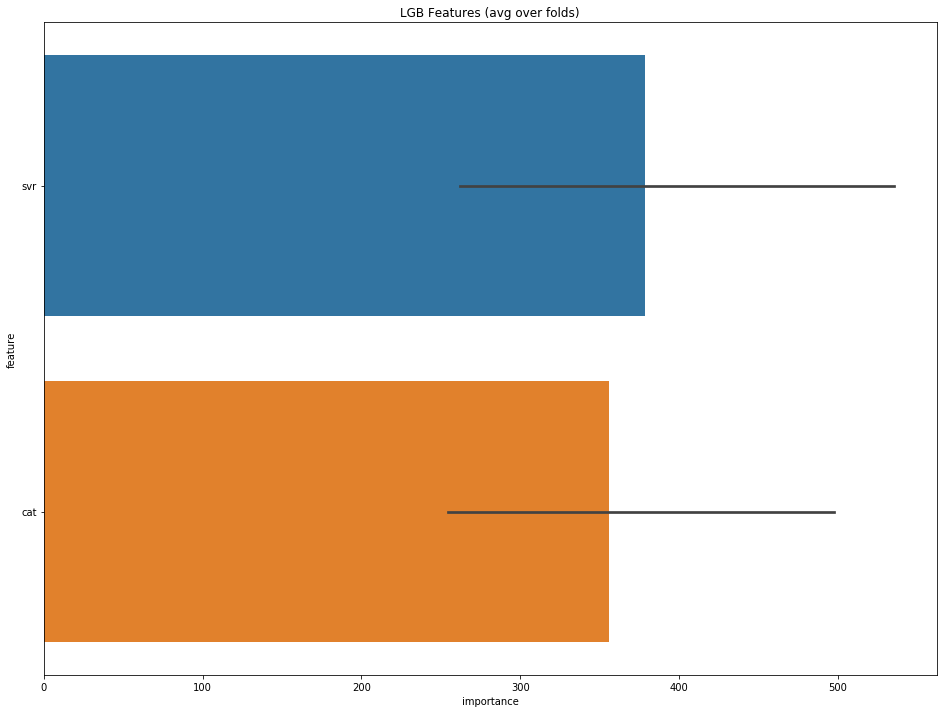

In [150]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:42:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[297]	training's rmse: 0.112916	valid_1's rmse: 0.125248
Fold 1 started at Tue Dec 17 11:42:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[466]	training's rmse: 0.111447	valid_1's rmse: 0.122568
Fold 2 started at Tue Dec 17 11:42:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[422]	training's rmse: 0.11209	valid_1's rmse: 0.118937
Fold 3 started at Tue Dec 17 11:42:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[732]	training's rmse: 0.110181	valid_1's rmse: 0.116348
Fold 4 started at Tue Dec 17 11:42:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[246]	training's rmse: 0.11461	valid_1's rmse: 0.125682
Fold 5 start

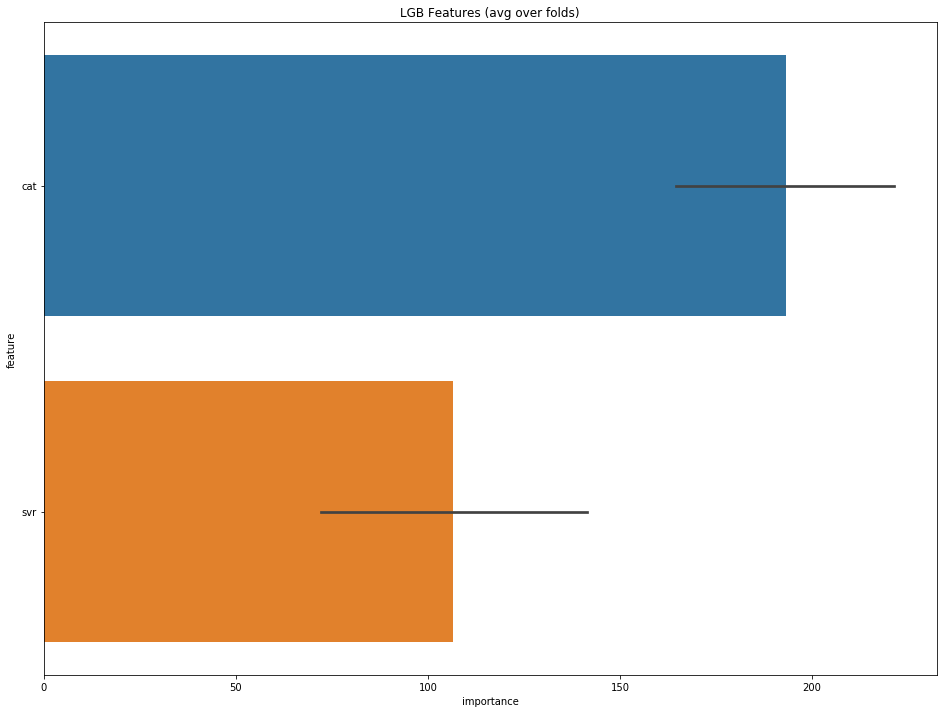

In [151]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [152]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:42:57 2019
Fold 1 started at Tue Dec 17 11:43:14 2019
Fold 2 started at Tue Dec 17 11:43:31 2019
Fold 3 started at Tue Dec 17 11:43:50 2019
Fold 4 started at Tue Dec 17 11:44:25 2019
Fold 5 started at Tue Dec 17 11:44:35 2019
Fold 6 started at Tue Dec 17 11:45:05 2019
Fold 7 started at Tue Dec 17 11:45:26 2019
Fold 8 started at Tue Dec 17 11:45:54 2019
Fold 9 started at Tue Dec 17 11:46:27 2019
CV mean score: 0.1179, std: 0.0072.


##### randomforest作为第二层融合模型

In [153]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:46:35 2019
Fold 1 started at Tue Dec 17 11:46:36 2019
Fold 2 started at Tue Dec 17 11:46:36 2019
Fold 3 started at Tue Dec 17 11:46:36 2019
Fold 4 started at Tue Dec 17 11:46:36 2019
Fold 5 started at Tue Dec 17 11:46:37 2019
Fold 6 started at Tue Dec 17 11:46:37 2019
Fold 7 started at Tue Dec 17 11:46:37 2019
Fold 8 started at Tue Dec 17 11:46:37 2019
Fold 9 started at Tue Dec 17 11:46:38 2019
CV mean score: 0.1201, std: 0.0059.


##### xgboost作为第二层融合模型

In [154]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:46:38 2019
[0]	train-rmse:0.482359	valid_data-rmse:0.473641
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.084933	valid_data-rmse:0.141037
Stopping. Best iteration:
[323]	train-rmse:0.094729	valid_data-rmse:0.139571

Fold 1 started at Tue Dec 17 11:46:38 2019
[0]	train-rmse:0.481852	valid_data-rmse:0.478517
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.086996	valid_data-rmse:0.130183
Stopping. Best iteration:
[421]	train-rmse:0.09031	valid_data-rmse:0.129656

Fold 2 started at Tue Dec 17 11:46:39 2019
[0]	train-rmse:0.480861	valid_data-rmse:0.487353
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

##### svr 作为第二层融合模型

In [155]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:46:43 2019
Fold 1 started at Tue Dec 17 11:46:43 2019
Fold 2 started at Tue Dec 17 11:46:43 2019
Fold 3 started at Tue Dec 17 11:46:43 2019
Fold 4 started at Tue Dec 17 11:46:43 2019
Fold 5 started at Tue Dec 17 11:46:43 2019
Fold 6 started at Tue Dec 17 11:46:43 2019
Fold 7 started at Tue Dec 17 11:46:43 2019
Fold 8 started at Tue Dec 17 11:46:43 2019
Fold 9 started at Tue Dec 17 11:46:43 2019
CV mean score: 0.1177, std: 0.0080.


##### 岭回归做第二层融合模型

In [156]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:46:43 2019
Fold 1 started at Tue Dec 17 11:46:43 2019
Fold 2 started at Tue Dec 17 11:46:43 2019
Fold 3 started at Tue Dec 17 11:46:43 2019
Fold 4 started at Tue Dec 17 11:46:43 2019
Fold 5 started at Tue Dec 17 11:46:43 2019
Fold 6 started at Tue Dec 17 11:46:44 2019
Fold 7 started at Tue Dec 17 11:46:44 2019
Fold 8 started at Tue Dec 17 11:46:44 2019
Fold 9 started at Tue Dec 17 11:46:44 2019
CV mean score: 0.1176, std: 0.0080.


#### 留下rfr和svr

In [157]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:46:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[281]	training's rmse: 0.11529	valid_1's rmse: 0.133085
Fold 1 started at Tue Dec 17 11:46:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[289]	training's rmse: 0.114342	valid_1's rmse: 0.137035
Fold 2 started at Tue Dec 17 11:47:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[745]	training's rmse: 0.110945	valid_1's rmse: 0.121908
Fold 3 started at Tue Dec 17 11:47:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[277]	training's rmse: 0.116186	valid_1's rmse: 0.122226
Fold 4 started at Tue Dec 17 11:47:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[282]	training's rmse: 0.115793	valid_1's rmse: 0.127191
Fold 5 star

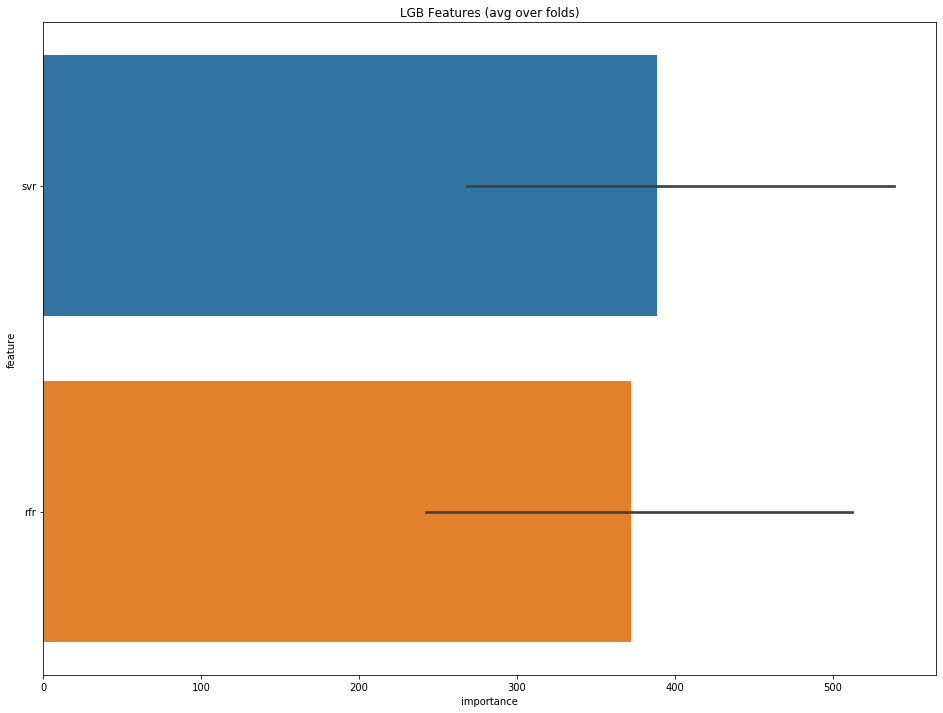

In [158]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:48:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[385]	training's rmse: 0.114264	valid_1's rmse: 0.124995
Fold 1 started at Tue Dec 17 11:48:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[290]	training's rmse: 0.115286	valid_1's rmse: 0.13054
Fold 2 started at Tue Dec 17 11:48:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[374]	training's rmse: 0.114916	valid_1's rmse: 0.122345
Fold 3 started at Tue Dec 17 11:48:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[359]	training's rmse: 0.115135	valid_1's rmse: 0.117991
Fold 4 started at Tue Dec 17 11:48:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[296]	training's rmse: 0.114875	valid_1's rmse: 0.129084
Fold 5 star

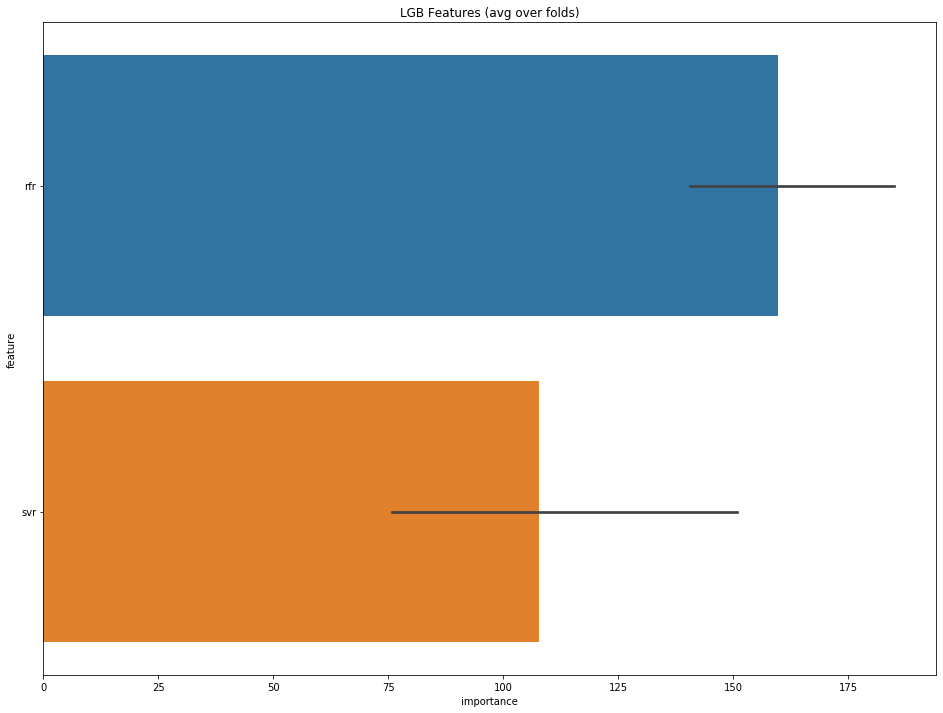

In [159]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [160]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:49:16 2019
Fold 1 started at Tue Dec 17 11:49:35 2019
Fold 2 started at Tue Dec 17 11:49:46 2019
Fold 3 started at Tue Dec 17 11:50:04 2019
Fold 4 started at Tue Dec 17 11:50:15 2019
Fold 5 started at Tue Dec 17 11:50:24 2019
Fold 6 started at Tue Dec 17 11:50:34 2019
Fold 7 started at Tue Dec 17 11:50:52 2019
Fold 8 started at Tue Dec 17 11:51:14 2019
Fold 9 started at Tue Dec 17 11:51:29 2019
CV mean score: 0.1202, std: 0.0061.


##### randomforest作为第二层融合模型

In [161]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:51:38 2019
Fold 1 started at Tue Dec 17 11:51:38 2019
Fold 2 started at Tue Dec 17 11:51:38 2019
Fold 3 started at Tue Dec 17 11:51:39 2019
Fold 4 started at Tue Dec 17 11:51:39 2019
Fold 5 started at Tue Dec 17 11:51:39 2019
Fold 6 started at Tue Dec 17 11:51:39 2019
Fold 7 started at Tue Dec 17 11:51:39 2019
Fold 8 started at Tue Dec 17 11:51:40 2019
Fold 9 started at Tue Dec 17 11:51:40 2019
CV mean score: 0.1243, std: 0.0068.


##### xgboost作为第二层融合模型

In [162]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:51:40 2019
[0]	train-rmse:0.482458	valid_data-rmse:0.473829
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.088204	valid_data-rmse:0.138417
Stopping. Best iteration:
[378]	train-rmse:0.093784	valid_data-rmse:0.137408

Fold 1 started at Tue Dec 17 11:51:41 2019
[0]	train-rmse:0.481931	valid_data-rmse:0.478672
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.088474	valid_data-rmse:0.138713
Stopping. Best iteration:
[342]	train-rmse:0.096842	valid_data-rmse:0.137452

Fold 2 started at Tue Dec 17 11:51:41 2019
[0]	train-rmse:0.480932	valid_data-rmse:0.487366
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds

##### svr 作为第二层融合模型

In [163]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:51:45 2019
Fold 1 started at Tue Dec 17 11:51:45 2019
Fold 2 started at Tue Dec 17 11:51:45 2019
Fold 3 started at Tue Dec 17 11:51:45 2019
Fold 4 started at Tue Dec 17 11:51:45 2019
Fold 5 started at Tue Dec 17 11:51:45 2019
Fold 6 started at Tue Dec 17 11:51:45 2019
Fold 7 started at Tue Dec 17 11:51:45 2019
Fold 8 started at Tue Dec 17 11:51:46 2019
Fold 9 started at Tue Dec 17 11:51:46 2019
CV mean score: 0.1194, std: 0.0069.


##### 岭回归做第二层融合模型

In [164]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:51:46 2019
Fold 1 started at Tue Dec 17 11:51:46 2019
Fold 2 started at Tue Dec 17 11:51:46 2019
Fold 3 started at Tue Dec 17 11:51:46 2019
Fold 4 started at Tue Dec 17 11:51:46 2019
Fold 5 started at Tue Dec 17 11:51:46 2019
Fold 6 started at Tue Dec 17 11:51:46 2019
Fold 7 started at Tue Dec 17 11:51:46 2019
Fold 8 started at Tue Dec 17 11:51:46 2019
Fold 9 started at Tue Dec 17 11:51:47 2019
CV mean score: 0.1192, std: 0.0068.


#### 留下xgb和cat

In [165]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_xgb, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'cat'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:51:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[294]	training's rmse: 0.10876	valid_1's rmse: 0.125768
Fold 1 started at Tue Dec 17 11:51:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[361]	training's rmse: 0.107954	valid_1's rmse: 0.122139
Fold 2 started at Tue Dec 17 11:52:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[255]	training's rmse: 0.110773	valid_1's rmse: 0.118072
Fold 3 started at Tue Dec 17 11:52:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[327]	training's rmse: 0.109459	valid_1's rmse: 0.116865
Fold 4 started at Tue Dec 17 11:52:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[290]	training's rmse: 0.10959	valid_1's rmse: 0.123346
Fold 5 start

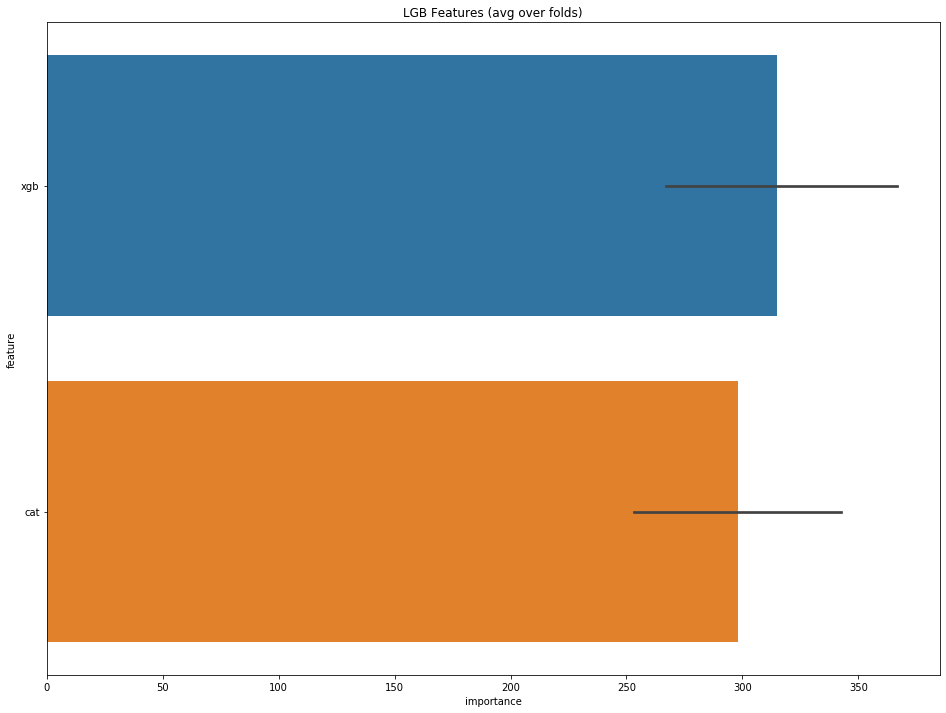

In [166]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:53:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[322]	training's rmse: 0.110414	valid_1's rmse: 0.123441
Fold 1 started at Tue Dec 17 11:53:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[497]	training's rmse: 0.109558	valid_1's rmse: 0.119823
Fold 2 started at Tue Dec 17 11:53:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[271]	training's rmse: 0.11214	valid_1's rmse: 0.117099
Fold 3 started at Tue Dec 17 11:53:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[398]	training's rmse: 0.110749	valid_1's rmse: 0.116382
Fold 4 started at Tue Dec 17 11:53:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[271]	training's rmse: 0.111781	valid_1's rmse: 0.122363
Fold 5 star

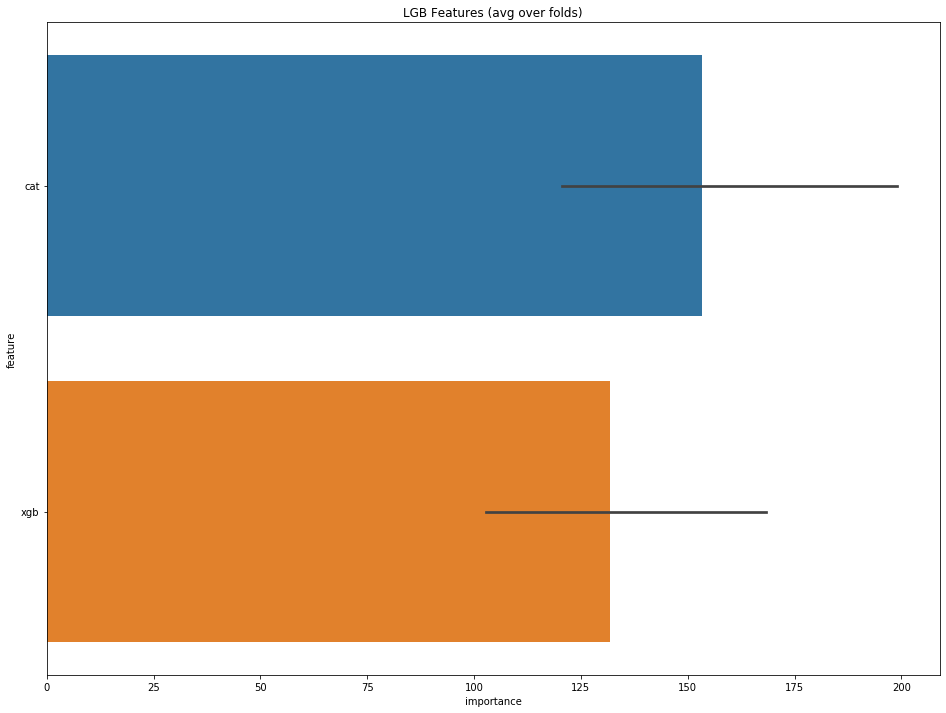

In [167]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [168]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:53:38 2019
Fold 1 started at Tue Dec 17 11:53:48 2019
Fold 2 started at Tue Dec 17 11:54:03 2019
Fold 3 started at Tue Dec 17 11:54:15 2019
Fold 4 started at Tue Dec 17 11:54:26 2019
Fold 5 started at Tue Dec 17 11:54:41 2019
Fold 6 started at Tue Dec 17 11:55:15 2019
Fold 7 started at Tue Dec 17 11:55:36 2019
Fold 8 started at Tue Dec 17 11:55:59 2019
Fold 9 started at Tue Dec 17 11:56:12 2019
CV mean score: 0.1160, std: 0.0077.


##### randomforest作为第二层融合模型

In [169]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:56:23 2019
Fold 1 started at Tue Dec 17 11:56:23 2019
Fold 2 started at Tue Dec 17 11:56:23 2019
Fold 3 started at Tue Dec 17 11:56:23 2019
Fold 4 started at Tue Dec 17 11:56:24 2019
Fold 5 started at Tue Dec 17 11:56:24 2019
Fold 6 started at Tue Dec 17 11:56:24 2019
Fold 7 started at Tue Dec 17 11:56:24 2019
Fold 8 started at Tue Dec 17 11:56:25 2019
Fold 9 started at Tue Dec 17 11:56:25 2019
CV mean score: 0.1213, std: 0.0066.


##### xgboost作为第二层融合模型

In [170]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:56:25 2019
[0]	train-rmse:0.482382	valid_data-rmse:0.473626
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.082601	valid_data-rmse:0.12743
Stopping. Best iteration:
[351]	train-rmse:0.08996	valid_data-rmse:0.126071

Fold 1 started at Tue Dec 17 11:56:26 2019
[0]	train-rmse:0.481854	valid_data-rmse:0.478429
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.083521	valid_data-rmse:0.125047
Stopping. Best iteration:
[348]	train-rmse:0.09113	valid_data-rmse:0.124128

Fold 2 started at Tue Dec 17 11:56:26 2019
[0]	train-rmse:0.480846	valid_data-rmse:0.487189
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[

##### svr 作为第二层融合模型

In [171]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:56:30 2019
Fold 1 started at Tue Dec 17 11:56:30 2019
Fold 2 started at Tue Dec 17 11:56:30 2019
Fold 3 started at Tue Dec 17 11:56:30 2019
Fold 4 started at Tue Dec 17 11:56:30 2019
Fold 5 started at Tue Dec 17 11:56:30 2019
Fold 6 started at Tue Dec 17 11:56:30 2019
Fold 7 started at Tue Dec 17 11:56:30 2019
Fold 8 started at Tue Dec 17 11:56:30 2019
Fold 9 started at Tue Dec 17 11:56:30 2019
CV mean score: 0.1168, std: 0.0077.


##### 岭回归做第二层融合模型

In [172]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:56:30 2019
Fold 1 started at Tue Dec 17 11:56:30 2019
Fold 2 started at Tue Dec 17 11:56:30 2019
Fold 3 started at Tue Dec 17 11:56:31 2019
Fold 4 started at Tue Dec 17 11:56:31 2019
Fold 5 started at Tue Dec 17 11:56:31 2019
Fold 6 started at Tue Dec 17 11:56:31 2019
Fold 7 started at Tue Dec 17 11:56:31 2019
Fold 8 started at Tue Dec 17 11:56:31 2019
Fold 9 started at Tue Dec 17 11:56:31 2019
CV mean score: 0.1166, std: 0.0078.


#### 留下xgb和rfr

In [173]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:56:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[287]	training's rmse: 0.111835	valid_1's rmse: 0.122815
Fold 1 started at Tue Dec 17 11:56:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[276]	training's rmse: 0.111389	valid_1's rmse: 0.128237
Fold 2 started at Tue Dec 17 11:56:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	training's rmse: 0.112976	valid_1's rmse: 0.121624
Fold 3 started at Tue Dec 17 11:57:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[286]	training's rmse: 0.112523	valid_1's rmse: 0.119595
Fold 4 started at Tue Dec 17 11:57:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[284]	training's rmse: 0.111436	valid_1's rmse: 0.129357
Fold 5 sta

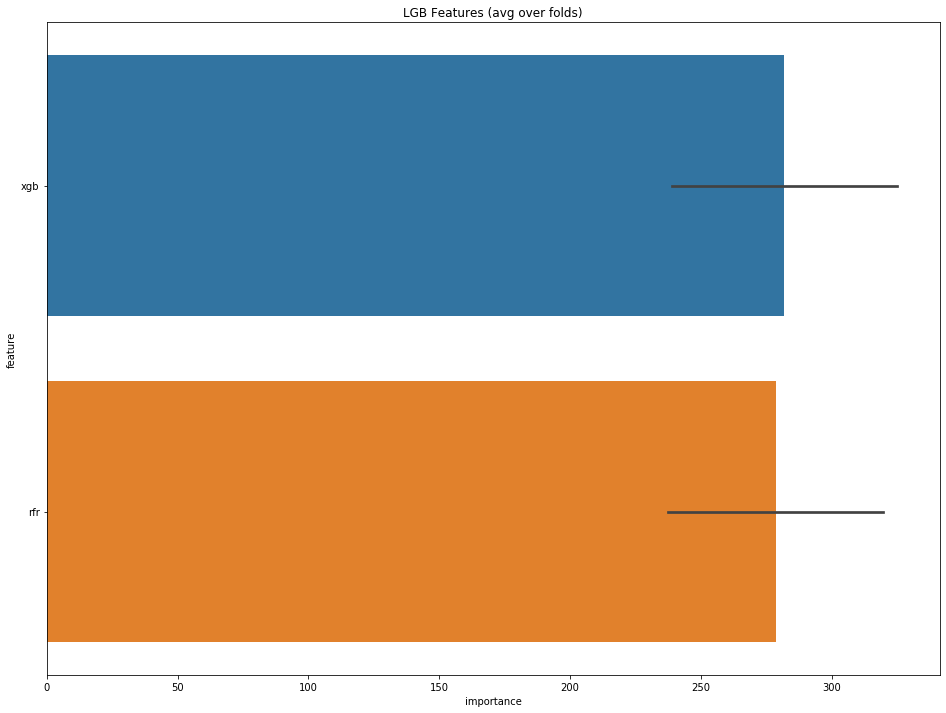

In [174]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:57:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[306]	training's rmse: 0.113432	valid_1's rmse: 0.120904
Fold 1 started at Tue Dec 17 11:57:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[317]	training's rmse: 0.113105	valid_1's rmse: 0.124315
Fold 2 started at Tue Dec 17 11:58:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[314]	training's rmse: 0.1139	valid_1's rmse: 0.120142
Fold 3 started at Tue Dec 17 11:58:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[277]	training's rmse: 0.114393	valid_1's rmse: 0.119865
Fold 4 started at Tue Dec 17 11:58:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[291]	training's rmse: 0.11325	valid_1's rmse: 0.128151
Fold 5 starte

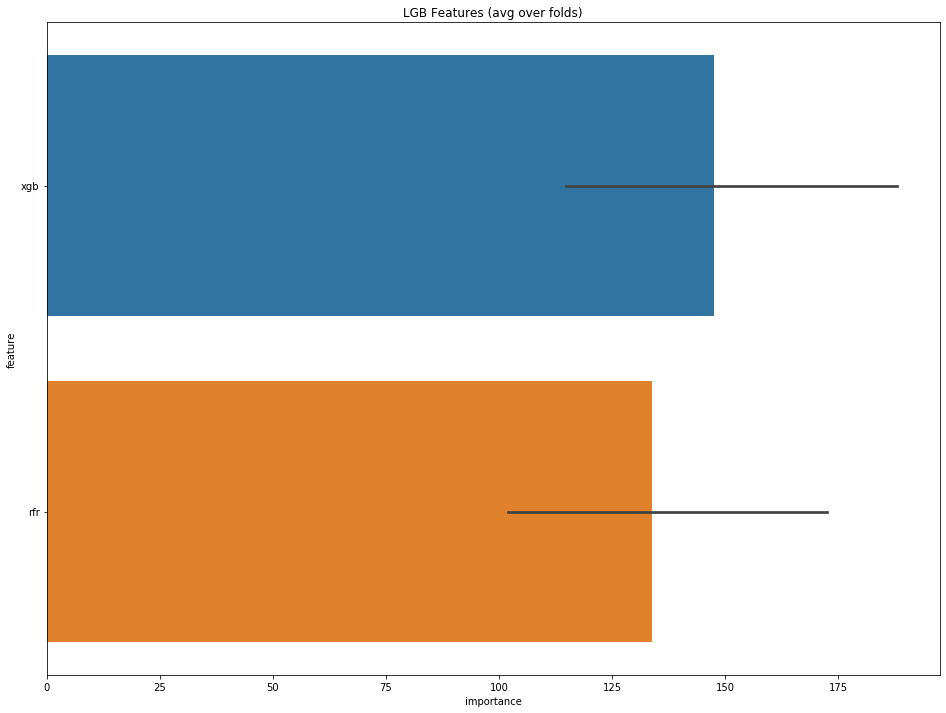

In [175]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [176]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:58:30 2019
Fold 1 started at Tue Dec 17 11:58:42 2019
Fold 2 started at Tue Dec 17 11:58:53 2019
Fold 3 started at Tue Dec 17 11:59:07 2019
Fold 4 started at Tue Dec 17 11:59:16 2019
Fold 5 started at Tue Dec 17 11:59:27 2019
Fold 6 started at Tue Dec 17 11:59:47 2019
Fold 7 started at Tue Dec 17 12:00:05 2019
Fold 8 started at Tue Dec 17 12:00:30 2019
Fold 9 started at Tue Dec 17 12:00:43 2019
CV mean score: 0.1179, std: 0.0071.


##### randomforest作为第二层融合模型

In [177]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:00:52 2019
Fold 1 started at Tue Dec 17 12:00:52 2019
Fold 2 started at Tue Dec 17 12:00:52 2019
Fold 3 started at Tue Dec 17 12:00:53 2019
Fold 4 started at Tue Dec 17 12:00:53 2019
Fold 5 started at Tue Dec 17 12:00:53 2019
Fold 6 started at Tue Dec 17 12:00:53 2019
Fold 7 started at Tue Dec 17 12:00:54 2019
Fold 8 started at Tue Dec 17 12:00:54 2019
Fold 9 started at Tue Dec 17 12:00:54 2019
CV mean score: 0.1231, std: 0.0079.


##### xgboost作为第二层融合模型

In [178]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:00:54 2019
[0]	train-rmse:0.482382	valid_data-rmse:0.473626
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.085385	valid_data-rmse:0.126957
Stopping. Best iteration:
[366]	train-rmse:0.09174	valid_data-rmse:0.125644

Fold 1 started at Tue Dec 17 12:00:55 2019
[0]	train-rmse:0.481854	valid_data-rmse:0.478429
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.085118	valid_data-rmse:0.132
Stopping. Best iteration:
[339]	train-rmse:0.093192	valid_data-rmse:0.130462

Fold 2 started at Tue Dec 17 12:00:55 2019
[0]	train-rmse:0.480846	valid_data-rmse:0.487189
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[5

##### svr 作为第二层融合模型

In [179]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:00:59 2019
Fold 1 started at Tue Dec 17 12:00:59 2019
Fold 2 started at Tue Dec 17 12:00:59 2019
Fold 3 started at Tue Dec 17 12:00:59 2019
Fold 4 started at Tue Dec 17 12:00:59 2019
Fold 5 started at Tue Dec 17 12:00:59 2019
Fold 6 started at Tue Dec 17 12:00:59 2019
Fold 7 started at Tue Dec 17 12:00:59 2019
Fold 8 started at Tue Dec 17 12:01:00 2019
Fold 9 started at Tue Dec 17 12:01:00 2019
CV mean score: 0.1178, std: 0.0075.


##### 岭回归做第二层融合模型

In [180]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:01:00 2019
Fold 1 started at Tue Dec 17 12:01:00 2019
Fold 2 started at Tue Dec 17 12:01:00 2019
Fold 3 started at Tue Dec 17 12:01:00 2019
Fold 4 started at Tue Dec 17 12:01:00 2019
Fold 5 started at Tue Dec 17 12:01:00 2019
Fold 6 started at Tue Dec 17 12:01:00 2019
Fold 7 started at Tue Dec 17 12:01:00 2019
Fold 8 started at Tue Dec 17 12:01:00 2019
Fold 9 started at Tue Dec 17 12:01:01 2019
CV mean score: 0.1178, std: 0.0075.


#### 留下xgb和svr

In [181]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:01:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[347]	training's rmse: 0.111714	valid_1's rmse: 0.129421
Fold 1 started at Tue Dec 17 12:01:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[362]	training's rmse: 0.111515	valid_1's rmse: 0.129357
Fold 2 started at Tue Dec 17 12:01:28 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.107507	valid_1's rmse: 0.115273
Early stopping, best iteration is:
[809]	training's rmse: 0.108628	valid_1's rmse: 0.115035
Fold 3 started at Tue Dec 17 12:01:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[266]	training's rmse: 0.114512	valid_1's rmse: 0.123182
Fold 4 started at Tue Dec 17 12:01:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[298]	tra

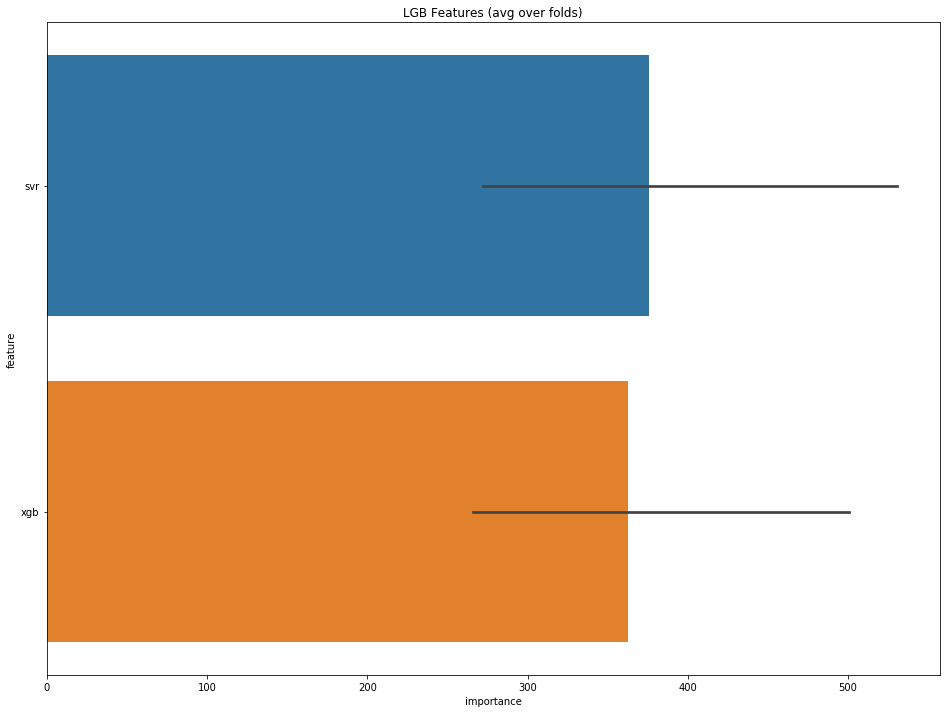

In [182]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:02:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[571]	training's rmse: 0.111606	valid_1's rmse: 0.122006
Fold 1 started at Tue Dec 17 12:02:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[339]	training's rmse: 0.113183	valid_1's rmse: 0.126132
Fold 2 started at Tue Dec 17 12:02:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.1123	valid_1's rmse: 0.116413
Fold 3 started at Tue Dec 17 12:02:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[284]	training's rmse: 0.114627	valid_1's rmse: 0.120859
Fold 4 started at Tue Dec 17 12:02:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[274]	training's rmse: 0.114203	valid_1's rmse: 0.125911
Fold 5 start

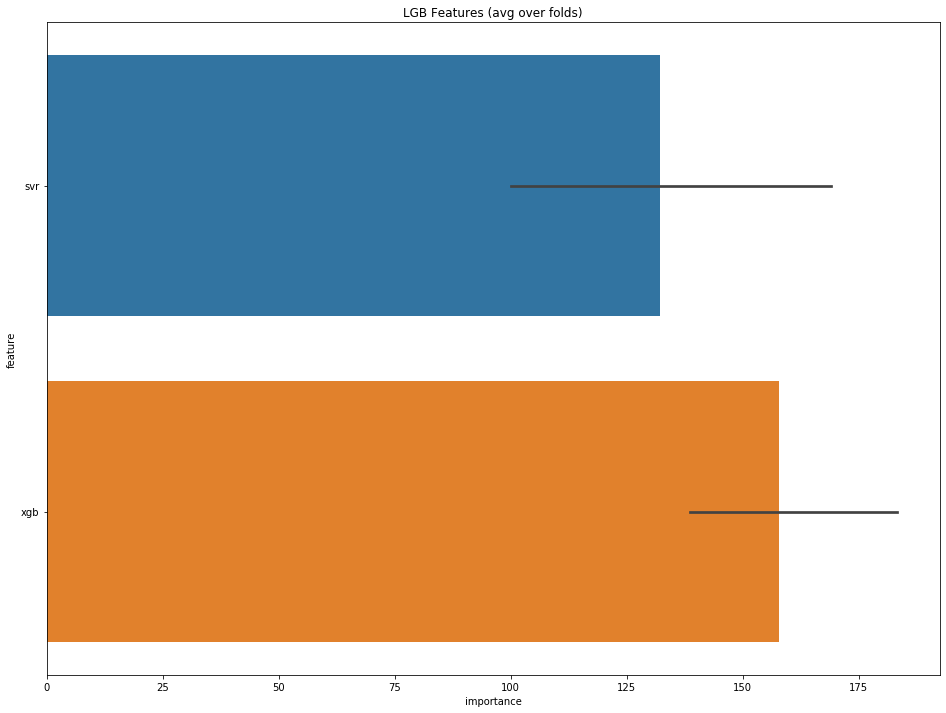

In [183]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [184]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:02:57 2019
Fold 1 started at Tue Dec 17 12:03:19 2019
Fold 2 started at Tue Dec 17 12:03:31 2019
Fold 3 started at Tue Dec 17 12:03:57 2019
Fold 4 started at Tue Dec 17 12:04:05 2019
Fold 5 started at Tue Dec 17 12:04:14 2019
Fold 6 started at Tue Dec 17 12:04:37 2019
Fold 7 started at Tue Dec 17 12:04:54 2019
Fold 8 started at Tue Dec 17 12:05:12 2019
Fold 9 started at Tue Dec 17 12:05:25 2019
CV mean score: 0.1189, std: 0.0059.


##### randomforest作为第二层融合模型

In [185]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:05:35 2019
Fold 1 started at Tue Dec 17 12:05:35 2019
Fold 2 started at Tue Dec 17 12:05:36 2019
Fold 3 started at Tue Dec 17 12:05:36 2019
Fold 4 started at Tue Dec 17 12:05:36 2019
Fold 5 started at Tue Dec 17 12:05:36 2019
Fold 6 started at Tue Dec 17 12:05:37 2019
Fold 7 started at Tue Dec 17 12:05:37 2019
Fold 8 started at Tue Dec 17 12:05:37 2019
Fold 9 started at Tue Dec 17 12:05:37 2019
CV mean score: 0.1223, std: 0.0062.


##### xgboost作为第二层融合模型

In [186]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:05:37 2019
[0]	train-rmse:0.482382	valid_data-rmse:0.473626
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.086795	valid_data-rmse:0.132425
Stopping. Best iteration:
[348]	train-rmse:0.094202	valid_data-rmse:0.131905

Fold 1 started at Tue Dec 17 12:05:38 2019
[0]	train-rmse:0.481854	valid_data-rmse:0.478429
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.087029	valid_data-rmse:0.135406
Stopping. Best iteration:
[324]	train-rmse:0.0966	valid_data-rmse:0.133823

Fold 2 started at Tue Dec 17 12:05:38 2019
[0]	train-rmse:0.480846	valid_data-rmse:0.487189
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


##### svr 作为第二层融合模型

In [187]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:05:42 2019
Fold 1 started at Tue Dec 17 12:05:42 2019
Fold 2 started at Tue Dec 17 12:05:42 2019
Fold 3 started at Tue Dec 17 12:05:43 2019
Fold 4 started at Tue Dec 17 12:05:43 2019
Fold 5 started at Tue Dec 17 12:05:43 2019
Fold 6 started at Tue Dec 17 12:05:43 2019
Fold 7 started at Tue Dec 17 12:05:43 2019
Fold 8 started at Tue Dec 17 12:05:43 2019
Fold 9 started at Tue Dec 17 12:05:43 2019
CV mean score: 0.1188, std: 0.0072.


##### 岭回归做第二层融合模型

In [188]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:05:43 2019
Fold 1 started at Tue Dec 17 12:05:43 2019
Fold 2 started at Tue Dec 17 12:05:43 2019
Fold 3 started at Tue Dec 17 12:05:43 2019
Fold 4 started at Tue Dec 17 12:05:43 2019
Fold 5 started at Tue Dec 17 12:05:43 2019
Fold 6 started at Tue Dec 17 12:05:43 2019
Fold 7 started at Tue Dec 17 12:05:43 2019
Fold 8 started at Tue Dec 17 12:05:44 2019
Fold 9 started at Tue Dec 17 12:05:44 2019
CV mean score: 0.1185, std: 0.0073.


#### 留下lgb和cat

In [189]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:05:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[240]	training's rmse: 0.108079	valid_1's rmse: 0.129411
Fold 1 started at Tue Dec 17 12:05:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[342]	training's rmse: 0.105466	valid_1's rmse: 0.12357
Fold 2 started at Tue Dec 17 12:06:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[294]	training's rmse: 0.106612	valid_1's rmse: 0.122593
Fold 3 started at Tue Dec 17 12:06:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[237]	training's rmse: 0.109323	valid_1's rmse: 0.123148
Fold 4 started at Tue Dec 17 12:06:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[420]	training's rmse: 0.104137	valid_1's rmse: 0.123071
Fold 5 star

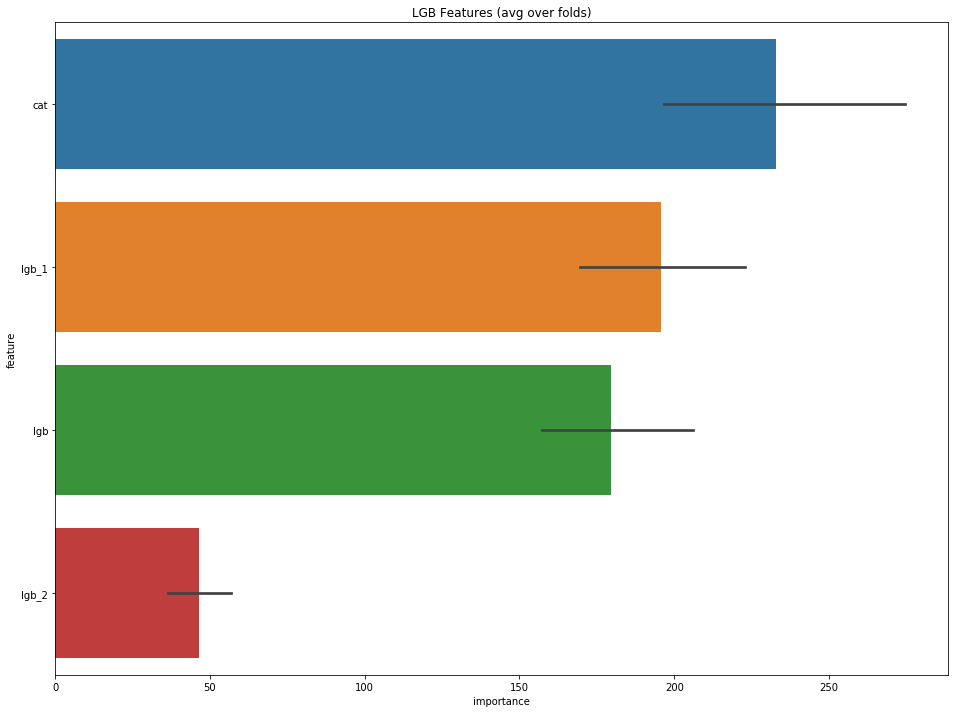

In [190]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:07:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[304]	training's rmse: 0.111401	valid_1's rmse: 0.125337
Fold 1 started at Tue Dec 17 12:07:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[479]	training's rmse: 0.109956	valid_1's rmse: 0.122089
Fold 2 started at Tue Dec 17 12:07:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[276]	training's rmse: 0.112869	valid_1's rmse: 0.120271
Fold 3 started at Tue Dec 17 12:07:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	training's rmse: 0.113158	valid_1's rmse: 0.119195
Fold 4 started at Tue Dec 17 12:07:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[300]	training's rmse: 0.111929	valid_1's rmse: 0.123798
Fold 5 sta

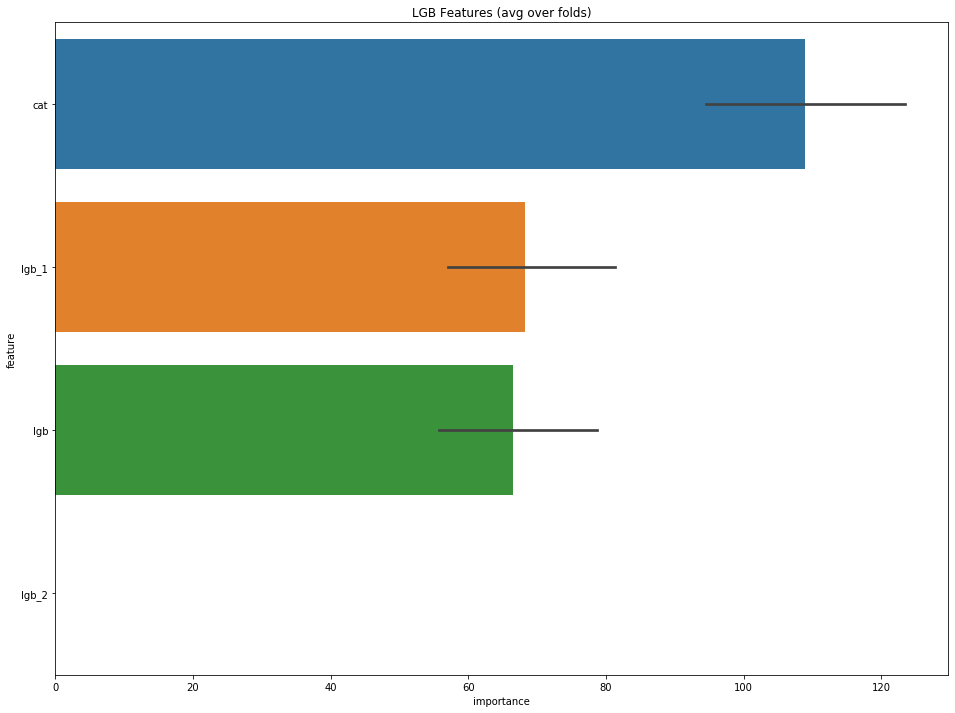

In [191]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [192]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:07:40 2019
Fold 1 started at Tue Dec 17 12:07:52 2019
Fold 2 started at Tue Dec 17 12:08:05 2019
Fold 3 started at Tue Dec 17 12:08:21 2019
Fold 4 started at Tue Dec 17 12:08:32 2019
Fold 5 started at Tue Dec 17 12:09:34 2019
Fold 6 started at Tue Dec 17 12:09:56 2019
Fold 7 started at Tue Dec 17 12:10:27 2019
Fold 8 started at Tue Dec 17 12:10:55 2019
Fold 9 started at Tue Dec 17 12:11:10 2019
CV mean score: 0.1169, std: 0.0076.


##### randomforest作为第二层融合模型

In [193]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:11:20 2019
Fold 1 started at Tue Dec 17 12:11:20 2019
Fold 2 started at Tue Dec 17 12:11:20 2019
Fold 3 started at Tue Dec 17 12:11:20 2019
Fold 4 started at Tue Dec 17 12:11:21 2019
Fold 5 started at Tue Dec 17 12:11:21 2019
Fold 6 started at Tue Dec 17 12:11:21 2019
Fold 7 started at Tue Dec 17 12:11:21 2019
Fold 8 started at Tue Dec 17 12:11:22 2019
Fold 9 started at Tue Dec 17 12:11:22 2019
CV mean score: 0.1227, std: 0.0067.


##### xgboost作为第二层融合模型

In [194]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:11:22 2019
[0]	train-rmse:0.482371	valid_data-rmse:0.473652
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.075449	valid_data-rmse:0.135948
Stopping. Best iteration:
[338]	train-rmse:0.08408	valid_data-rmse:0.134484

Fold 1 started at Tue Dec 17 12:11:23 2019
[0]	train-rmse:0.481848	valid_data-rmse:0.478448
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.077125	valid_data-rmse:0.121236
Stopping. Best iteration:
[575]	train-rmse:0.074229	valid_data-rmse:0.121042

Fold 2 started at Tue Dec 17 12:11:24 2019
[0]	train-rmse:0.48085	valid_data-rmse:0.487353
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


##### svr 作为第二层融合模型

In [195]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:11:31 2019
Fold 1 started at Tue Dec 17 12:11:31 2019
Fold 2 started at Tue Dec 17 12:11:31 2019
Fold 3 started at Tue Dec 17 12:11:31 2019
Fold 4 started at Tue Dec 17 12:11:31 2019
Fold 5 started at Tue Dec 17 12:11:31 2019
Fold 6 started at Tue Dec 17 12:11:31 2019
Fold 7 started at Tue Dec 17 12:11:31 2019
Fold 8 started at Tue Dec 17 12:11:31 2019
Fold 9 started at Tue Dec 17 12:11:31 2019
CV mean score: 0.1169, std: 0.0079.


##### 岭回归做第二层融合模型

In [196]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:11:31 2019
Fold 1 started at Tue Dec 17 12:11:31 2019
Fold 2 started at Tue Dec 17 12:11:32 2019
Fold 3 started at Tue Dec 17 12:11:32 2019
Fold 4 started at Tue Dec 17 12:11:32 2019
Fold 5 started at Tue Dec 17 12:11:32 2019
Fold 6 started at Tue Dec 17 12:11:32 2019
Fold 7 started at Tue Dec 17 12:11:32 2019
Fold 8 started at Tue Dec 17 12:11:32 2019
Fold 9 started at Tue Dec 17 12:11:32 2019
CV mean score: 0.1168, std: 0.0080.


#### 留下lgb和rfr

In [197]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:11:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[237]	training's rmse: 0.109686	valid_1's rmse: 0.127049
Fold 1 started at Tue Dec 17 12:11:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[305]	training's rmse: 0.10691	valid_1's rmse: 0.129098
Fold 2 started at Tue Dec 17 12:11:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[325]	training's rmse: 0.106767	valid_1's rmse: 0.124323
Fold 3 started at Tue Dec 17 12:12:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[242]	training's rmse: 0.109677	valid_1's rmse: 0.125611
Fold 4 started at Tue Dec 17 12:12:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[271]	training's rmse: 0.108322	valid_1's rmse: 0.127578
Fold 5 star

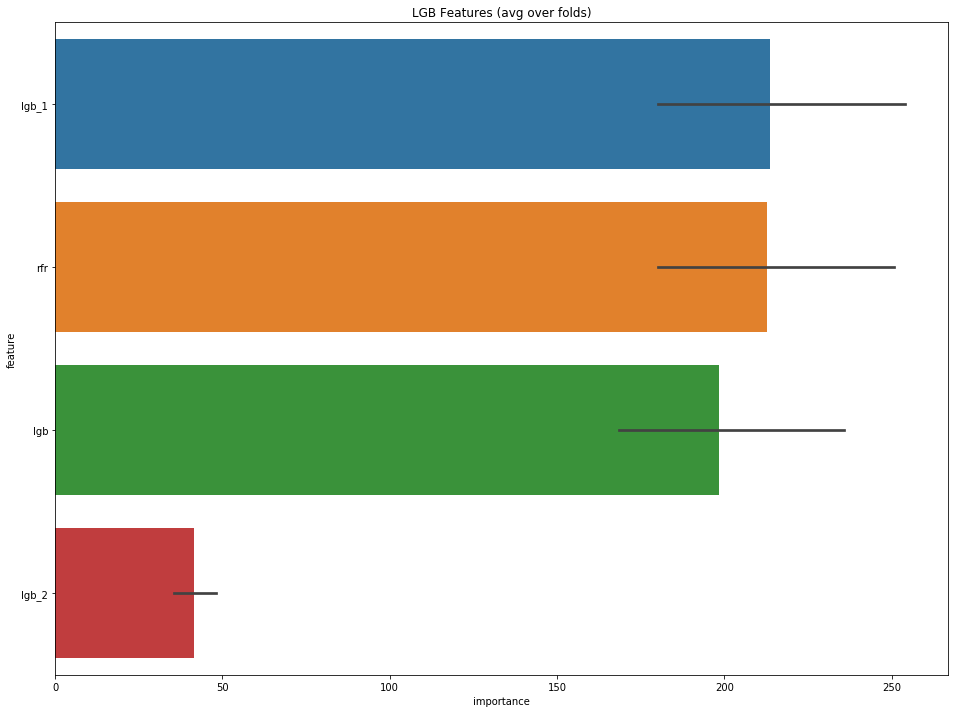

In [198]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:13:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[298]	training's rmse: 0.113549	valid_1's rmse: 0.1223
Fold 1 started at Tue Dec 17 12:13:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[354]	training's rmse: 0.112608	valid_1's rmse: 0.126897
Fold 2 started at Tue Dec 17 12:13:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[305]	training's rmse: 0.113363	valid_1's rmse: 0.123755
Fold 3 started at Tue Dec 17 12:13:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[248]	training's rmse: 0.114667	valid_1's rmse: 0.122561
Fold 4 started at Tue Dec 17 12:13:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[375]	training's rmse: 0.112078	valid_1's rmse: 0.127271
Fold 5 start

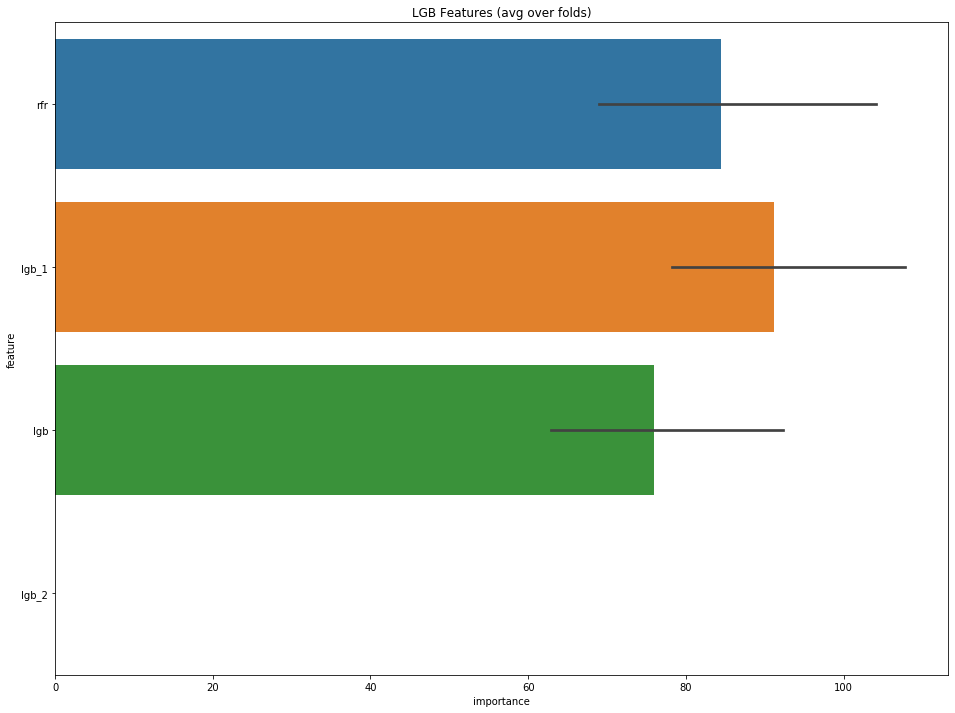

In [199]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [200]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:13:40 2019
Fold 1 started at Tue Dec 17 12:13:56 2019
Fold 2 started at Tue Dec 17 12:14:10 2019
Fold 3 started at Tue Dec 17 12:14:25 2019
Fold 4 started at Tue Dec 17 12:14:36 2019
Fold 5 started at Tue Dec 17 12:14:46 2019
Fold 6 started at Tue Dec 17 12:15:00 2019
Fold 7 started at Tue Dec 17 12:15:29 2019
Fold 8 started at Tue Dec 17 12:15:55 2019
Fold 9 started at Tue Dec 17 12:16:09 2019
CV mean score: 0.1180, std: 0.0076.


##### randomforest作为第二层融合模型

In [201]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:16:18 2019
Fold 1 started at Tue Dec 17 12:16:18 2019
Fold 2 started at Tue Dec 17 12:16:19 2019
Fold 3 started at Tue Dec 17 12:16:19 2019
Fold 4 started at Tue Dec 17 12:16:19 2019
Fold 5 started at Tue Dec 17 12:16:19 2019
Fold 6 started at Tue Dec 17 12:16:20 2019
Fold 7 started at Tue Dec 17 12:16:20 2019
Fold 8 started at Tue Dec 17 12:16:20 2019
Fold 9 started at Tue Dec 17 12:16:20 2019
CV mean score: 0.1239, std: 0.0073.


##### xgboost作为第二层融合模型

In [202]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:16:21 2019
[0]	train-rmse:0.482374	valid_data-rmse:0.473663
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.076855	valid_data-rmse:0.134202
Stopping. Best iteration:
[337]	train-rmse:0.085787	valid_data-rmse:0.132912

Fold 1 started at Tue Dec 17 12:16:21 2019
[0]	train-rmse:0.481845	valid_data-rmse:0.478456
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.077293	valid_data-rmse:0.132208
Stopping. Best iteration:
[387]	train-rmse:0.082562	valid_data-rmse:0.131809

Fold 2 started at Tue Dec 17 12:16:22 2019
[0]	train-rmse:0.480847	valid_data-rmse:0.487328
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds

##### svr 作为第二层融合模型

In [203]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:16:29 2019
Fold 1 started at Tue Dec 17 12:16:29 2019
Fold 2 started at Tue Dec 17 12:16:29 2019
Fold 3 started at Tue Dec 17 12:16:29 2019
Fold 4 started at Tue Dec 17 12:16:29 2019
Fold 5 started at Tue Dec 17 12:16:29 2019
Fold 6 started at Tue Dec 17 12:16:29 2019
Fold 7 started at Tue Dec 17 12:16:29 2019
Fold 8 started at Tue Dec 17 12:16:29 2019
Fold 9 started at Tue Dec 17 12:16:29 2019
CV mean score: 0.1173, std: 0.0077.


##### 岭回归做第二层融合模型

In [204]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:16:29 2019
Fold 1 started at Tue Dec 17 12:16:30 2019
Fold 2 started at Tue Dec 17 12:16:30 2019
Fold 3 started at Tue Dec 17 12:16:30 2019
Fold 4 started at Tue Dec 17 12:16:30 2019
Fold 5 started at Tue Dec 17 12:16:30 2019
Fold 6 started at Tue Dec 17 12:16:30 2019
Fold 7 started at Tue Dec 17 12:16:30 2019
Fold 8 started at Tue Dec 17 12:16:30 2019
Fold 9 started at Tue Dec 17 12:16:31 2019
CV mean score: 0.1171, std: 0.0077.


#### 留下lgb和svr

In [205]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:16:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 0.107483	valid_1's rmse: 0.126619
Fold 1 started at Tue Dec 17 12:16:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[388]	training's rmse: 0.103087	valid_1's rmse: 0.125277
Fold 2 started at Tue Dec 17 12:16:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[362]	training's rmse: 0.104181	valid_1's rmse: 0.121667
Fold 3 started at Tue Dec 17 12:17:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[247]	training's rmse: 0.107776	valid_1's rmse: 0.125951
Fold 4 started at Tue Dec 17 12:17:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[343]	training's rmse: 0.104431	valid_1's rmse: 0.125603
Fold 5 sta

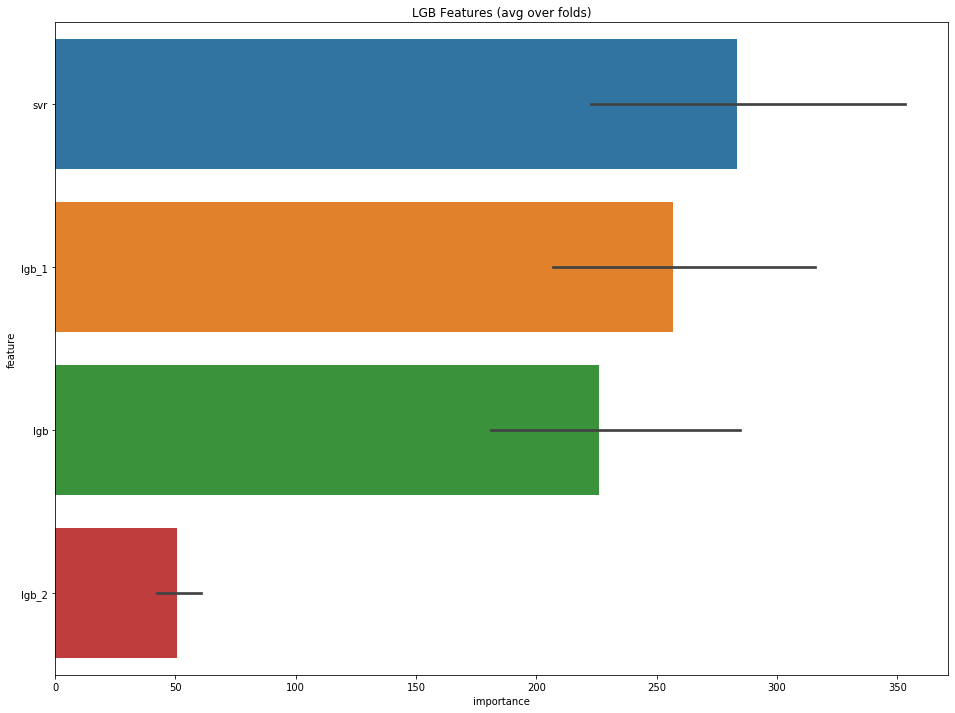

In [206]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:18:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[434]	training's rmse: 0.111594	valid_1's rmse: 0.123382
Fold 1 started at Tue Dec 17 12:18:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[404]	training's rmse: 0.1121	valid_1's rmse: 0.126149
Fold 2 started at Tue Dec 17 12:18:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[413]	training's rmse: 0.112413	valid_1's rmse: 0.120895
Fold 3 started at Tue Dec 17 12:19:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[268]	training's rmse: 0.11409	valid_1's rmse: 0.122117
Fold 4 started at Tue Dec 17 12:19:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[347]	training's rmse: 0.112621	valid_1's rmse: 0.125946
Fold 5 starte

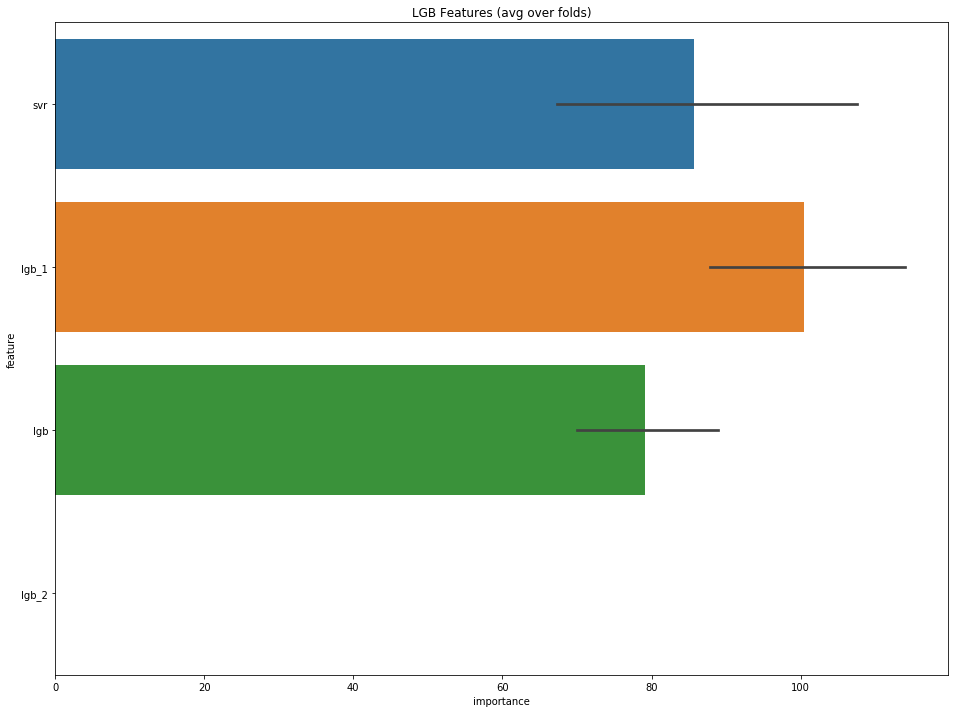

In [207]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [208]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:19:34 2019
Fold 1 started at Tue Dec 17 12:19:51 2019
Fold 2 started at Tue Dec 17 12:20:02 2019
Fold 3 started at Tue Dec 17 12:20:22 2019
Fold 4 started at Tue Dec 17 12:20:33 2019
Fold 5 started at Tue Dec 17 12:20:45 2019
Fold 6 started at Tue Dec 17 12:20:59 2019
Fold 7 started at Tue Dec 17 12:21:18 2019
Fold 8 started at Tue Dec 17 12:21:32 2019
Fold 9 started at Tue Dec 17 12:21:42 2019
CV mean score: 0.1186, std: 0.0073.


##### randomforest作为第二层融合模型

In [209]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:21:50 2019
Fold 1 started at Tue Dec 17 12:21:51 2019
Fold 2 started at Tue Dec 17 12:21:51 2019
Fold 3 started at Tue Dec 17 12:21:51 2019
Fold 4 started at Tue Dec 17 12:21:51 2019
Fold 5 started at Tue Dec 17 12:21:52 2019
Fold 6 started at Tue Dec 17 12:21:52 2019
Fold 7 started at Tue Dec 17 12:21:52 2019
Fold 8 started at Tue Dec 17 12:21:52 2019
Fold 9 started at Tue Dec 17 12:21:53 2019
CV mean score: 0.1230, std: 0.0069.


##### xgboost作为第二层融合模型

In [210]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:21:53 2019
[0]	train-rmse:0.482372	valid_data-rmse:0.473683
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.074998	valid_data-rmse:0.134294
Stopping. Best iteration:
[337]	train-rmse:0.084103	valid_data-rmse:0.133227

Fold 1 started at Tue Dec 17 12:21:54 2019
[0]	train-rmse:0.481844	valid_data-rmse:0.478456
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.075157	valid_data-rmse:0.129342
Stopping. Best iteration:
[446]	train-rmse:0.077515	valid_data-rmse:0.129192

Fold 2 started at Tue Dec 17 12:21:55 2019
[0]	train-rmse:0.480846	valid_data-rmse:0.487372
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds

##### svr 作为第二层融合模型

In [211]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:22:01 2019
Fold 1 started at Tue Dec 17 12:22:02 2019
Fold 2 started at Tue Dec 17 12:22:02 2019
Fold 3 started at Tue Dec 17 12:22:02 2019
Fold 4 started at Tue Dec 17 12:22:02 2019
Fold 5 started at Tue Dec 17 12:22:02 2019
Fold 6 started at Tue Dec 17 12:22:02 2019
Fold 7 started at Tue Dec 17 12:22:02 2019
Fold 8 started at Tue Dec 17 12:22:02 2019
Fold 9 started at Tue Dec 17 12:22:02 2019
CV mean score: 0.1177, std: 0.0079.


##### 岭回归做第二层融合模型

In [212]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:22:02 2019
Fold 1 started at Tue Dec 17 12:22:02 2019
Fold 2 started at Tue Dec 17 12:22:02 2019
Fold 3 started at Tue Dec 17 12:22:02 2019
Fold 4 started at Tue Dec 17 12:22:02 2019
Fold 5 started at Tue Dec 17 12:22:02 2019
Fold 6 started at Tue Dec 17 12:22:03 2019
Fold 7 started at Tue Dec 17 12:22:03 2019
Fold 8 started at Tue Dec 17 12:22:03 2019
Fold 9 started at Tue Dec 17 12:22:03 2019
CV mean score: 0.1176, std: 0.0077.


#### 留下lgb和xgb

In [213]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_xgb]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','xgb'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:22:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[255]	training's rmse: 0.107683	valid_1's rmse: 0.125511
Fold 1 started at Tue Dec 17 12:22:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[450]	training's rmse: 0.102665	valid_1's rmse: 0.123286
Fold 2 started at Tue Dec 17 12:22:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[306]	training's rmse: 0.10641	valid_1's rmse: 0.120563
Fold 3 started at Tue Dec 17 12:22:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[222]	training's rmse: 0.109935	valid_1's rmse: 0.125888
Fold 4 started at Tue Dec 17 12:22:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[266]	training's rmse: 0.107892	valid_1's rmse: 0.125047
Fold 5 star

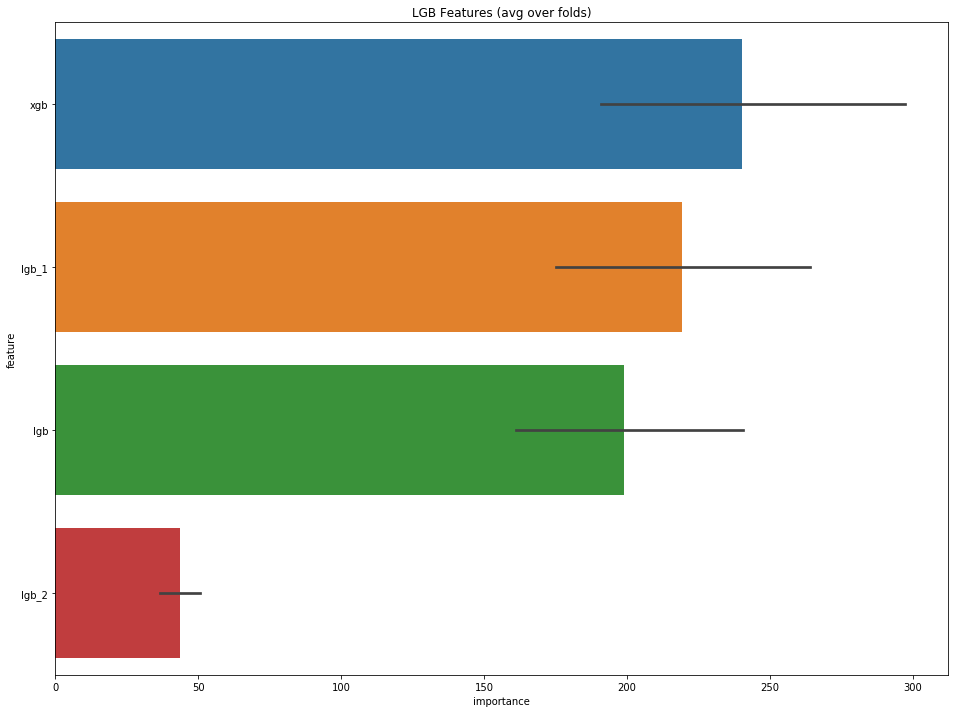

In [214]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:23:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[321]	training's rmse: 0.11208	valid_1's rmse: 0.121586
Fold 1 started at Tue Dec 17 12:23:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[499]	training's rmse: 0.110266	valid_1's rmse: 0.123901
Fold 2 started at Tue Dec 17 12:23:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[306]	training's rmse: 0.112672	valid_1's rmse: 0.11943
Fold 3 started at Tue Dec 17 12:23:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[256]	training's rmse: 0.11359	valid_1's rmse: 0.122318
Fold 4 started at Tue Dec 17 12:23:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[538]	training's rmse: 0.110129	valid_1's rmse: 0.124307
Fold 5 starte

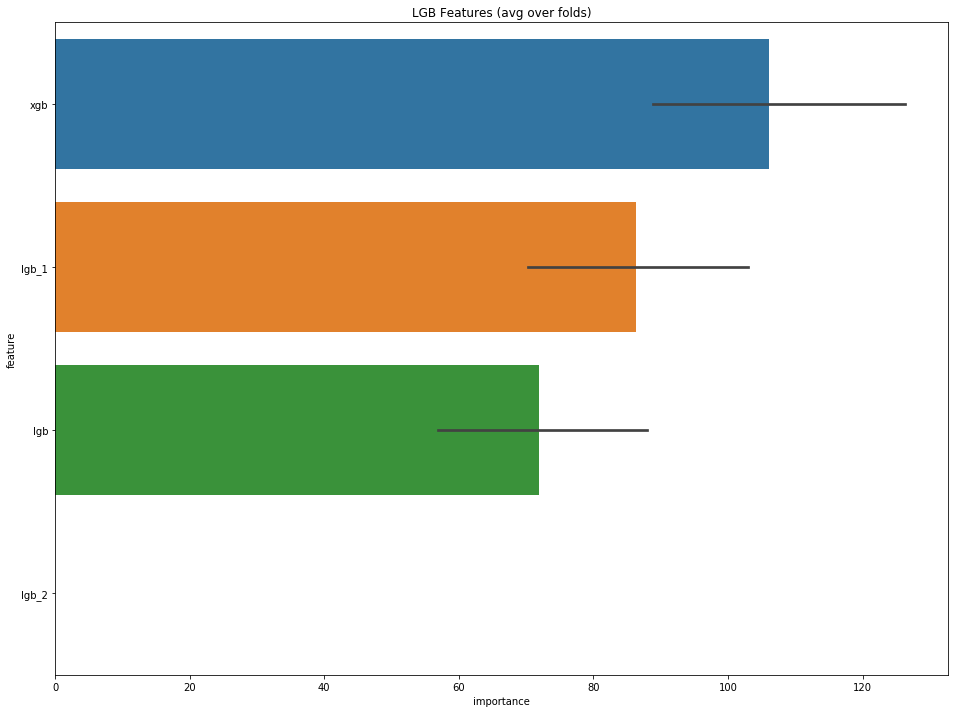

In [215]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [216]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:24:19 2019
Fold 1 started at Tue Dec 17 12:24:33 2019
Fold 2 started at Tue Dec 17 12:24:47 2019
Fold 3 started at Tue Dec 17 12:25:03 2019
Fold 4 started at Tue Dec 17 12:25:14 2019
Fold 5 started at Tue Dec 17 12:25:25 2019
Fold 6 started at Tue Dec 17 12:25:43 2019
Fold 7 started at Tue Dec 17 12:26:09 2019
Fold 8 started at Tue Dec 17 12:26:40 2019
Fold 9 started at Tue Dec 17 12:26:54 2019
CV mean score: 0.1174, std: 0.0076.


##### randomforest作为第二层融合模型

In [217]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:27:03 2019
Fold 1 started at Tue Dec 17 12:27:03 2019
Fold 2 started at Tue Dec 17 12:27:03 2019
Fold 3 started at Tue Dec 17 12:27:03 2019
Fold 4 started at Tue Dec 17 12:27:04 2019
Fold 5 started at Tue Dec 17 12:27:04 2019
Fold 6 started at Tue Dec 17 12:27:04 2019
Fold 7 started at Tue Dec 17 12:27:04 2019
Fold 8 started at Tue Dec 17 12:27:05 2019
Fold 9 started at Tue Dec 17 12:27:05 2019
CV mean score: 0.1226, std: 0.0073.


##### xgboost作为第二层融合模型

In [218]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:27:05 2019
[0]	train-rmse:0.482371	valid_data-rmse:0.473652
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.075029	valid_data-rmse:0.12871
Stopping. Best iteration:
[398]	train-rmse:0.079834	valid_data-rmse:0.127998

Fold 1 started at Tue Dec 17 12:27:06 2019
[0]	train-rmse:0.481849	valid_data-rmse:0.478451
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.075938	valid_data-rmse:0.124032
Stopping. Best iteration:
[518]	train-rmse:0.075168	valid_data-rmse:0.123888

Fold 2 started at Tue Dec 17 12:27:07 2019
[0]	train-rmse:0.480836	valid_data-rmse:0.487294
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

##### svr 作为第二层融合模型

In [219]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:27:14 2019
Fold 1 started at Tue Dec 17 12:27:14 2019
Fold 2 started at Tue Dec 17 12:27:14 2019
Fold 3 started at Tue Dec 17 12:27:14 2019
Fold 4 started at Tue Dec 17 12:27:14 2019
Fold 5 started at Tue Dec 17 12:27:14 2019
Fold 6 started at Tue Dec 17 12:27:14 2019
Fold 7 started at Tue Dec 17 12:27:14 2019
Fold 8 started at Tue Dec 17 12:27:14 2019
Fold 9 started at Tue Dec 17 12:27:14 2019
CV mean score: 0.1172, std: 0.0080.


##### 岭回归做第二层融合模型

In [220]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:27:14 2019
Fold 1 started at Tue Dec 17 12:27:15 2019
Fold 2 started at Tue Dec 17 12:27:15 2019
Fold 3 started at Tue Dec 17 12:27:15 2019
Fold 4 started at Tue Dec 17 12:27:15 2019
Fold 5 started at Tue Dec 17 12:27:15 2019
Fold 6 started at Tue Dec 17 12:27:15 2019
Fold 7 started at Tue Dec 17 12:27:15 2019
Fold 8 started at Tue Dec 17 12:27:15 2019
Fold 9 started at Tue Dec 17 12:27:15 2019
CV mean score: 0.1172, std: 0.0080.


#### 只留下cat

In [221]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['cat'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:27:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[331]	training's rmse: 0.111792	valid_1's rmse: 0.127913
Fold 1 started at Tue Dec 17 12:27:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[508]	training's rmse: 0.110875	valid_1's rmse: 0.121639
Fold 2 started at Tue Dec 17 12:27:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[278]	training's rmse: 0.112918	valid_1's rmse: 0.121288
Fold 3 started at Tue Dec 17 12:27:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 0.112971	valid_1's rmse: 0.117378
Fold 4 started at Tue Dec 17 12:27:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[275]	training's rmse: 0.113019	valid_1's rmse: 0.124839
Fold 5 sta

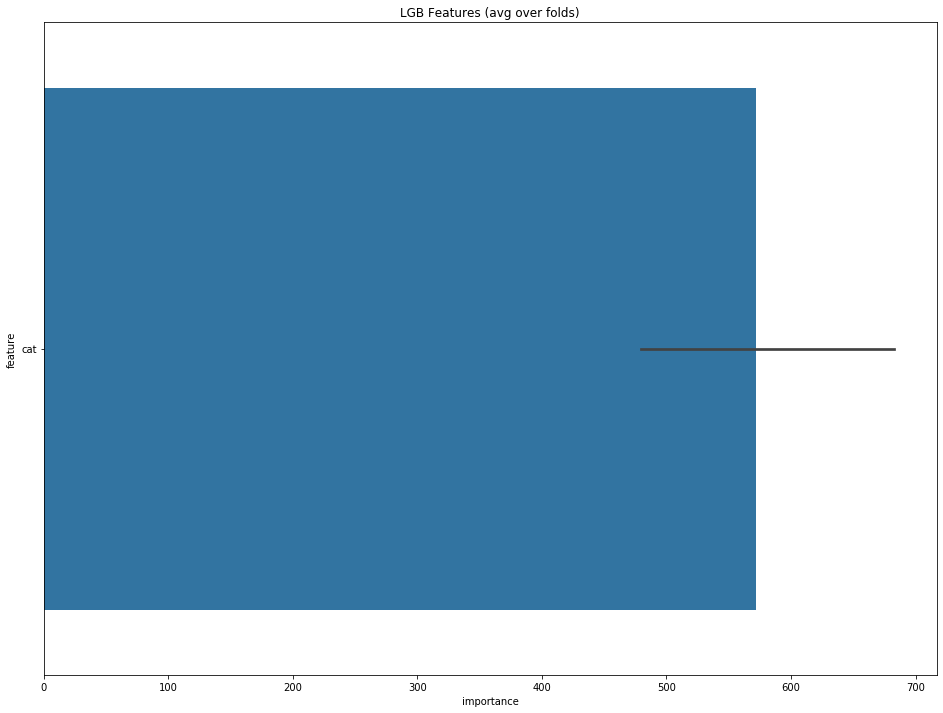

In [222]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:28:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[334]	training's rmse: 0.113622	valid_1's rmse: 0.126013
Fold 1 started at Tue Dec 17 12:28:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[712]	training's rmse: 0.11278	valid_1's rmse: 0.120772
Fold 2 started at Tue Dec 17 12:28:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[306]	training's rmse: 0.114489	valid_1's rmse: 0.119645
Fold 3 started at Tue Dec 17 12:28:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[419]	training's rmse: 0.11409	valid_1's rmse: 0.117164
Fold 4 started at Tue Dec 17 12:28:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[323]	training's rmse: 0.113943	valid_1's rmse: 0.12433
Fold 5 starte

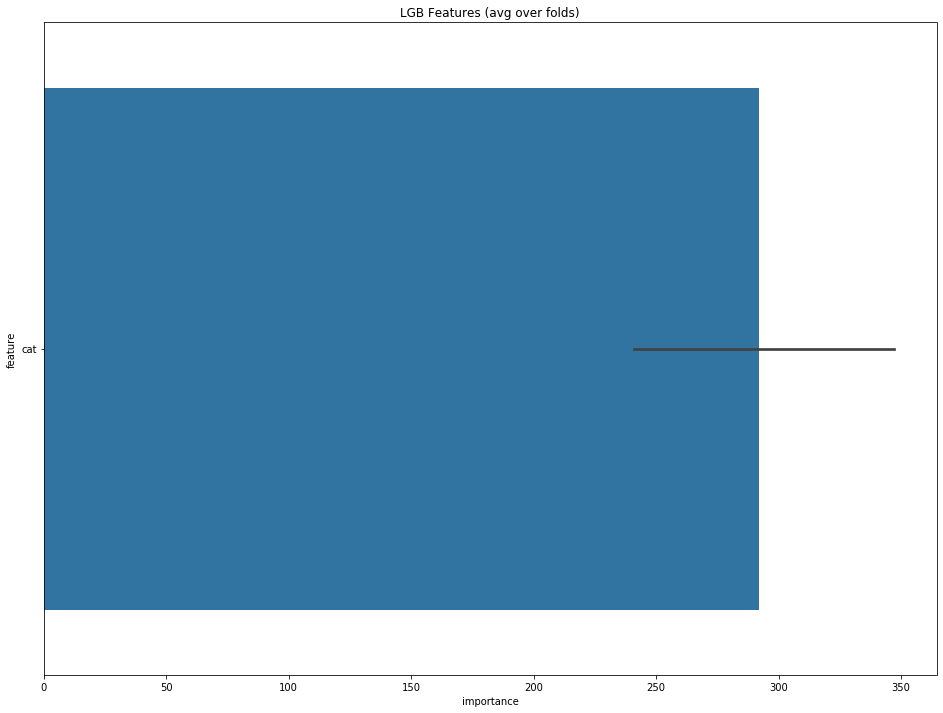

In [223]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [224]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:28:44 2019
Fold 1 started at Tue Dec 17 12:28:58 2019
Fold 2 started at Tue Dec 17 12:29:18 2019
Fold 3 started at Tue Dec 17 12:29:31 2019
Fold 4 started at Tue Dec 17 12:29:43 2019
Fold 5 started at Tue Dec 17 12:29:53 2019
Fold 6 started at Tue Dec 17 12:30:19 2019
Fold 7 started at Tue Dec 17 12:30:36 2019
Fold 8 started at Tue Dec 17 12:30:57 2019
Fold 9 started at Tue Dec 17 12:31:09 2019
CV mean score: 0.1177, std: 0.0077.


##### randomforest作为第二层融合模型

In [225]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:31:19 2019
Fold 1 started at Tue Dec 17 12:31:19 2019
Fold 2 started at Tue Dec 17 12:31:20 2019
Fold 3 started at Tue Dec 17 12:31:20 2019
Fold 4 started at Tue Dec 17 12:31:20 2019
Fold 5 started at Tue Dec 17 12:31:20 2019
Fold 6 started at Tue Dec 17 12:31:21 2019
Fold 7 started at Tue Dec 17 12:31:21 2019
Fold 8 started at Tue Dec 17 12:31:21 2019
Fold 9 started at Tue Dec 17 12:31:21 2019
CV mean score: 0.1284, std: 0.0085.


##### xgboost作为第二层融合模型

In [226]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:31:22 2019
[0]	train-rmse:0.482359	valid_data-rmse:0.473641
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.089603	valid_data-rmse:0.131843
Stopping. Best iteration:
[344]	train-rmse:0.095567	valid_data-rmse:0.131014

Fold 1 started at Tue Dec 17 12:31:22 2019
[0]	train-rmse:0.481852	valid_data-rmse:0.478517
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.090961	valid_data-rmse:0.121581
Stopping. Best iteration:
[498]	train-rmse:0.091028	valid_data-rmse:0.121562

Fold 2 started at Tue Dec 17 12:31:23 2019
[0]	train-rmse:0.480861	valid_data-rmse:0.487353
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds

##### svr 作为第二层融合模型

In [227]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:31:26 2019
Fold 1 started at Tue Dec 17 12:31:27 2019
Fold 2 started at Tue Dec 17 12:31:27 2019
Fold 3 started at Tue Dec 17 12:31:27 2019
Fold 4 started at Tue Dec 17 12:31:27 2019
Fold 5 started at Tue Dec 17 12:31:27 2019
Fold 6 started at Tue Dec 17 12:31:27 2019
Fold 7 started at Tue Dec 17 12:31:27 2019
Fold 8 started at Tue Dec 17 12:31:27 2019
Fold 9 started at Tue Dec 17 12:31:27 2019
CV mean score: 0.1177, std: 0.0076.


##### 岭回归做第二层融合模型

In [228]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:31:27 2019
Fold 1 started at Tue Dec 17 12:31:27 2019
Fold 2 started at Tue Dec 17 12:31:27 2019
Fold 3 started at Tue Dec 17 12:31:27 2019
Fold 4 started at Tue Dec 17 12:31:27 2019
Fold 5 started at Tue Dec 17 12:31:27 2019
Fold 6 started at Tue Dec 17 12:31:28 2019
Fold 7 started at Tue Dec 17 12:31:28 2019
Fold 8 started at Tue Dec 17 12:31:28 2019
Fold 9 started at Tue Dec 17 12:31:28 2019
CV mean score: 0.1176, std: 0.0077.


#### 只留下rfr

In [229]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:31:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[311]	training's rmse: 0.115302	valid_1's rmse: 0.124853
Fold 1 started at Tue Dec 17 12:31:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[321]	training's rmse: 0.114066	valid_1's rmse: 0.132644
Fold 2 started at Tue Dec 17 12:31:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[368]	training's rmse: 0.114987	valid_1's rmse: 0.124634
Fold 3 started at Tue Dec 17 12:32:00 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.111737	valid_1's rmse: 0.1179
Early stopping, best iteration is:
[1688]	training's rmse: 0.109984	valid_1's rmse: 0.117374
Fold 4 started at Tue Dec 17 12:32:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[269]	trai

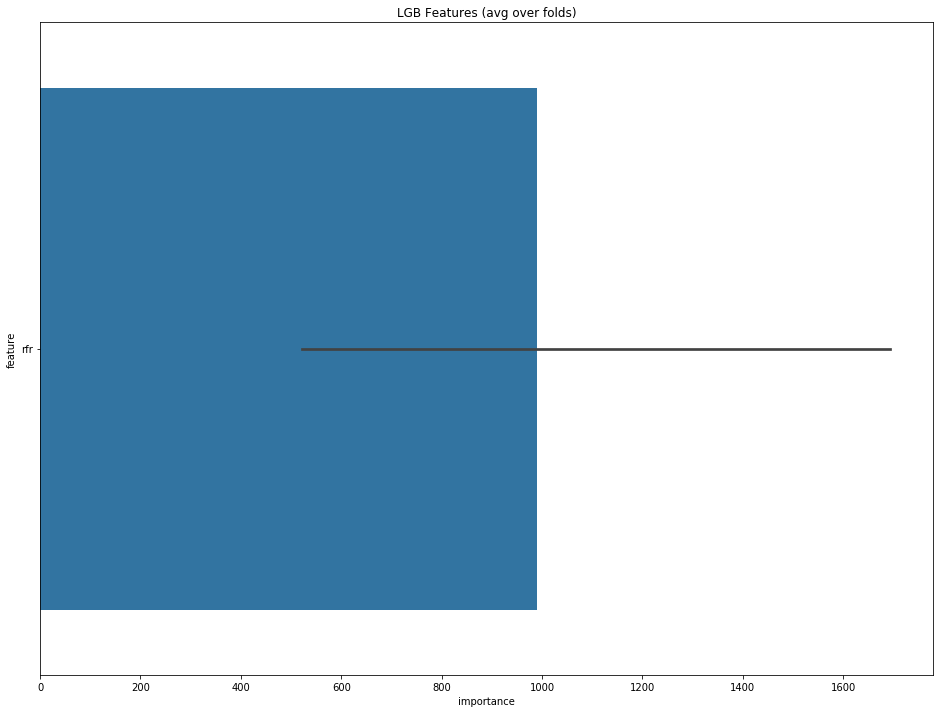

In [230]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:32:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[333]	training's rmse: 0.11675	valid_1's rmse: 0.123053
Fold 1 started at Tue Dec 17 12:32:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[340]	training's rmse: 0.115898	valid_1's rmse: 0.130323
Fold 2 started at Tue Dec 17 12:32:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[308]	training's rmse: 0.116992	valid_1's rmse: 0.124091
Fold 3 started at Tue Dec 17 12:32:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 0.117238	valid_1's rmse: 0.118386
Fold 4 started at Tue Dec 17 12:32:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[302]	training's rmse: 0.116228	valid_1's rmse: 0.128983
Fold 5 star

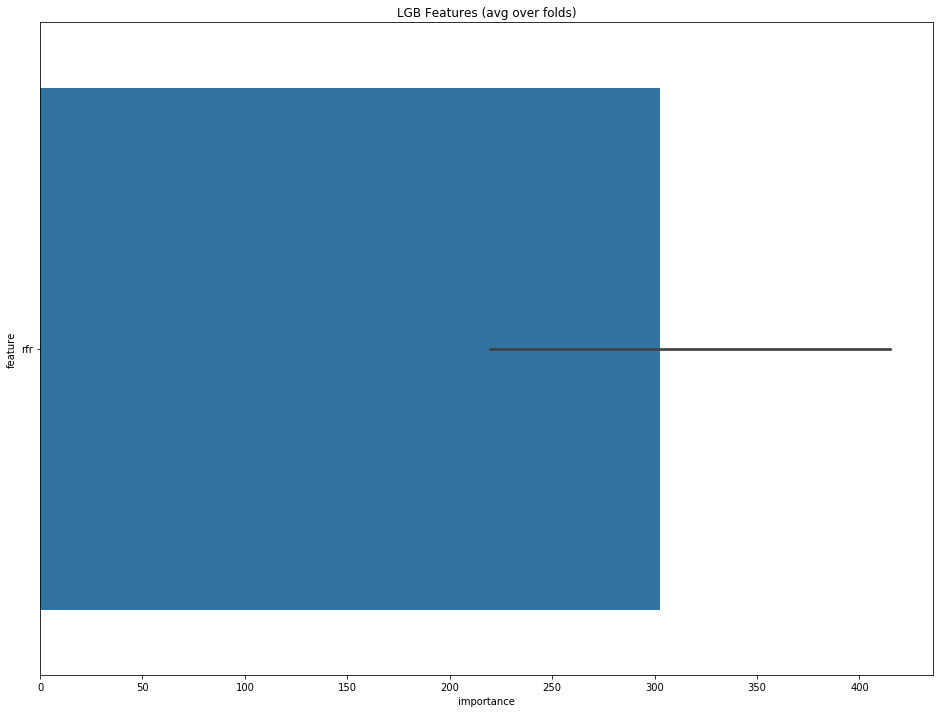

In [231]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [232]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:33:13 2019
Fold 1 started at Tue Dec 17 12:33:26 2019
Fold 2 started at Tue Dec 17 12:33:38 2019
Fold 3 started at Tue Dec 17 12:33:52 2019
Fold 4 started at Tue Dec 17 12:34:01 2019
Fold 5 started at Tue Dec 17 12:34:08 2019
Fold 6 started at Tue Dec 17 12:34:23 2019
Fold 7 started at Tue Dec 17 12:34:54 2019
Fold 8 started at Tue Dec 17 12:35:11 2019
Fold 9 started at Tue Dec 17 12:35:25 2019
CV mean score: 0.1196, std: 0.0070.


##### randomforest作为第二层融合模型

In [233]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:35:34 2019
Fold 1 started at Tue Dec 17 12:35:35 2019
Fold 2 started at Tue Dec 17 12:35:35 2019
Fold 3 started at Tue Dec 17 12:35:35 2019
Fold 4 started at Tue Dec 17 12:35:35 2019
Fold 5 started at Tue Dec 17 12:35:36 2019
Fold 6 started at Tue Dec 17 12:35:36 2019
Fold 7 started at Tue Dec 17 12:35:36 2019
Fold 8 started at Tue Dec 17 12:35:36 2019
Fold 9 started at Tue Dec 17 12:35:37 2019
CV mean score: 0.1289, std: 0.0094.


##### xgboost作为第二层融合模型

In [234]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:35:37 2019
[0]	train-rmse:0.482382	valid_data-rmse:0.473596
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.092015	valid_data-rmse:0.129724
Stopping. Best iteration:
[378]	train-rmse:0.096538	valid_data-rmse:0.128809

Fold 1 started at Tue Dec 17 12:35:37 2019
[0]	train-rmse:0.481853	valid_data-rmse:0.478492
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.091393	valid_data-rmse:0.135437
Stopping. Best iteration:
[352]	train-rmse:0.097418	valid_data-rmse:0.134123

Fold 2 started at Tue Dec 17 12:35:38 2019
[0]	train-rmse:0.480857	valid_data-rmse:0.48734
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

##### svr 作为第二层融合模型

In [235]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:35:41 2019
Fold 1 started at Tue Dec 17 12:35:41 2019
Fold 2 started at Tue Dec 17 12:35:41 2019
Fold 3 started at Tue Dec 17 12:35:41 2019
Fold 4 started at Tue Dec 17 12:35:41 2019
Fold 5 started at Tue Dec 17 12:35:41 2019
Fold 6 started at Tue Dec 17 12:35:41 2019
Fold 7 started at Tue Dec 17 12:35:42 2019
Fold 8 started at Tue Dec 17 12:35:42 2019
Fold 9 started at Tue Dec 17 12:35:42 2019
CV mean score: 0.1192, std: 0.0069.


##### 岭回归做第二层融合模型

In [236]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:35:42 2019
Fold 1 started at Tue Dec 17 12:35:42 2019
Fold 2 started at Tue Dec 17 12:35:42 2019
Fold 3 started at Tue Dec 17 12:35:42 2019
Fold 4 started at Tue Dec 17 12:35:42 2019
Fold 5 started at Tue Dec 17 12:35:42 2019
Fold 6 started at Tue Dec 17 12:35:42 2019
Fold 7 started at Tue Dec 17 12:35:42 2019
Fold 8 started at Tue Dec 17 12:35:43 2019
Fold 9 started at Tue Dec 17 12:35:43 2019
CV mean score: 0.1191, std: 0.0070.


#### 只留下svr

In [237]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:35:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[290]	training's rmse: 0.12794	valid_1's rmse: 0.149041
Fold 1 started at Tue Dec 17 12:35:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[389]	training's rmse: 0.127224	valid_1's rmse: 0.145908
Fold 2 started at Tue Dec 17 12:36:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[553]	training's rmse: 0.127447	valid_1's rmse: 0.13019
Fold 3 started at Tue Dec 17 12:36:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[221]	training's rmse: 0.131188	valid_1's rmse: 0.134336
Fold 4 started at Tue Dec 17 12:36:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[339]	training's rmse: 0.129078	valid_1's rmse: 0.133104
Fold 5 start

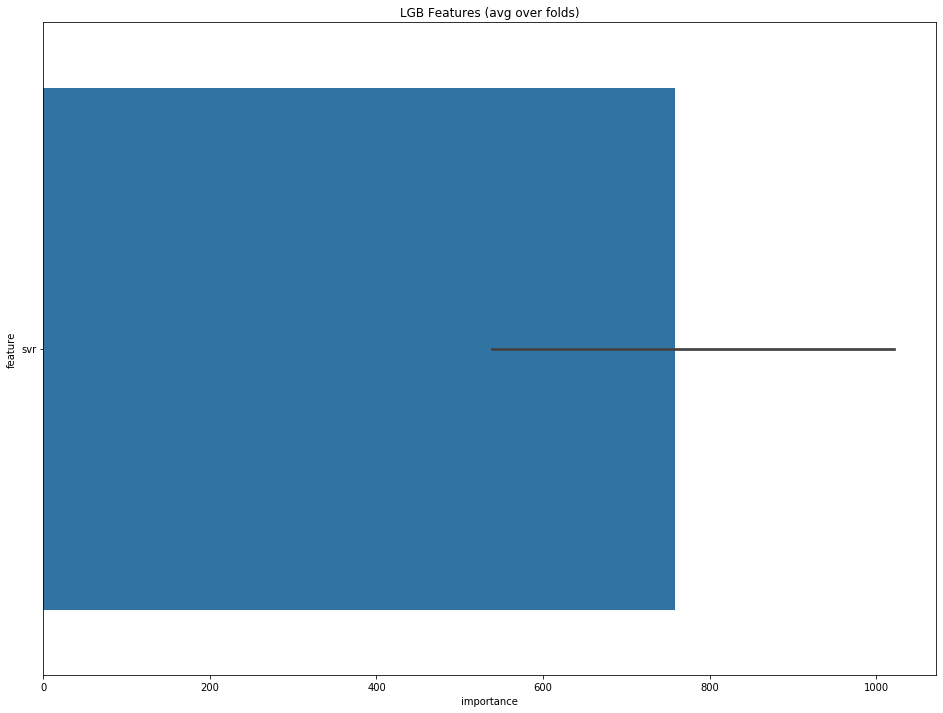

In [238]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:36:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[283]	training's rmse: 0.130225	valid_1's rmse: 0.147641
Fold 1 started at Tue Dec 17 12:36:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[423]	training's rmse: 0.129966	valid_1's rmse: 0.14377
Fold 2 started at Tue Dec 17 12:36:44 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.129822	valid_1's rmse: 0.129816
Early stopping, best iteration is:
[945]	training's rmse: 0.129946	valid_1's rmse: 0.129787
Fold 3 started at Tue Dec 17 12:36:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[251]	training's rmse: 0.132571	valid_1's rmse: 0.133312
Fold 4 started at Tue Dec 17 12:36:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[558]	trai

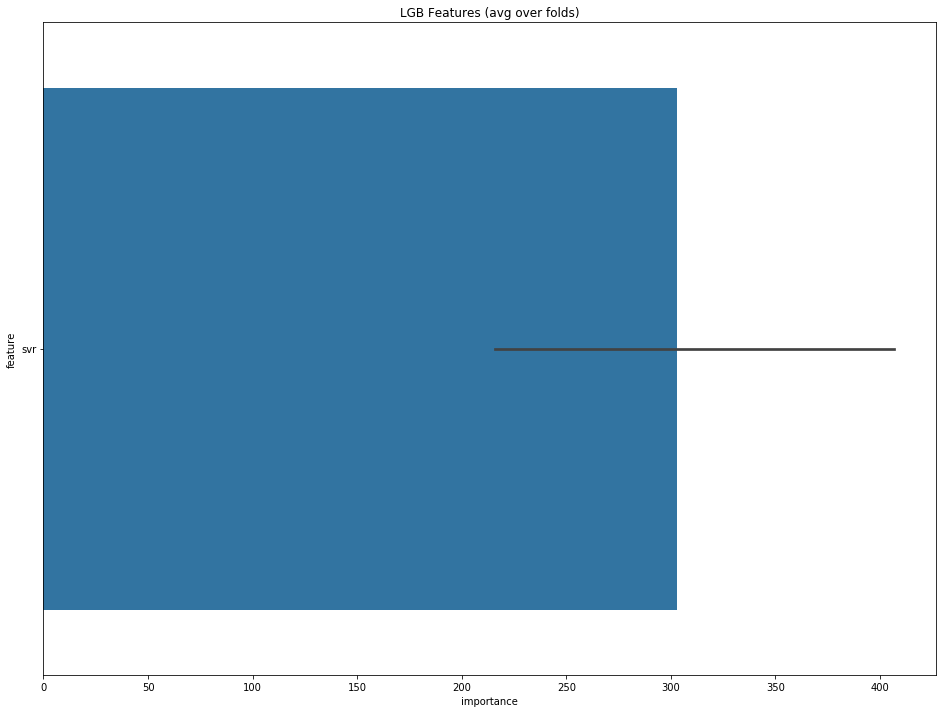

In [239]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [240]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:36:50 2019
Fold 1 started at Tue Dec 17 12:36:57 2019
Fold 2 started at Tue Dec 17 12:37:05 2019
Fold 3 started at Tue Dec 17 12:37:33 2019
Fold 4 started at Tue Dec 17 12:37:38 2019
Fold 5 started at Tue Dec 17 12:37:57 2019
Fold 6 started at Tue Dec 17 12:38:03 2019
Fold 7 started at Tue Dec 17 12:38:24 2019
Fold 8 started at Tue Dec 17 12:38:35 2019
Fold 9 started at Tue Dec 17 12:38:41 2019
CV mean score: 0.1346, std: 0.0075.


##### randomforest作为第二层融合模型

In [241]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:38:51 2019
Fold 1 started at Tue Dec 17 12:38:51 2019
Fold 2 started at Tue Dec 17 12:38:51 2019
Fold 3 started at Tue Dec 17 12:38:52 2019
Fold 4 started at Tue Dec 17 12:38:52 2019
Fold 5 started at Tue Dec 17 12:38:52 2019
Fold 6 started at Tue Dec 17 12:38:52 2019
Fold 7 started at Tue Dec 17 12:38:53 2019
Fold 8 started at Tue Dec 17 12:38:53 2019
Fold 9 started at Tue Dec 17 12:38:53 2019
CV mean score: 0.1425, std: 0.0089.


##### xgboost作为第二层融合模型

In [242]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:38:53 2019
[0]	train-rmse:0.482458	valid_data-rmse:0.473829
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.102724	valid_data-rmse:0.157282
Stopping. Best iteration:
[336]	train-rmse:0.109686	valid_data-rmse:0.155069

Fold 1 started at Tue Dec 17 12:38:54 2019
[0]	train-rmse:0.481931	valid_data-rmse:0.478672
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.103955	valid_data-rmse:0.149373
Stopping. Best iteration:
[323]	train-rmse:0.112034	valid_data-rmse:0.147845

Fold 2 started at Tue Dec 17 12:38:54 2019
[0]	train-rmse:0.480932	valid_data-rmse:0.487366
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds

##### svr 作为第二层融合模型

In [243]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:38:58 2019
Fold 1 started at Tue Dec 17 12:38:58 2019
Fold 2 started at Tue Dec 17 12:38:58 2019
Fold 3 started at Tue Dec 17 12:38:58 2019
Fold 4 started at Tue Dec 17 12:38:58 2019
Fold 5 started at Tue Dec 17 12:38:58 2019
Fold 6 started at Tue Dec 17 12:38:58 2019
Fold 7 started at Tue Dec 17 12:38:58 2019
Fold 8 started at Tue Dec 17 12:38:58 2019
Fold 9 started at Tue Dec 17 12:38:58 2019
CV mean score: 0.1361, std: 0.0076.


##### 岭回归做第二层融合模型

In [244]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:38:58 2019
Fold 1 started at Tue Dec 17 12:38:58 2019
Fold 2 started at Tue Dec 17 12:38:58 2019
Fold 3 started at Tue Dec 17 12:38:58 2019
Fold 4 started at Tue Dec 17 12:38:59 2019
Fold 5 started at Tue Dec 17 12:38:59 2019
Fold 6 started at Tue Dec 17 12:38:59 2019
Fold 7 started at Tue Dec 17 12:38:59 2019
Fold 8 started at Tue Dec 17 12:38:59 2019
Fold 9 started at Tue Dec 17 12:38:59 2019
CV mean score: 0.1368, std: 0.0074.


#### 只留下xgb

In [245]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:38:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[339]	training's rmse: 0.11399	valid_1's rmse: 0.12122
Fold 1 started at Tue Dec 17 12:39:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[317]	training's rmse: 0.114006	valid_1's rmse: 0.124571
Fold 2 started at Tue Dec 17 12:39:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[295]	training's rmse: 0.115207	valid_1's rmse: 0.118789
Fold 3 started at Tue Dec 17 12:39:16 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.111466	valid_1's rmse: 0.121971
Early stopping, best iteration is:
[1422]	training's rmse: 0.110622	valid_1's rmse: 0.121733
Fold 4 started at Tue Dec 17 12:39:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[290]	trai

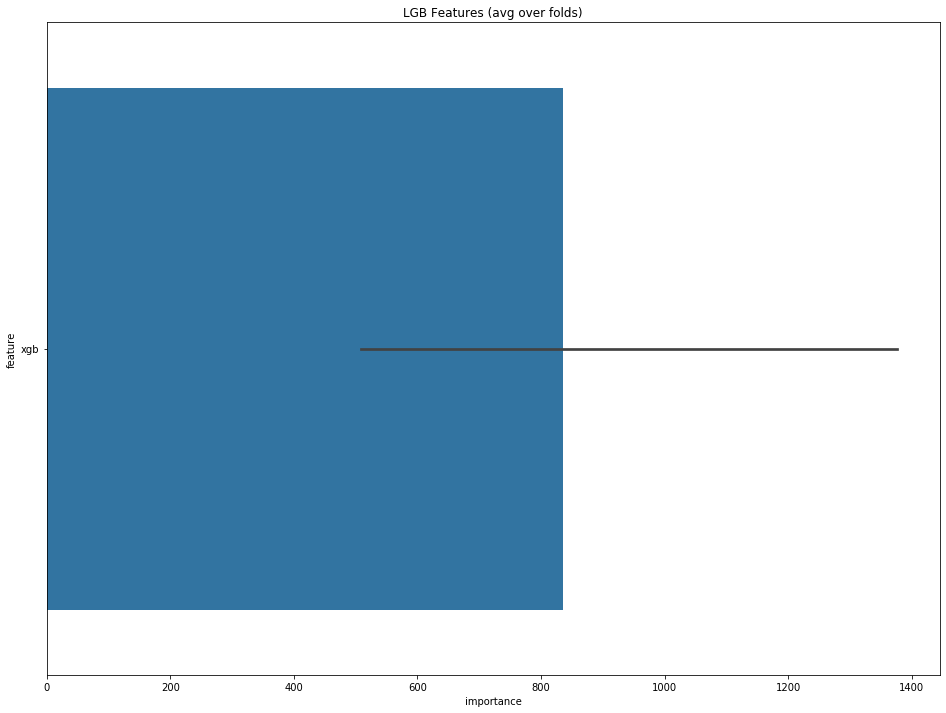

In [246]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:39:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[415]	training's rmse: 0.115518	valid_1's rmse: 0.119477
Fold 1 started at Tue Dec 17 12:40:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[401]	training's rmse: 0.115401	valid_1's rmse: 0.123422
Fold 2 started at Tue Dec 17 12:40:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[328]	training's rmse: 0.116574	valid_1's rmse: 0.118321
Fold 3 started at Tue Dec 17 12:40:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[356]	training's rmse: 0.115641	valid_1's rmse: 0.123309
Fold 4 started at Tue Dec 17 12:40:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[239]	training's rmse: 0.116846	valid_1's rmse: 0.129473
Fold 5 sta

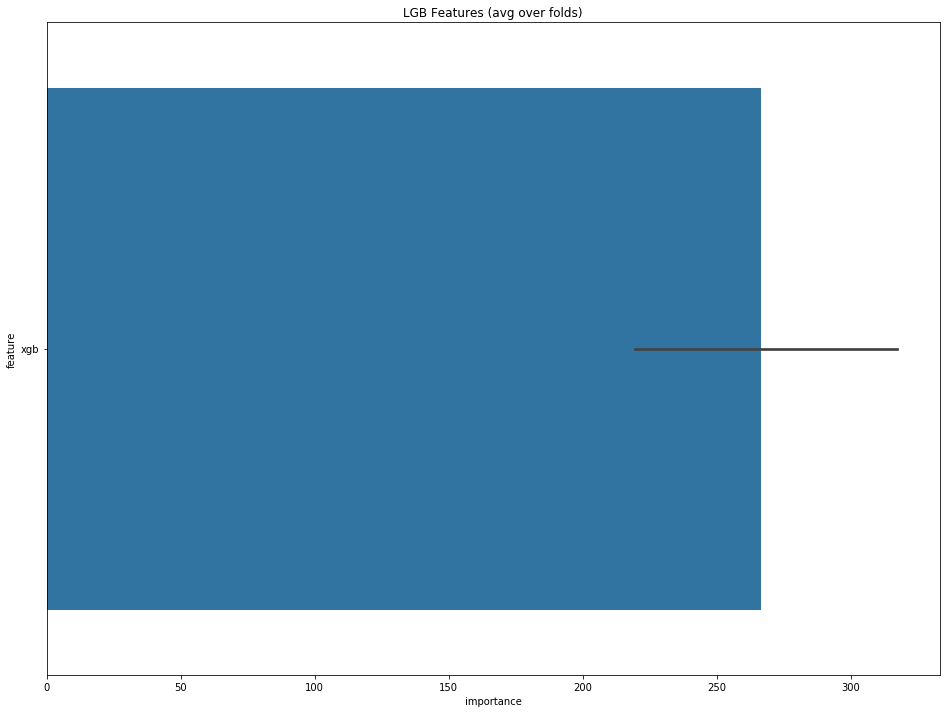

In [247]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [248]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:40:21 2019
Fold 1 started at Tue Dec 17 12:40:33 2019
Fold 2 started at Tue Dec 17 12:40:39 2019
Fold 3 started at Tue Dec 17 12:40:49 2019
Fold 4 started at Tue Dec 17 12:40:54 2019
Fold 5 started at Tue Dec 17 12:41:00 2019
Fold 6 started at Tue Dec 17 12:41:17 2019
Fold 7 started at Tue Dec 17 12:41:30 2019
Fold 8 started at Tue Dec 17 12:41:42 2019
Fold 9 started at Tue Dec 17 12:41:49 2019
CV mean score: 0.1191, std: 0.0073.


##### randomforest作为第二层融合模型

In [249]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:41:55 2019
Fold 1 started at Tue Dec 17 12:41:55 2019
Fold 2 started at Tue Dec 17 12:41:55 2019
Fold 3 started at Tue Dec 17 12:41:56 2019
Fold 4 started at Tue Dec 17 12:41:56 2019
Fold 5 started at Tue Dec 17 12:41:56 2019
Fold 6 started at Tue Dec 17 12:41:56 2019
Fold 7 started at Tue Dec 17 12:41:57 2019
Fold 8 started at Tue Dec 17 12:41:57 2019
Fold 9 started at Tue Dec 17 12:41:57 2019
CV mean score: 0.1285, std: 0.0089.


##### xgboost作为第二层融合模型

In [250]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:41:57 2019
[0]	train-rmse:0.482382	valid_data-rmse:0.473626
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.091757	valid_data-rmse:0.124162
Stopping. Best iteration:
[350]	train-rmse:0.097958	valid_data-rmse:0.123199

Fold 1 started at Tue Dec 17 12:41:58 2019
[0]	train-rmse:0.481854	valid_data-rmse:0.478429
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.091404	valid_data-rmse:0.13094
Stopping. Best iteration:
[316]	train-rmse:0.100144	valid_data-rmse:0.129025

Fold 2 started at Tue Dec 17 12:41:58 2019
[0]	train-rmse:0.480846	valid_data-rmse:0.487189
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

##### svr 作为第二层融合模型

In [251]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:42:02 2019
Fold 1 started at Tue Dec 17 12:42:02 2019
Fold 2 started at Tue Dec 17 12:42:02 2019
Fold 3 started at Tue Dec 17 12:42:02 2019
Fold 4 started at Tue Dec 17 12:42:02 2019
Fold 5 started at Tue Dec 17 12:42:02 2019
Fold 6 started at Tue Dec 17 12:42:02 2019
Fold 7 started at Tue Dec 17 12:42:02 2019
Fold 8 started at Tue Dec 17 12:42:02 2019
Fold 9 started at Tue Dec 17 12:42:02 2019
CV mean score: 0.1192, std: 0.0080.


##### 岭回归做第二层融合模型

In [252]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:42:02 2019
Fold 1 started at Tue Dec 17 12:42:02 2019
Fold 2 started at Tue Dec 17 12:42:02 2019
Fold 3 started at Tue Dec 17 12:42:03 2019
Fold 4 started at Tue Dec 17 12:42:03 2019
Fold 5 started at Tue Dec 17 12:42:03 2019
Fold 6 started at Tue Dec 17 12:42:03 2019
Fold 7 started at Tue Dec 17 12:42:03 2019
Fold 8 started at Tue Dec 17 12:42:03 2019
Fold 9 started at Tue Dec 17 12:42:03 2019
CV mean score: 0.1189, std: 0.0081.


#### 只留下lgb

In [253]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:42:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 0.111779	valid_1's rmse: 0.126815
Fold 1 started at Tue Dec 17 12:42:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[311]	training's rmse: 0.110514	valid_1's rmse: 0.12596
Fold 2 started at Tue Dec 17 12:42:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[352]	training's rmse: 0.110134	valid_1's rmse: 0.122648
Fold 3 started at Tue Dec 17 12:42:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[234]	training's rmse: 0.11267	valid_1's rmse: 0.127346
Fold 4 started at Tue Dec 17 12:42:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[326]	training's rmse: 0.110425	valid_1's rmse: 0.126185
Fold 5 start

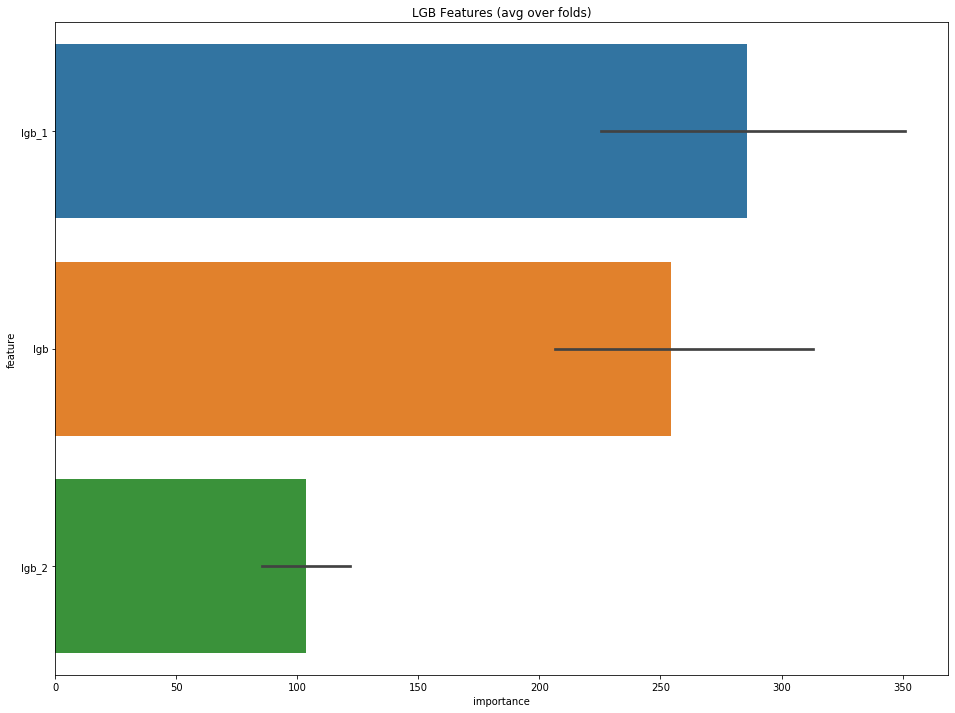

In [254]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:42:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[284]	training's rmse: 0.114566	valid_1's rmse: 0.123124
Fold 1 started at Tue Dec 17 12:42:19 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.111308	valid_1's rmse: 0.124492
Early stopping, best iteration is:
[1017]	training's rmse: 0.111243	valid_1's rmse: 0.124473
Fold 2 started at Tue Dec 17 12:42:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[337]	training's rmse: 0.114097	valid_1's rmse: 0.121975
Fold 3 started at Tue Dec 17 12:42:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 0.115259	valid_1's rmse: 0.123273
Fold 4 started at Tue Dec 17 12:42:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[616]	tr

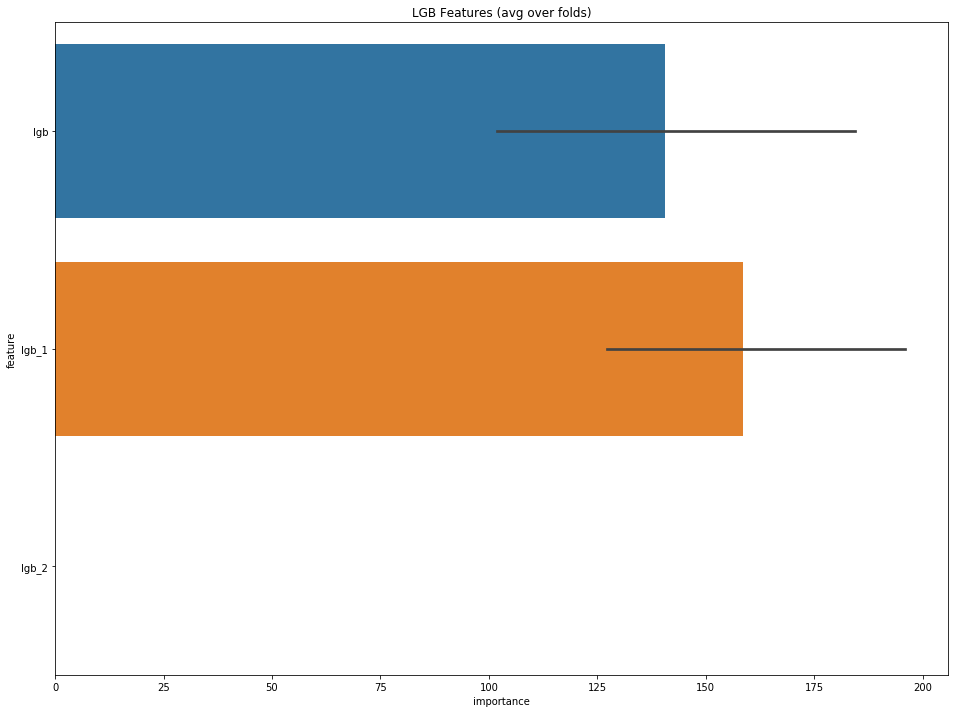

In [255]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [256]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:42:45 2019
Fold 1 started at Tue Dec 17 12:42:56 2019
Fold 2 started at Tue Dec 17 12:43:03 2019
Fold 3 started at Tue Dec 17 12:43:12 2019
Fold 4 started at Tue Dec 17 12:43:18 2019
Fold 5 started at Tue Dec 17 12:43:23 2019
Fold 6 started at Tue Dec 17 12:43:30 2019
Fold 7 started at Tue Dec 17 12:43:37 2019
Fold 8 started at Tue Dec 17 12:43:48 2019
Fold 9 started at Tue Dec 17 12:43:51 2019
CV mean score: 0.1181, std: 0.0078.


##### randomforest作为第二层融合模型

In [257]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:43:53 2019
Fold 1 started at Tue Dec 17 12:43:53 2019
Fold 2 started at Tue Dec 17 12:43:53 2019
Fold 3 started at Tue Dec 17 12:43:54 2019
Fold 4 started at Tue Dec 17 12:43:54 2019
Fold 5 started at Tue Dec 17 12:43:54 2019
Fold 6 started at Tue Dec 17 12:43:54 2019
Fold 7 started at Tue Dec 17 12:43:55 2019
Fold 8 started at Tue Dec 17 12:43:55 2019
Fold 9 started at Tue Dec 17 12:43:55 2019
CV mean score: 0.1260, std: 0.0066.


##### xgboost作为第二层融合模型

In [258]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:43:55 2019
[0]	train-rmse:0.482381	valid_data-rmse:0.473668
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.084146	valid_data-rmse:0.132746
Stopping. Best iteration:
[337]	train-rmse:0.091842	valid_data-rmse:0.131313

Fold 1 started at Tue Dec 17 12:43:56 2019
[0]	train-rmse:0.481854	valid_data-rmse:0.478452
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.085012	valid_data-rmse:0.126553
Stopping. Best iteration:
[403]	train-rmse:0.08887	valid_data-rmse:0.126129

Fold 2 started at Tue Dec 17 12:43:56 2019
[0]	train-rmse:0.480853	valid_data-rmse:0.48735
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


##### svr 作为第二层融合模型

In [259]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:44:01 2019
Fold 1 started at Tue Dec 17 12:44:01 2019
Fold 2 started at Tue Dec 17 12:44:01 2019
Fold 3 started at Tue Dec 17 12:44:01 2019
Fold 4 started at Tue Dec 17 12:44:01 2019
Fold 5 started at Tue Dec 17 12:44:01 2019
Fold 6 started at Tue Dec 17 12:44:01 2019
Fold 7 started at Tue Dec 17 12:44:01 2019
Fold 8 started at Tue Dec 17 12:44:01 2019
Fold 9 started at Tue Dec 17 12:44:01 2019
CV mean score: 0.1176, std: 0.0080.


##### 岭回归做第二层融合模型

In [260]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:44:01 2019
Fold 1 started at Tue Dec 17 12:44:01 2019
Fold 2 started at Tue Dec 17 12:44:01 2019
Fold 3 started at Tue Dec 17 12:44:01 2019
Fold 4 started at Tue Dec 17 12:44:01 2019
Fold 5 started at Tue Dec 17 12:44:01 2019
Fold 6 started at Tue Dec 17 12:44:01 2019
Fold 7 started at Tue Dec 17 12:44:02 2019
Fold 8 started at Tue Dec 17 12:44:02 2019
Fold 9 started at Tue Dec 17 12:44:02 2019
CV mean score: 0.1174, std: 0.0081.


In [261]:
print(scorelist)

[0.1367218423685398, 0.11781282265253479, 0.11727461172664835, 0.11727461172664835, 0.11905865507086373, 0.11892988698510236, 0.11749119029558144, 0.11924291279598605, 0.11697899935575004, 0.11703484258061252, 0.12088619841701391, 0.12091074620303052, 0.11683929827492737, 0.11672593079831961, 0.11806679269061442, 0.11641939943337247, 0.11679477158982761, 0.11724936288542262, 0.12027591116243194, 0.11690000047493891, 0.11694378049830315, 0.1198048484819207, 0.11808433401889959, 0.11757328690880205, 0.12094625071434166, 0.1226822313849808, 0.11694930859302674, 0.11689444836481418, 0.11955056181008879, 0.11681960683986903, 0.1166784398184818, 0.11884595379775287, 0.1211144612558643, 0.11673718782362064, 0.11655244258506739, 0.1188699472226207, 0.11714721657141085, 0.11704525254096343, 0.11910719728851446, 0.12061446034669702, 0.11681330777323713, 0.11674984365042276, 0.1211881254655045, 0.11919792790306091, 0.117663235799454, 0.12110849192547288, 0.12199480948552732, 0.11717229183268951, 

In [262]:
min(scorelist)

0.11595399288313432

In [263]:
scorelist[0:7]

[0.1367218423685398,
 0.11781282265253479,
 0.11727461172664835,
 0.11727461172664835,
 0.11905865507086373,
 0.11892988698510236,
 0.11749119029558144]

In [265]:
scorelist.index(min(scorelist))

142

In [266]:
len(scorelist)

224